# Graph embedding

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from pathlib import Path
from collections import defaultdict
import csv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import networkx as nx
from node2vec import Node2Vec
import pickle


/opt/anaconda3/envs/ccfp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
area_df = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_info.csv',
    header=None,
    encoding='GBK',
    engine='python',
    names=[
        'ID', 'area_name', 'area_type', 'center_x', 'center_y', 'grid_x',
        'grid_y', 'area'
    ])

strength_path = Path(
    '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/datafountain_competition_od.txt'
)

In [3]:
def add_grid_id_to_areas(area_df):
    # 区域中心点的坐标集合
    coords = area_df[['center_x', 'center_y']].values

    # 缩放坐标集合到网格经纬度范围内
    x_min, x_max = 115.994279229, 116.747278635
    y_min, y_max = 39.681856275, 40.188086241
    coords[:, 0] = (coords[:, 0] - x_min) / (x_max - x_min)
    coords[:, 1] = (coords[:, 1] - y_min) / (y_max - y_min)

    # 将坐标集合聚类为200个簇
    kmeans = KMeans(n_clusters=200, random_state=0).fit(coords)

    # 将每个区域ID映射到所属的簇
    area_df = area_df.copy()
    area_df['Grid_ID'] = kmeans.predict(coords) + 1

    return area_df



def get_grid(strength_path):
    '''
    从"datafountain_competition_od.txt"文件中读取数据，提取出发地和目的地的网格中心点经纬度，
    并将其四舍五入到小数点后四位，然后将这些网格中心点加入到一个集合"grid_set"中
    '''
    grid_set = set()

    with open(strength_path) as f:
        for line in f:
            a, b = [(round(float(x), 4), round(float(y), 4)) for x, y in
                    [line.strip().split('\t')[1:3],
                     line.strip().split('\t')[3:5]]]
            grid_set.update([a, b])

    return grid_set



def get_grid_strength(strength_path):
    '''
    构建一个名为"grid_strength"的三层嵌套字典，其中第一层的键为出发地的网格中心点经纬度，
    第二层的键为到达地的网格中心点经纬度，第三层的键为时刻（0-23），值为从出发地到到达地在该时刻的联系强度。
    对于每一行读取到的数据，都会将其所对应的出发地和到达地的网格中心点的联系强度存储到"grid_strength"字典中
    '''
    grid_strength = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Open the data file and loop over each line
    with open(strength_path) as f:
        for line in tqdm(f):
            cont = line.strip().split('\t')
            a = (round(float(cont[1]), 4), round(float(cont[2]), 4))  # 出发网格中心点经纬度
            b = (round(float(cont[3]), 4), round(float(cont[4]), 4))  # 到达网格中心点经纬度

            # t 时刻（0-23）
            hour = int(cont[0])
            # 区域间的联系强度
            weight = float(cont[-1])

            grid_strength[a][b][hour].append(weight)

    return grid_strength


def get_area_info():
    '''
    从"area_passenger_info.csv"文件中读取数据，提取区域ID、网格ID、区域中心点所在网格的中心点经纬度、区域面积、区域类型等信息，
    然后将这些信息存储到以网格ID为键的字典中。
    '''
    # Define the path to the CSV file
    csv_path = Path('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_info.csv')

    # Define a dictionary to map area types from Chinese to English
    type2eng = {
        '旅游景点;公园': 'Attraction;Park',
        '旅游景点;植物园': 'Attraction;Arboretum',
        '旅游景点;游乐园': 'Attraction;Amusement',
        '旅游景点;水族馆': 'Attraction;Aquarium',
        '旅游景点;动物园': 'Attraction;Zoo',
        '旅游景点;文物古迹': 'Attraction;Monument',
        '旅游景点;风景区': 'Attraction;ScenicSpot',
        '教育培训;高等院校': 'Education;School',
        '购物;购物中心': 'Shopping;Mall',
        '医疗;综合医院': 'Sanitation;Hospital',
        '运动健身;体育场馆': 'Sport;Stadium',
        '交通设施;火车站': 'Transportation;Train',
        '交通设施;长途汽车站': 'Transportation;Bus',
        '交通设施;飞机场': 'Transportation;Airport'
    }

    # Initialize dictionaries to store the data
    ID_grid, grid_ID, ID_area, ID_center, ID_sq, area_type = {}, {}, {}, {}, {}, {}

    # Open the CSV file and read the data
    with open(csv_path, encoding='gbk') as f:
        # Use csv module to read the file
        reader = csv.reader(f)

        # Loop over each row in the CSV file
        for row in tqdm(reader):
            # Get the latitude and longitude of the grid center point
            grid_center = (round(float(row[5]), 4), round(float(row[6]), 4))

            # Get the area ID and store the data in the corresponding dictionaries
            ID = int(row[0])
            ID_grid[ID], ID_area[ID], ID_center[ID], ID_sq[ID], area_type[ID] = grid_center, row[1], (float(row[3]), float(row[4])), float(row[-1]), type2eng[row[2]].split(';')[0]

            # Add the area ID to the list of IDs associated with this grid center point
            if grid_center not in grid_ID:
                grid_ID[grid_center] = []
            grid_ID[grid_center].append(ID)

    # Return the dictionaries
    return ID_grid, grid_ID, ID_area, ID_center, ID_sq, area_type


def match_supply_to_grid(ID_grid, grid_ID, grid_strength, ID_center, ID_sq, ID_area):
    """
    将未覆盖的供应点匹配到距离最近的网格中心点，并返回新的网格-供应点字典

    Args:
        ID_grid (dict): 区域 ID 到网格中心点坐标的字典
        grid_ID (dict): 网格中心点坐标到区域 ID 列表的字典
        grid_strength (list): 已覆盖区域的网格中心点坐标列表
        ID_center (dict): 区域 ID 到区域中心点坐标的字典
        ID_sq (dict): 区域 ID 到面积的字典
        ID_area (dict): 区域 ID 到区域类型的字典

    Returns:
        grid_ID_new (dict): 新的网格-供应点字典
    """
    # 初始化 ID_grid_supply
    ID_grid_supply = {}

    for g in tqdm(set(grid_ID) - set(grid_strength)):
        for a_id in grid_ID[g]:
            ID_grid_supply[a_id] = {}
            # 初始化最小距离和最近的网格点为 None
            min_dist = float('inf')  # 直接使用无穷大
            min_g = None
            # 获取该区域的中心点 g1
            g1 = ID_center[a_id]
            # 遍历所有已覆盖的网格，使用 set 函数避免重复计算
            for g2 in set(grid_strength):
                dist = geodesic((g1[1], g1[0]),
                                (g2[1], g2[0])).m
                # 如果 dist 小于当前最小距离，则更新最小距离和最近的网格 min_g
                if dist < min_dist:
                    min_dist = dist
                    min_g = g2
            # 将最近的网格、该区域的面积和距离存储到 ID_grid_supply 字典中
            ID_grid_supply[a_id]['grid'] = min_g
            ID_grid_supply[a_id]['sq'] = ID_sq[a_id]
            ID_grid_supply[a_id]['dist'] = min_dist

    # 由于需要修改ID_grid，先创建一个副本
    ID_grid_new = ID_grid.copy()
    # 存储新的网格-供应点字典
    grid_ID_new = {}

    # 遍历所有供应点，并将其与最近的网格进行匹配
    for m, n in ID_grid_supply.items():
        ID_grid_new[m] = n['grid']

    for m, n in ID_grid_new.items():
        if m not in grid_ID_new:
            grid_ID_new[n] = []
        grid_ID_new[n].append(m)

    return grid_ID_new, ID_grid_new

In [4]:
area_df = add_grid_id_to_areas(area_df)
grid_strength = get_grid_strength(strength_path)
ID_grid, grid_ID, ID_area, ID_center, ID_sq, area_type = get_area_info()
grid_ID_new, ID_grid_new = match_supply_to_grid(ID_grid, grid_ID, grid_strength, ID_center, ID_sq, ID_area)

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
9341613it [00:34, 273935.79it/s]
997it [00:00, 389577.15it/s]
100%|█████████████████████████████████████████| 115/115 [11:50<00:00,  6.18s/it]


In [5]:
# Function to construct area flow graph for a specific hour
def construct_area_flow_graph(hour):
    area_flow_graph = {}
    for a_id in range(997):
        area_flow_graph[a_id] = {}
        for m, n in grid_strength[ID_grid_new[a_id + 1]].items():
            a_ids_ = grid_ID_new.get(m, None)
            if not a_ids_:
                continue
            for a_id_ in a_ids_:
                a_id_ = a_id_ - 1
                w = n.get(hour, None)
                if not w:
                    continue
                area_flow_graph[a_id][a_id_] = max(w)

    return area_flow_graph

# Function to get area flow hour graph for all hours
def get_area_flow_hour_graph():
    area_flow_hour_graph = {}
    for h in range(24):
        area_flow_hour_graph[h] = construct_area_flow_graph(h)
        print(h, '孤立点个数:', sum([len(x) == 0 for x in area_flow_hour_graph[h].values()]))
        with open('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/grid_flow_graph/area_flow_graph/area_flow_hour_graph_' + str(h) + '.edgelist', 'w') as f:
            for m, n in area_flow_hour_graph[h].items():
                f.write(str(m) + ' ' + str(m) + ' ' + str(0.5) + '\n')
                for m1, n1 in n.items():
                    f.write(str(m) + ' ' + str(m1) + ' ' + str(n1) + '\n')
    return area_flow_hour_graph

In [6]:
# Get the area flow hour graph
area_flow_hour_graph = get_area_flow_hour_graph()

0 孤立点个数: 974
1 孤立点个数: 972
2 孤立点个数: 983
3 孤立点个数: 981
4 孤立点个数: 966
5 孤立点个数: 918
6 孤立点个数: 850
7 孤立点个数: 769
8 孤立点个数: 733
9 孤立点个数: 712
10 孤立点个数: 690
11 孤立点个数: 654
12 孤立点个数: 656
13 孤立点个数: 656
14 孤立点个数: 656
15 孤立点个数: 671
16 孤立点个数: 647
17 孤立点个数: 610
18 孤立点个数: 661
19 孤立点个数: 732
20 孤立点个数: 790
21 孤立点个数: 810
22 孤立点个数: 879
23 孤立点个数: 971


In [20]:
embed_size = 16
walk_length = 5
MODEL = 'node2vec'

# Create a graph
for h in range(24):
    print('Hour', h)
    edgelist_path = f'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/grid_flow_graph/area_flow_graph/area_flow_hour_graph_{h}.edgelist'
    G = nx.read_edgelist(edgelist_path, create_using=nx.DiGraph(), nodetype=None, data=[('weight', float)])

    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

    # Embed nodes
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Look for most similar nodes
    similar_nodes = model.wv.most_similar('2')  # Output node names are always strings

    # Save embeddings for later use
    embeddings = model.wv
    embedding_path = f'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/grid_flow_graph/area_embedding/area_flow_hour_{MODEL}_embed_{embed_size}_wl{walk_length}_{h}.pkl'
    with open(embedding_path, 'wb') as f:
        pickle.dump(embeddings, f)


Hour 0


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 99728.63it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:01<00:00, 28.63it/s]

Hour 1


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 36898.62it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.61it/s]

Hour 2


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 50901.00it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:01<00:00, 27.55it/s]

Hour 3


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 59568.68it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.80it/s]

Hour 4


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 58699.06it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 29.01it/s]

Hour 5


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 55299.87it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:01<00:00, 28.06it/s]

Hour 6


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 71876.81it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.56it/s]

Hour 7


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 43022.71it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.89it/s]

Hour 8


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 48250.44it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.27it/s]

Hour 9


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 51875.96it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.33it/s]

Hour 10


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 38855.63it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.22it/s]

Hour 11


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 32449.90it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 27.78it/s]

Hour 12


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 22390.88it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.27it/s]

Hour 13


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 26358.32it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 26.40it/s]

Hour 14


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 19911.72it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 27.70it/s]

Hour 15


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 29127.31it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 27.69it/s]

Hour 16


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 15031.35it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.09it/s]

Hour 17


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 14169.18it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 27.79it/s]

Hour 18


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 44340.64it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 27.65it/s]

Hour 19


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 34256.47it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.63it/s]

Hour 20


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 24783.07it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.57it/s]

Hour 21


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 26661.15it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.22it/s]

Hour 22


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 76603.73it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.73it/s]

Hour 23


Computing transition probabilities: 100%|██| 997/997 [00:00<00:00, 55367.23it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 28.64it/s]

In [25]:
# Load the embeddings from file
with open(embedding_path, 'rb') as f:
    embeddings = pickle.load(f)

# Access the elements in embeddings
for node in embeddings.index_to_key:
    vector = embeddings[node]
    print("Node:", node)
    print("Embedding Vector:", vector)

Node: 416
Embedding Vector: [-0.67453724  0.34666795 -0.13568209  0.77213967  0.08168334 -0.46440858
  0.32333887  1.4318992   1.0954694   0.15582694 -0.57466197 -0.48954877
  0.17157377 -0.37709874 -0.3930266   0.01712616  0.3516886  -0.01641237
 -0.2661101  -0.8137372   1.3390325  -0.59604096  0.22263794 -0.24646428
  0.5142503   0.00723302  0.5186784  -0.06563417 -0.4277661   0.20563518
  0.42069927 -0.8094667   0.41125527 -0.0036981  -0.34826058  0.01376666
  0.8315584  -0.4692239   0.42147923 -0.01076108 -0.17129727  0.22846241
 -1.0877541  -0.42200336 -0.80883265 -0.62230694 -0.23437248  0.20032142
 -0.1063467   0.7619689  -0.52999103  0.5447534   0.12980974  0.739137
  0.63642716 -0.22662932  0.74518216  0.36180702 -1.0101763   1.1663178
 -0.48099822 -0.09482611 -0.04943283 -0.35192147]
Node: 316
Embedding Vector: [-0.1125918   0.7440989  -0.9047681   0.16389832  0.5067369   0.15655334
  0.34449577  1.9448308   0.67089564 -0.46792498 -0.18120535 -0.21088433
  0.9398967  -0.50037

In [26]:
num_nodes = len(embeddings)
print("Number of nodes:", num_nodes)

Number of nodes: 997


In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_embeddings(X, Y, embeddings):
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i], [])
        color_idx[Y[i]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1],
                    label=c)  # c=node_colors)

    plt.legend()
    plt.show()

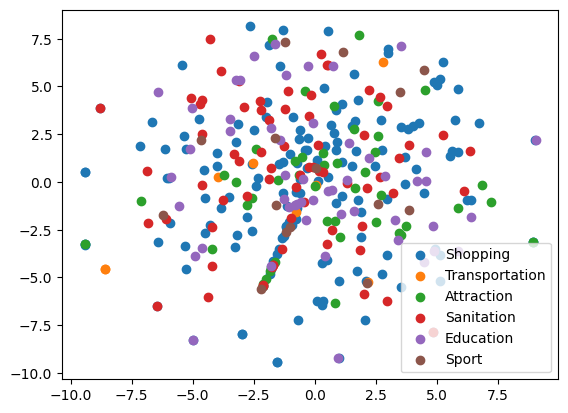

In [28]:
h = 14
type2idx, idx = {}, 0
X, Y = [], []
for k, v in area_flow_hour_graph[h].items():
    if len(v) == 0:
        continue
    y = area_type[k + 1]
    if y not in type2idx:
        type2idx[y] = idx
        idx += 1
    X.append(str(k))
    Y.append(y)

with open(embedding_path, 'rb') as f:
    embeddings = pickle.load(f)

plot_embeddings(X, Y, embeddings)

# Regression model

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import ngboost as ngb
import datetime
import optuna
import time
import copy
import warnings
import pendulum
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

type2eng = {
        '旅游景点;公园': 'Attraction;Park',
        '旅游景点;植物园': 'Attraction;Arboretum',
        '旅游景点;游乐园': 'Attraction;Amusement',
        '旅游景点;水族馆': 'Attraction;Aquarium',
        '旅游景点;动物园': 'Attraction;Zoo',
        '旅游景点;文物古迹': 'Attraction;Monument',
        '旅游景点;风景区': 'Attraction;ScenicSpot',
        '教育培训;高等院校': 'Education;School',
        '购物;购物中心': 'Shopping;Mall',
        '医疗;综合医院': 'Sanitation;Hospital',
        '运动健身;体育场馆': 'Sport;Stadium',
        '交通设施;火车站': 'Transportation;Train',
        '交通设施;长途汽车站': 'Transportation;Bus',
        '交通设施;飞机场': 'Transportation;Airport'
    }

/opt/anaconda3/envs/ccfp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载区域节点特征数据集
area_info = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_info.csv',
    header=None,
    encoding='GBK',
    engine='python',
    names=[
        'ID', 'area_name', 'area_type', 'center_x', 'center_y', 'Grid_x',
        'Grid_y', 'area'
    ])

# 加载人流量特征数据集
area_index = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_index.csv',
    header=None,
    encoding='GBK',
    engine='python',
    names=['ID', 'date', 'people_index'])

# 加载区域联系强度数据集
area_od = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/datafountain_competition_od.txt',
    sep='\t',
    header=None,
    names=[
        'hour', 'start_grid_x', 'start_grid_y', 'end_grid_x', 'end_grid_y',
        'strength'
    ])

# 加载迁徙指数数据集
area_migrate = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/migration_index.csv',
    header=None,
    encoding='utf-8',
    engine='python',
    names=[
        'date', 'departure_province', 'departure_city', 'arrival_province',
        'arrival_city', 'index'
    ])

# 加载外部特征数据集
df_Covid19 = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/COVID_19.csv',
    encoding='utf-8')

df_weather = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/weather.csv',
    encoding='gbk')

# 加载测试结果样本数据集
data_test = pd.read_csv(
    r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/test_submit_example.csv',
    header=None,
    names=['ID', 'date', 'people_index'])

In [3]:
WEATHER_ORDER = [
    '晴', '雾', '霾', '多云', '阴', '阵雨', '雷阵雨', '小雨', '中雨', '大雨', '暴雨', '小雪', '雨夹雪',
    '中雪', '暴雪'
]

def preprocess_data(df_weather, df_Covid19):
    def weather_parser(weather, type='best'):
        indices = [WEATHER_ORDER.index(i) for i in weather.split('~')]
        if type == 'best':
            return WEATHER_ORDER[min(indices)]
        elif type == 'worst':
            return WEATHER_ORDER[max(indices)]

    def weather_numerical(weather):
        if weather in ['暴雪']:
            return 4
        elif weather in ['中雪']:
            return 3
        elif weather in ['大雨', '雨夹雪', '小雪']:
            return 2
        elif weather in ['小雨', '雾', '霾']:
            return 1
        else:
            return 0

    def air_numerical(air):
        if air in ['重度']:
            return 3
        elif air in ['中度']:
            return 2
        elif air in ['轻度']:
            return 1
        else:
            return 0

    def weather_preprocess(weather):
        weather['wind'] = weather['wind'].apply(lambda x: x.split('风', 1)[1])
        weather['air'] = weather['air'].apply(lambda x: x.split(' ')[-1])
        weather['Temp'] = weather['temp_min'].apply(lambda x: 1 if x < 0 else 0)
        weather['date'] = weather['date'].apply(lambda x: x.split(' ')[0])
        weather['date'] = pd.to_datetime(weather['date'])
        w = weather['date'].dt.weekday
        weekday = w + 1
        weather['weekday'] = pd.DataFrame(weekday)
        weather['day'] = range(weather.shape[0])
        weather['weekend'] = weather['weekday'].apply(lambda x: 1 if x > 5 else 0)
        weather['weather_best'] = weather['weather'].apply(lambda x: weather_parser(x, 'best'))
        weather['weather_worst'] = weather['weather'].apply(lambda x: weather_parser(x, 'worst'))
        weather['wind'] = weather['wind'].apply(lambda x: x.split('级', 1)[0])
        weather['weather'] = weather['weather_worst'].apply(lambda x: weather_numerical(x))
        weather['Air'] = weather['air'].apply(lambda x: air_numerical(x))
        return weather

    df_weather = weather_preprocess(df_weather)

    df_weather = df_weather.drop(
        ['weather', 'air', 'Temp', 'weather_best', 'weather_worst'], axis=1)

    df_Covid19['date'] = pd.to_datetime(df_Covid19['date'], format='%Y/%m/%d')

    merged_df = pd.merge(df_weather, df_Covid19, on='date', how='inner')

#     merged_df = merged_df[(merged_df['date'] >= '2020-01-24') & (merged_df['date'] <= '2020-02-15')]

    df_external = merged_df.drop([
        'curedIncr', 'currentConfirmedCount', 'deadIncr', 'suspectedCount', 'currentConfirmedIncr',
        'suspectedCountIncr', 'City'
    ], axis=1)

    return df_external


In [4]:
df_external = preprocess_data(df_weather, df_Covid19)
df_external

date  temp_max  temp_min wind  weekday  day  weekend  Air  \
0  2020-01-20         6        -7    2        1    3        0    0   
1  2020-01-21         4        -6    1        2    4        0    0   
2  2020-01-22         6        -5    1        3    5        0    0   
3  2020-01-23         8        -6    2        4    6        0    0   
4  2020-01-24         4        -6    1        5    7        0    0   
5  2020-01-25         5        -5    1        6    8        1    2   
6  2020-01-26         3        -4    1        7    9        1    2   
7  2020-01-27         5        -4    1        1   10        0    3   
8  2020-01-28         5        -4    1        2   11        0    3   
9  2020-01-29         8        -6    1        3   12        0    1   
10 2020-01-30         6        -6    1        4   13        0    0   
11 2020-01-31         8        -5    2        5   14        0    0   
12 2020-02-01         4        -3    2        6   15        1    0   
13 2020-02-02         3        -7    2        7   16        1    0   
14 2020-02-03         3        -6    2        1   17        0    0   
15 2020-02-04         2        -8    2        2   18        0    0   
16 2020-02-05        -3        -6    2        3   19        0    0   
17 2020-02-06        -3        -9    1        4   20        0    0   
18 2020-02-07         1        -7    1        5   21        0    0   
19 2020-02-08         7        -7    1        6   22        1    0   
20 2020-02-09         6        -5    1        7   23        1    2   
21 2020-02-10        12        -5    1        1   24        0    2   
22 2020-02-11        10        -2    1        2   25        0    3   
23 2020-02-12        11        -2    1        3   26        0    3   
24 2020-02-13         8         0    2        4   27        0    3   
25 2020-02-14         0        -6    2        5   28        0    0   
26 2020-02-15         0        -4    4        6   29        1    0   
27 2020-02-16         3        -5    3        7   30        1    0   
28 2020-02-17         6        -5    2        1   31        0    0   
29 2020-02-18        10        -4    1        2   32        0    0   
30 2020-02-19         8        -4    2        3   33        0    0   
31 2020-02-20         4        -3    1        4   34        0    1   
32 2020-02-21         9        -2    2        5   35        0    1   
33 2020-02-22         9        -3    3        6   36        1    0   
34 2020-02-23        10         0    1        7   37        1    0   
35 2020-02-24         9         3    2        1   38        0    0   

    confirmedCount  confirmedIncr  curedCount  deadCount  
0                5              5           0          0  
1               10              5           0          0  
2               14              4           0          0  
3               26             12           0          0  
4               36             10           0          0  
5               51             15           2          0  
6               68             17           2          0  
7               80             12           2          1  
8              102             22           4          1  
9              114             12           4          1  
10             132             18           5          1  
11             156             24           5          1  
12             183             27           9          1  
13             212             29          12          1  
14             228             16          23          1  
15             253             25          24          1  
16             274             21          31          1  
17             297             23          33          1  
18             315             18          34          2  
19             326             11          37          2  
20             337             11          44          2  
21             342              5          48          3  
22             352             10          56          3  
23

* Variable index interpretation:
* 1. date: date
* 2. temp_max: Maximum temperature of the day
* 3. temp_min: Minimum temperature of the day
* 4. wind: Wind code of the day
* 5. Air: Air index code of the day
* 6. confirmedCount: the number of all confirmed cases
* 7. confirmedIncr: the number of new confirmed cases per day
* 8. deadCount: the number of deaths
* 9. curedCount: the number of cures

In [5]:
# df_external.to_csv(
#     '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/external_df.csv',
#     encoding='utf-8')

In [6]:
def convert_area_type(area_info):
    type2eng = {
        '旅游景点;公园': 'Attraction;Park',
        '旅游景点;植物园': 'Attraction;Arboretum',
        '旅游景点;游乐园': 'Attraction;Amusement',
        '旅游景点;水族馆': 'Attraction;Aquarium',
        '旅游景点;动物园': 'Attraction;Zoo',
        '旅游景点;文物古迹': 'Attraction;Monument',
        '旅游景点;风景区': 'Attraction;ScenicSpot',
        '教育培训;高等院校': 'Education;School',
        '购物;购物中心': 'Shopping;Mall',
        '医疗;综合医院': 'Sanitation;Hospital',
        '运动健身;体育场馆': 'Sport;Stadium',
        '交通设施;火车站': 'Transportation;Train',
        '交通设施;长途汽车站': 'Transportation;Bus',
        '交通设施;飞机场': 'Transportation;Airport'
    }
    area_info = pd.read_csv(
        r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_info.csv',
        header=None,
        encoding='GBK',
        engine='python',
        names=[
            'ID', 'area_name', 'area_type', 'center_x', 'center_y', 'Grid_x',
            'Grid_y', 'area'
        ])
    area_info['area_type'] = area_info['area_type'].map(type2eng)
    return area_info  # Return the modified DataFrame


def preprocess_feature(area_index, area_migrate):
    # Preprocess area index
    area_index['date'] = pd.to_datetime(area_index['date'], format='%Y%m%d%H')
    area_index['day'] = area_index['date'].dt.day.apply(lambda x: x - 17 if x >= 17 else x + 14)
    area_index['weekday'] = area_index['date'].dt.weekday
    area_index['hour'] = area_index['date'].dt.hour
    area_index['people_index_1'] = area_index['people_index'].shift()

    # Preprocess area migrate
    area_migrate['date'] = pd.to_datetime(area_migrate['date'], format='%Y%m%d')
    area_migrate['day_encode'] = area_migrate['date'].dt.day.apply(lambda x: x - 17 if x >= 17 else x + 14)
    area_migrate['city'] = (area_migrate['arrival_city'] == '北京市').astype(int)

    inbj = area_migrate[area_migrate['city'] == 1]
    outbj = area_migrate[area_migrate['city'] == 0]

    index_mean_in = inbj.groupby(['date']).mean()['index']  # Mean of migration index for inbj
    index_std_in = inbj.groupby(['date']).std()['index']  # Standard deviation of migration index for inbj
    dict1 = dict(enumerate(index_mean_in))  # Create a dictionary based on index_mean_in
    dict2 = dict(enumerate(index_std_in))   # Create a dictionary based on index_std_in

    index_mean_out = outbj.groupby(['date']).mean()['index']  # Mean of migration index for outbj
    index_std_out = outbj.groupby(['date']).std()['index']  # Standard deviation of migration index for outbj
    dict3 = dict(enumerate(index_mean_out))  # Create a dictionary based on index_mean_out
    dict4 = dict(enumerate(index_std_out))   # Create a dictionary based on index_std_out

    area_index['index_mean_in'] = area_index['day'].map(dict1)
    area_index['index_std_in'] = area_index['day'].map(dict2)
    area_index['index_mean_out'] = area_index['day'].map(dict3) * -1
    area_index['index_std_out'] = area_index['day'].map(dict4) * -1

    return area_index

In [7]:
area_info = convert_area_type(area_info)
area_index = preprocess_feature(area_index, area_migrate)

In [8]:
def Feature_extraction(flow_data_in,
                       split_day,
                       area_embed=[],
                       weekday=False,
                       model='XGBoost'):

    flow_data_in = pd.merge(flow_data_in, df_external, on='day')
    flow_data_in = pd.merge(flow_data_in,
                            area_info[['ID', 'area', 'area_type']],
                            on='ID')

    # Graph Embedding feature
    if len(area_embed) != 0:
        flow_data_in = pd.merge(flow_data_in, area_embed, on='ID')

    # External:   
    flow_data_in['wind'] = flow_data_in['wind'].astype(int)
    
    # Temporal:
    ## If only weekday or not
    if weekday:
        flow_data_in = flow_data_in[flow_data_in['weekend'] == 0]
        if split_day >= 30 and model == 'XGBoost':
            flow_data_in = flow_data_in[flow_data_in['day'] != 28]

    ## Closeness: flow index of the previous hour
    flow_data_in['closeness'] = area_index['people_index_1']

    ## Period: flow index of the same hour the day before
    flow_data_in[
        'period'] = [0] * 1 + flow_data_in['people_index'][:-1].tolist()

    ## Trend: flow index of the same hour the week before
    flow_data_in['trend'] = [0] * 7 + flow_data_in['people_index'][:-7].tolist(
    )

    flow_data_in[
        'flow_1d'] = [0] * 1 + flow_data_in['people_index'][:-1].tolist()
    flow_data_in[
        'flow_2d'] = [0] * 2 + flow_data_in['people_index'][:-2].tolist()
    flow_data_in[
        'flow_3d'] = [0] * 3 + flow_data_in['people_index'][:-3].tolist()
    flow_data_in[
        'flow_4d'] = [0] * 4 + flow_data_in['people_index'][:-4].tolist()
    flow_data_in[
        'flow_5d'] = [0] * 5 + flow_data_in['people_index'][:-5].tolist()
    flow_data_in[
        'flow_6d'] = [0] * 6 + flow_data_in['people_index'][:-6].tolist()

    flow_data_in['flow_3d_mean'] = flow_data_in[[
        'flow_1d', 'flow_2d', 'flow_3d'
    ]].mean(axis=1)
    
    # Migration:
    flow_data_in['index_mean_in'] = area_index['index_mean_in']
    flow_data_in['index_std_in'] = area_index['index_std_in']
    flow_data_in['index_mean_out'] = area_index['index_mean_out']
    flow_data_in['index_std_out'] = area_index['index_std_out']

    # Type & ID encode
    dict_type = dict(flow_data_in[flow_data_in['day'] < split_day].groupby(
        ['area_type']).mean()['people_index'])
    dict_id = dict(flow_data_in[flow_data_in['day'] < split_day].groupby(
        ['ID']).mean()['people_index'])
    flow_data_in['area_type'] = flow_data_in['area_type'].map(dict_type)
    flow_data_in['ID'] = flow_data_in['ID'].map(dict_id)

    flow_data_out = flow_data_in[flow_data_in['day'] > 8]
    flow_data_out.drop(['weekday', 'temp_max'], axis=1, inplace=True)

    return flow_data_out

## Model building

In [9]:
def preprocess_train_data(area_index):
    # 计算均值
    flow_data = area_index.groupby(['ID', 'day']).agg(['mean'])['people_index'].reset_index()
    flow_data = flow_data.rename(columns={'mean': 'people_index'})

    # 特征提取
    flow_data = Feature_extraction(flow_data, 23)

    # 计算数据集的总大小
    total_size = len(flow_data)

    # 计算划分的大小
    train_size = int(0.8 * total_size)
    validation_size = int(0.1 * total_size)
    test_size = total_size - train_size - validation_size

    # 划分数据集
    x_train = flow_data.iloc[:train_size].drop(columns='people_index')
    y_train = flow_data.iloc[:train_size]['people_index']

    x_valid = flow_data.iloc[train_size:train_size+validation_size].drop(columns='people_index')
    y_valid = flow_data.iloc[train_size:train_size+validation_size]['people_index']

    x_test = flow_data.iloc[train_size+validation_size:].drop(columns='people_index')
    y_test = flow_data.iloc[train_size+validation_size:]['people_index']

    # 打印各个数据集的大小
    print("训练集大小:", len(x_train))
    print("验证集大小:", len(x_valid))
    print("测试集大小:", len(x_test))

    # 去除不需要的列
    columns_to_drop = ['date', 'flow_1d', 'flow_2d', 'flow_3d', 'flow_4d', 'flow_5d', 'flow_6d', 'ID', 'day','area']
    x_train = x_train.drop(columns_to_drop, axis=1)
    x_valid = x_valid.drop(columns_to_drop, axis=1)
    x_test = x_test.drop(columns_to_drop, axis=1)

    return x_train, y_train, x_valid, y_valid, x_test, y_test


In [10]:
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_train_data(area_index)

训练集大小: 16749
验证集大小: 2093
测试集大小: 2095


In [11]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Define a function for training and evaluating models
def train_and_evaluate_model(model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=10)
    y_pred = model.predict(x_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
    return rmse, mae, mape

# Load and split your data into x_train, y_train, x_valid, y_valid

# XGBoost hyperparameter grid
xgb_params = {
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}

# LightGBM hyperparameter grid
lgb_params = {
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}

# CatBoost hyperparameter grid
catboost_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'iterations': [100, 200, 300, 400],
}

# Define a function for grid search and model selection
def grid_search_and_select_model(model, param_grid, x_train, y_train, x_valid, y_valid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    rmse, mae, mape = train_and_evaluate_model(best_model, x_train, y_train, x_valid, y_valid)
    return best_model, rmse, mae, mape

# Train and evaluate XGBoost
best_xgb_model, xgb_rmse, xgb_mae, xgb_mape = grid_search_and_select_model(xgb.XGBRegressor(), xgb_params, x_train, y_train, x_valid, y_valid)

# Train and evaluate LightGBM
best_lgb_model, lgb_rmse, lgb_mae, lgb_mape = grid_search_and_select_model(lgb.LGBMRegressor(), lgb_params, x_train, y_train, x_valid, y_valid)

# Train and evaluate CatBoost
best_cb_model, cb_rmse, cb_mae, cb_mape = grid_search_and_select_model(CatBoostRegressor(), catboost_params, x_train, y_train, x_valid, y_valid)

# Print the results
print("XGBoost Evaluation Metrics and Best Hyperparameters:")
print(best_xgb_model.get_params())
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"MAPE: {xgb_mape:.4f}%")

print("LightGBM Evaluation Metrics and Best Hyperparameters:")
print(best_lgb_model.get_params())
print(f"RMSE: {lgb_rmse:.4f}")
print(f"MAE: {lgb_mae:.4f}")
print(f"MAPE: {lgb_mape:.4f}%")

print("CatBoost Evaluation Metrics and Best Hyperparameters:")
print(best_cb_model.get_params())
print(f"RMSE: {cb_rmse:.4f}")
print(f"MAE: {cb_mae:.4f}")
print(f"MAPE: {cb_mape:.4f}%")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[0]	validation_0-rmse:55.78637	validation_1-rmse:20.26698
[10]	validation_0-rmse:21.97743	validation_1-rmse:8.36062
[20]	validation_0-rmse:9.39723	validation_1-rmse:4.14753
[30]	validation_0-rmse:4.99750	validation_1-rmse:2.89877
[40]	validation_0-rmse:3.65894	validation_1-rmse:2.60681
[50]	validation_0-rmse:3.26278	validation_1-rmse:2.54059
[60]	validation_0-rmse:3.10792	validation_1-rmse:2.49644
[70]	validation_0-rmse:3.02061	validation_1-rmse:2.45667
[80]	validation_0-rmse:2.93803	validation_1-rmse:2.42637
[90]	validation_0-rmse:2.85797	validation_1-rmse:2.39430
[100]	validation_0-rmse:2.76783	validation_1-rmse:2.34328
[110]	validation_0-rmse:2.69369	validation_1-rmse:2.31486
[120]	validation_0-rmse:2.62124	validation_1-rmse:2.28990
[130]	validation_0-rmse:2.54313	validation_1-rmse:2.26037
[140]	validation_0-rmse:2.47843	validation_1-rmse:2.23896
[150]	validation_0-rmse:2.43298	validation_1-rmse:2.23689
[160]	validation_0

14:	learn: 33.6947515	total: 37.4ms	remaining: 461ms
15:	learn: 33.4047696	total: 38.9ms	remaining: 447ms
16:	learn: 33.1100216	total: 41.2ms	remaining: 444ms
17:	learn: 32.8381310	total: 43.8ms	remaining: 442ms
18:	learn: 32.5556296	total: 46.3ms	remaining: 441ms
19:	learn: 32.2709882	total: 49ms	remaining: 441ms
20:	learn: 31.9877051	total: 53.3ms	remaining: 455ms
21:	learn: 31.7094742	total: 55.4ms	remaining: 449ms
22:	learn: 31.4265051	total: 56.8ms	remaining: 437ms
23:	learn: 31.1458823	total: 58.3ms	remaining: 427ms
24:	learn: 30.8695751	total: 60.6ms	remaining: 424ms
25:	learn: 30.5945706	total: 63ms	remaining: 422ms
26:	learn: 30.3240063	total: 67.4ms	remaining: 432ms
27:	learn: 30.0555387	total: 69.4ms	remaining: 427ms
28:	learn: 29.7896195	total: 71ms	remaining: 418ms
29:	learn: 29.5291821	total: 72.2ms	remaining: 409ms
30:	learn: 29.2686014	total: 76ms	remaining: 414ms
31:	learn: 29.0085647	total: 78ms	remaining: 409ms
32:	learn: 28.7798401	total: 80.1ms	remaining: 406ms
33:

127:	learn: 2.9463563	total: 282ms	remaining: 159ms
128:	learn: 2.9319201	total: 286ms	remaining: 157ms
129:	learn: 2.9228820	total: 287ms	remaining: 155ms
130:	learn: 2.9078142	total: 289ms	remaining: 152ms
131:	learn: 2.9001477	total: 290ms	remaining: 149ms
132:	learn: 2.8944923	total: 292ms	remaining: 147ms
133:	learn: 2.8887203	total: 293ms	remaining: 144ms
134:	learn: 2.8837014	total: 296ms	remaining: 142ms
135:	learn: 2.8740044	total: 298ms	remaining: 140ms
136:	learn: 2.8701908	total: 301ms	remaining: 138ms
137:	learn: 2.8673057	total: 305ms	remaining: 137ms
138:	learn: 2.8599374	total: 307ms	remaining: 135ms
139:	learn: 2.8514459	total: 311ms	remaining: 133ms
140:	learn: 2.8464871	total: 313ms	remaining: 131ms
141:	learn: 2.8423603	total: 314ms	remaining: 128ms
142:	learn: 2.8280437	total: 316ms	remaining: 126ms
143:	learn: 2.8104435	total: 319ms	remaining: 124ms
144:	learn: 2.8043197	total: 322ms	remaining: 122ms
145:	learn: 2.7953338	total: 325ms	remaining: 120ms
146:	learn: 

237:	learn: 10.9474491	total: 549ms	remaining: 143ms
238:	learn: 10.8937655	total: 553ms	remaining: 141ms
239:	learn: 10.8339219	total: 555ms	remaining: 139ms
240:	learn: 10.7780368	total: 557ms	remaining: 136ms
241:	learn: 10.7175521	total: 559ms	remaining: 134ms
242:	learn: 10.6604386	total: 561ms	remaining: 131ms
243:	learn: 10.6052351	total: 562ms	remaining: 129ms
244:	learn: 10.5488176	total: 565ms	remaining: 127ms
245:	learn: 10.4946156	total: 567ms	remaining: 124ms
246:	learn: 10.4339029	total: 569ms	remaining: 122ms
247:	learn: 10.3757139	total: 573ms	remaining: 120ms
248:	learn: 10.3187245	total: 576ms	remaining: 118ms
249:	learn: 10.2658473	total: 581ms	remaining: 116ms
250:	learn: 10.2123231	total: 582ms	remaining: 114ms
251:	learn: 10.1557618	total: 585ms	remaining: 111ms
252:	learn: 10.0968575	total: 587ms	remaining: 109ms
253:	learn: 10.0463449	total: 590ms	remaining: 107ms
254:	learn: 9.9967250	total: 595ms	remaining: 105ms
255:	learn: 9.9450833	total: 597ms	remaining: 1

251:	learn: 2.9330853	total: 617ms	remaining: 118ms
252:	learn: 2.9315916	total: 623ms	remaining: 116ms
253:	learn: 2.9276676	total: 626ms	remaining: 113ms
254:	learn: 2.9246595	total: 629ms	remaining: 111ms
255:	learn: 2.9219328	total: 631ms	remaining: 108ms
256:	learn: 2.9174544	total: 633ms	remaining: 106ms
257:	learn: 2.9138046	total: 634ms	remaining: 103ms
258:	learn: 2.9111965	total: 636ms	remaining: 101ms
259:	learn: 2.9100618	total: 638ms	remaining: 98.1ms
260:	learn: 2.9002355	total: 641ms	remaining: 95.7ms
261:	learn: 2.8970638	total: 643ms	remaining: 93.2ms
262:	learn: 2.8931051	total: 647ms	remaining: 91ms
263:	learn: 2.8894600	total: 649ms	remaining: 88.5ms
264:	learn: 2.8860033	total: 651ms	remaining: 86ms
265:	learn: 2.8819091	total: 652ms	remaining: 83.4ms
266:	learn: 2.8773115	total: 655ms	remaining: 81ms
267:	learn: 2.8714748	total: 658ms	remaining: 78.6ms
268:	learn: 2.8692567	total: 662ms	remaining: 76.3ms
269:	learn: 2.8663106	total: 665ms	remaining: 73.8ms
270:	le

266:	learn: 1.9992429	total: 621ms	remaining: 76.7ms
267:	learn: 1.9943561	total: 622ms	remaining: 74.3ms
268:	learn: 1.9930501	total: 624ms	remaining: 71.9ms
269:	learn: 1.9901547	total: 625ms	remaining: 69.5ms
270:	learn: 1.9837051	total: 627ms	remaining: 67.1ms
271:	learn: 1.9822845	total: 633ms	remaining: 65.1ms
272:	learn: 1.9791592	total: 634ms	remaining: 62.8ms
273:	learn: 1.9759306	total: 636ms	remaining: 60.3ms
274:	learn: 1.9749714	total: 638ms	remaining: 58ms
275:	learn: 1.9729914	total: 642ms	remaining: 55.8ms
276:	learn: 1.9700513	total: 645ms	remaining: 53.5ms
277:	learn: 1.9673479	total: 646ms	remaining: 51.1ms
278:	learn: 1.9667196	total: 648ms	remaining: 48.8ms
279:	learn: 1.9646757	total: 650ms	remaining: 46.4ms
280:	learn: 1.9604411	total: 651ms	remaining: 44ms
281:	learn: 1.9563159	total: 653ms	remaining: 41.7ms
282:	learn: 1.9508212	total: 655ms	remaining: 39.4ms
283:	learn: 1.9475122	total: 657ms	remaining: 37ms
284:	learn: 1.9438724	total: 659ms	remaining: 34.7ms

271:	learn: 1.6878168	total: 631ms	remaining: 64.9ms
272:	learn: 1.6860946	total: 633ms	remaining: 62.6ms
273:	learn: 1.6850163	total: 636ms	remaining: 60.3ms
274:	learn: 1.6823242	total: 639ms	remaining: 58.1ms
275:	learn: 1.6812902	total: 641ms	remaining: 55.8ms
276:	learn: 1.6800696	total: 643ms	remaining: 53.4ms
277:	learn: 1.6769486	total: 646ms	remaining: 51.2ms
278:	learn: 1.6753602	total: 648ms	remaining: 48.8ms
279:	learn: 1.6737464	total: 649ms	remaining: 46.4ms
280:	learn: 1.6724503	total: 651ms	remaining: 44ms
281:	learn: 1.6715917	total: 652ms	remaining: 41.6ms
282:	learn: 1.6693533	total: 656ms	remaining: 39.4ms
283:	learn: 1.6687677	total: 658ms	remaining: 37.1ms
284:	learn: 1.6662862	total: 659ms	remaining: 34.7ms
285:	learn: 1.6644663	total: 663ms	remaining: 32.5ms
286:	learn: 1.6634836	total: 665ms	remaining: 30.1ms
287:	learn: 1.6600877	total: 667ms	remaining: 27.8ms
288:	learn: 1.6577863	total: 669ms	remaining: 25.5ms
289:	learn: 1.6561180	total: 673ms	remaining: 23

278:	learn: 5.3995789	total: 657ms	remaining: 285ms
279:	learn: 5.3816979	total: 660ms	remaining: 283ms
280:	learn: 5.3637297	total: 662ms	remaining: 280ms
281:	learn: 5.3449324	total: 664ms	remaining: 278ms
282:	learn: 5.3255057	total: 668ms	remaining: 276ms
283:	learn: 5.3079897	total: 670ms	remaining: 274ms
284:	learn: 5.2900079	total: 673ms	remaining: 271ms
285:	learn: 5.2720013	total: 675ms	remaining: 269ms
286:	learn: 5.2542395	total: 678ms	remaining: 267ms
287:	learn: 5.2378118	total: 680ms	remaining: 264ms
288:	learn: 5.2214445	total: 681ms	remaining: 262ms
289:	learn: 5.2046035	total: 685ms	remaining: 260ms
290:	learn: 5.1894828	total: 688ms	remaining: 258ms
291:	learn: 5.1731743	total: 689ms	remaining: 255ms
292:	learn: 5.1571201	total: 691ms	remaining: 252ms
293:	learn: 5.1418342	total: 692ms	remaining: 250ms
294:	learn: 5.1263600	total: 697ms	remaining: 248ms
295:	learn: 5.1109204	total: 699ms	remaining: 246ms
296:	learn: 5.0959524	total: 701ms	remaining: 243ms
297:	learn: 

286:	learn: 2.7331355	total: 711ms	remaining: 280ms
287:	learn: 2.7319873	total: 714ms	remaining: 278ms
288:	learn: 2.7278533	total: 717ms	remaining: 275ms
289:	learn: 2.7245527	total: 718ms	remaining: 272ms
290:	learn: 2.7233738	total: 720ms	remaining: 270ms
291:	learn: 2.7221212	total: 723ms	remaining: 268ms
292:	learn: 2.7210766	total: 726ms	remaining: 265ms
293:	learn: 2.7183340	total: 728ms	remaining: 262ms
294:	learn: 2.7143820	total: 730ms	remaining: 260ms
295:	learn: 2.7121153	total: 733ms	remaining: 257ms
296:	learn: 2.7103001	total: 735ms	remaining: 255ms
297:	learn: 2.7066123	total: 737ms	remaining: 252ms
298:	learn: 2.7042671	total: 738ms	remaining: 249ms
299:	learn: 2.7031427	total: 740ms	remaining: 247ms
300:	learn: 2.7022152	total: 741ms	remaining: 244ms
301:	learn: 2.6945945	total: 743ms	remaining: 241ms
302:	learn: 2.6918857	total: 747ms	remaining: 239ms
303:	learn: 2.6893297	total: 748ms	remaining: 236ms
304:	learn: 2.6881453	total: 749ms	remaining: 233ms
305:	learn: 

393:	learn: 2.5031415	total: 958ms	remaining: 14.6ms
394:	learn: 2.5012318	total: 960ms	remaining: 12.2ms
395:	learn: 2.4985736	total: 962ms	remaining: 9.71ms
396:	learn: 2.4964567	total: 963ms	remaining: 7.28ms
397:	learn: 2.4928523	total: 964ms	remaining: 4.85ms
398:	learn: 2.4908727	total: 967ms	remaining: 2.42ms
399:	learn: 2.4871786	total: 968ms	remaining: 0us
0:	learn: 48.5401190	total: 1.6ms	remaining: 641ms
1:	learn: 36.6832760	total: 2.88ms	remaining: 574ms
2:	learn: 28.1870016	total: 4.27ms	remaining: 565ms
3:	learn: 22.3254871	total: 5.67ms	remaining: 562ms
4:	learn: 18.0599011	total: 7.05ms	remaining: 557ms
5:	learn: 14.3260106	total: 8.5ms	remaining: 558ms
6:	learn: 11.8696475	total: 10.1ms	remaining: 565ms
7:	learn: 10.2740216	total: 11.8ms	remaining: 577ms
8:	learn: 9.0093621	total: 14.5ms	remaining: 632ms
9:	learn: 8.1679389	total: 17.1ms	remaining: 668ms
10:	learn: 7.6200923	total: 18.7ms	remaining: 662ms
11:	learn: 7.1255679	total: 20.1ms	remaining: 651ms
12:	learn: 6

200:	learn: 2.5398079	total: 476ms	remaining: 471ms
201:	learn: 2.5364803	total: 478ms	remaining: 468ms
202:	learn: 2.5317847	total: 481ms	remaining: 467ms
203:	learn: 2.5254703	total: 483ms	remaining: 464ms
204:	learn: 2.5216522	total: 485ms	remaining: 462ms
205:	learn: 2.5193076	total: 487ms	remaining: 458ms
206:	learn: 2.5154764	total: 488ms	remaining: 455ms
207:	learn: 2.5107063	total: 490ms	remaining: 452ms
208:	learn: 2.5046986	total: 491ms	remaining: 449ms
209:	learn: 2.5012471	total: 493ms	remaining: 446ms
210:	learn: 2.4999088	total: 494ms	remaining: 443ms
211:	learn: 2.4973165	total: 496ms	remaining: 440ms
212:	learn: 2.4923796	total: 502ms	remaining: 441ms
213:	learn: 2.4835788	total: 504ms	remaining: 438ms
214:	learn: 2.4815692	total: 506ms	remaining: 436ms
215:	learn: 2.4685467	total: 512ms	remaining: 436ms
216:	learn: 2.4629607	total: 515ms	remaining: 435ms
217:	learn: 2.4535991	total: 518ms	remaining: 433ms
218:	learn: 2.4505262	total: 520ms	remaining: 430ms
219:	learn: 

308:	learn: 1.8857057	total: 751ms	remaining: 221ms
309:	learn: 1.8847915	total: 753ms	remaining: 219ms
310:	learn: 1.8820306	total: 755ms	remaining: 216ms
311:	learn: 1.8801504	total: 758ms	remaining: 214ms
312:	learn: 1.8789109	total: 760ms	remaining: 211ms
313:	learn: 1.8773789	total: 761ms	remaining: 209ms
314:	learn: 1.8739321	total: 764ms	remaining: 206ms
315:	learn: 1.8703172	total: 767ms	remaining: 204ms
316:	learn: 1.8684087	total: 770ms	remaining: 202ms
317:	learn: 1.8668615	total: 773ms	remaining: 199ms
318:	learn: 1.8644685	total: 774ms	remaining: 197ms
319:	learn: 1.8620701	total: 776ms	remaining: 194ms
320:	learn: 1.8613943	total: 777ms	remaining: 191ms
321:	learn: 1.8566217	total: 781ms	remaining: 189ms
322:	learn: 1.8524331	total: 784ms	remaining: 187ms
323:	learn: 1.8506167	total: 785ms	remaining: 184ms
324:	learn: 1.8488580	total: 790ms	remaining: 182ms
325:	learn: 1.8482462	total: 792ms	remaining: 180ms
326:	learn: 1.8456388	total: 793ms	remaining: 177ms
327:	learn: 

13:	learn: 19.4147227	total: 48.7ms	remaining: 299ms
14:	learn: 18.0199542	total: 51ms	remaining: 289ms
15:	learn: 16.7166368	total: 53.4ms	remaining: 280ms
16:	learn: 15.7385926	total: 55.8ms	remaining: 273ms
17:	learn: 14.6687292	total: 58.4ms	remaining: 266ms
18:	learn: 13.7233307	total: 61.9ms	remaining: 264ms
19:	learn: 12.8279364	total: 66.2ms	remaining: 265ms
20:	learn: 12.0205126	total: 69ms	remaining: 260ms
21:	learn: 11.2668926	total: 71.4ms	remaining: 253ms
22:	learn: 10.6613151	total: 73.7ms	remaining: 247ms
23:	learn: 10.0613033	total: 76.1ms	remaining: 241ms
24:	learn: 9.4754944	total: 78.7ms	remaining: 236ms
25:	learn: 9.0105008	total: 82.6ms	remaining: 235ms
26:	learn: 8.5481006	total: 86.1ms	remaining: 233ms
27:	learn: 8.1455699	total: 90.3ms	remaining: 232ms
28:	learn: 7.7541841	total: 95ms	remaining: 233ms
29:	learn: 7.3867454	total: 99.5ms	remaining: 232ms
30:	learn: 7.0734264	total: 102ms	remaining: 227ms
31:	learn: 6.7754433	total: 105ms	remaining: 223ms
32:	learn

24:	learn: 30.7846698	total: 93.6ms	remaining: 655ms
25:	learn: 30.5076413	total: 96.3ms	remaining: 645ms
26:	learn: 30.2404766	total: 101ms	remaining: 646ms
27:	learn: 29.9844107	total: 104ms	remaining: 640ms
28:	learn: 29.7164599	total: 110ms	remaining: 647ms
29:	learn: 29.4629614	total: 113ms	remaining: 640ms
30:	learn: 29.2035170	total: 116ms	remaining: 635ms
31:	learn: 28.9445224	total: 119ms	remaining: 627ms
32:	learn: 28.6891152	total: 125ms	remaining: 633ms
33:	learn: 28.4391519	total: 127ms	remaining: 622ms
34:	learn: 28.1910934	total: 130ms	remaining: 612ms
35:	learn: 27.9378850	total: 134ms	remaining: 610ms
36:	learn: 27.7117644	total: 137ms	remaining: 604ms
37:	learn: 27.4753819	total: 140ms	remaining: 598ms
38:	learn: 27.2359723	total: 144ms	remaining: 595ms
39:	learn: 27.0150524	total: 148ms	remaining: 592ms
40:	learn: 26.7853380	total: 154ms	remaining: 598ms
41:	learn: 26.5489975	total: 157ms	remaining: 589ms
42:	learn: 26.3373333	total: 159ms	remaining: 582ms
43:	learn:

128:	learn: 22.8835356	total: 412ms	remaining: 227ms
129:	learn: 22.7128962	total: 416ms	remaining: 224ms
130:	learn: 22.5333270	total: 421ms	remaining: 222ms
131:	learn: 22.3713270	total: 423ms	remaining: 218ms
132:	learn: 22.2200637	total: 425ms	remaining: 214ms
133:	learn: 22.0663886	total: 428ms	remaining: 211ms
134:	learn: 21.9061717	total: 430ms	remaining: 207ms
135:	learn: 21.7441705	total: 432ms	remaining: 204ms
136:	learn: 21.5829994	total: 436ms	remaining: 200ms
137:	learn: 21.4279492	total: 438ms	remaining: 197ms
138:	learn: 21.2664259	total: 444ms	remaining: 195ms
139:	learn: 21.1067181	total: 449ms	remaining: 192ms
140:	learn: 20.9679173	total: 451ms	remaining: 189ms
141:	learn: 20.8167667	total: 454ms	remaining: 186ms
142:	learn: 20.6693458	total: 458ms	remaining: 182ms
143:	learn: 20.5334713	total: 460ms	remaining: 179ms
144:	learn: 20.3825345	total: 462ms	remaining: 175ms
145:	learn: 20.2407036	total: 466ms	remaining: 172ms
146:	learn: 20.1058978	total: 469ms	remaining:

120:	learn: 23.4154044	total: 468ms	remaining: 306ms
121:	learn: 23.2407102	total: 471ms	remaining: 301ms
122:	learn: 23.0731309	total: 473ms	remaining: 296ms
123:	learn: 22.9169600	total: 478ms	remaining: 293ms
124:	learn: 22.7601837	total: 485ms	remaining: 291ms
125:	learn: 22.5937630	total: 492ms	remaining: 289ms
126:	learn: 22.4262992	total: 495ms	remaining: 284ms
127:	learn: 22.2621789	total: 498ms	remaining: 280ms
128:	learn: 22.0956813	total: 501ms	remaining: 276ms
129:	learn: 21.9318914	total: 505ms	remaining: 272ms
130:	learn: 21.7872617	total: 507ms	remaining: 267ms
131:	learn: 21.6280950	total: 510ms	remaining: 263ms
132:	learn: 21.4700345	total: 512ms	remaining: 258ms
133:	learn: 21.3136791	total: 514ms	remaining: 253ms
134:	learn: 21.1618890	total: 516ms	remaining: 249ms
135:	learn: 21.0093787	total: 519ms	remaining: 244ms
136:	learn: 20.8570490	total: 522ms	remaining: 240ms
137:	learn: 20.7147647	total: 525ms	remaining: 236ms
138:	learn: 20.5656241	total: 529ms	remaining:

138:	learn: 2.2571877	total: 529ms	remaining: 232ms
139:	learn: 2.2522652	total: 536ms	remaining: 230ms
140:	learn: 2.2479645	total: 539ms	remaining: 226ms
141:	learn: 2.2350620	total: 542ms	remaining: 221ms
142:	learn: 2.2321285	total: 544ms	remaining: 217ms
143:	learn: 2.2185567	total: 546ms	remaining: 212ms
144:	learn: 2.2108886	total: 548ms	remaining: 208ms
145:	learn: 2.2030433	total: 550ms	remaining: 204ms
146:	learn: 2.2004884	total: 555ms	remaining: 200ms
147:	learn: 2.1939712	total: 559ms	remaining: 196ms
148:	learn: 2.1828742	total: 562ms	remaining: 192ms
149:	learn: 2.1768624	total: 566ms	remaining: 189ms
150:	learn: 2.1729669	total: 570ms	remaining: 185ms
151:	learn: 2.1616102	total: 574ms	remaining: 181ms
152:	learn: 2.1537523	total: 577ms	remaining: 177ms
153:	learn: 2.1466004	total: 580ms	remaining: 173ms
154:	learn: 2.1409960	total: 584ms	remaining: 170ms
155:	learn: 2.1346535	total: 588ms	remaining: 166ms
156:	learn: 2.1302977	total: 592ms	remaining: 162ms
157:	learn: 

42:	learn: 3.3967206	total: 146ms	remaining: 533ms
43:	learn: 3.3681843	total: 149ms	remaining: 528ms
44:	learn: 3.3385732	total: 154ms	remaining: 531ms
45:	learn: 3.3133958	total: 159ms	remaining: 532ms
46:	learn: 3.2958666	total: 161ms	remaining: 525ms
47:	learn: 3.2517289	total: 165ms	remaining: 522ms
48:	learn: 3.2034731	total: 168ms	remaining: 516ms
49:	learn: 3.1895205	total: 171ms	remaining: 512ms
50:	learn: 3.1598764	total: 174ms	remaining: 507ms
51:	learn: 3.1240845	total: 179ms	remaining: 509ms
52:	learn: 3.0737920	total: 182ms	remaining: 505ms
53:	learn: 3.0470874	total: 187ms	remaining: 506ms
54:	learn: 3.0271938	total: 190ms	remaining: 502ms
55:	learn: 2.9972418	total: 192ms	remaining: 495ms
56:	learn: 2.9588345	total: 196ms	remaining: 492ms
57:	learn: 2.9238141	total: 199ms	remaining: 487ms
58:	learn: 2.8986187	total: 203ms	remaining: 485ms
59:	learn: 2.8691684	total: 207ms	remaining: 482ms
60:	learn: 2.8445384	total: 213ms	remaining: 485ms
61:	learn: 2.8258211	total: 218

42:	learn: 2.6713776	total: 167ms	remaining: 610ms
43:	learn: 2.6525771	total: 170ms	remaining: 603ms
44:	learn: 2.6355983	total: 173ms	remaining: 596ms
45:	learn: 2.5987017	total: 176ms	remaining: 589ms
46:	learn: 2.5867224	total: 179ms	remaining: 584ms
47:	learn: 2.5482086	total: 182ms	remaining: 576ms
48:	learn: 2.5335402	total: 187ms	remaining: 577ms
49:	learn: 2.5151902	total: 189ms	remaining: 567ms
50:	learn: 2.4857747	total: 196ms	remaining: 573ms
51:	learn: 2.4772266	total: 203ms	remaining: 577ms
52:	learn: 2.4510261	total: 207ms	remaining: 574ms
53:	learn: 2.4150317	total: 211ms	remaining: 570ms
54:	learn: 2.3976614	total: 217ms	remaining: 573ms
55:	learn: 2.3747789	total: 221ms	remaining: 569ms
56:	learn: 2.3638886	total: 223ms	remaining: 560ms
57:	learn: 2.3546548	total: 226ms	remaining: 553ms
58:	learn: 2.3385897	total: 228ms	remaining: 546ms
59:	learn: 2.3215154	total: 231ms	remaining: 540ms
60:	learn: 2.3091380	total: 234ms	remaining: 533ms
61:	learn: 2.2902907	total: 237

34:	learn: 3.6991337	total: 148ms	remaining: 697ms
35:	learn: 3.6569012	total: 151ms	remaining: 687ms
36:	learn: 3.5689621	total: 154ms	remaining: 678ms
37:	learn: 3.5056065	total: 158ms	remaining: 673ms
38:	learn: 3.4807220	total: 162ms	remaining: 668ms
39:	learn: 3.4306015	total: 167ms	remaining: 667ms
40:	learn: 3.3817635	total: 171ms	remaining: 662ms
41:	learn: 3.3404305	total: 174ms	remaining: 655ms
42:	learn: 3.3181947	total: 179ms	remaining: 655ms
43:	learn: 3.2570884	total: 185ms	remaining: 656ms
44:	learn: 3.2268493	total: 189ms	remaining: 652ms
45:	learn: 3.1970412	total: 193ms	remaining: 645ms
46:	learn: 3.1336000	total: 199ms	remaining: 646ms
47:	learn: 3.1075690	total: 202ms	remaining: 640ms
48:	learn: 3.0629384	total: 206ms	remaining: 636ms
49:	learn: 3.0368199	total: 211ms	remaining: 633ms
50:	learn: 3.0127603	total: 215ms	remaining: 629ms
51:	learn: 2.9867053	total: 219ms	remaining: 623ms
52:	learn: 2.9559901	total: 223ms	remaining: 617ms
53:	learn: 2.9103714	total: 226

249:	learn: 10.0064294	total: 937ms	remaining: 187ms
250:	learn: 9.9497067	total: 939ms	remaining: 183ms
251:	learn: 9.8943130	total: 944ms	remaining: 180ms
252:	learn: 9.8397739	total: 948ms	remaining: 176ms
253:	learn: 9.7816273	total: 951ms	remaining: 172ms
254:	learn: 9.7305189	total: 954ms	remaining: 168ms
255:	learn: 9.6729410	total: 957ms	remaining: 164ms
256:	learn: 9.6204974	total: 959ms	remaining: 160ms
257:	learn: 9.5630298	total: 961ms	remaining: 157ms
258:	learn: 9.5095326	total: 965ms	remaining: 153ms
259:	learn: 9.4527862	total: 968ms	remaining: 149ms
260:	learn: 9.4028985	total: 974ms	remaining: 146ms
261:	learn: 9.3550215	total: 978ms	remaining: 142ms
262:	learn: 9.3043672	total: 984ms	remaining: 138ms
263:	learn: 9.2543702	total: 988ms	remaining: 135ms
264:	learn: 9.2072035	total: 991ms	remaining: 131ms
265:	learn: 9.1525376	total: 996ms	remaining: 127ms
266:	learn: 9.0989868	total: 1s	remaining: 124ms
267:	learn: 9.0533830	total: 1s	remaining: 120ms
268:	learn: 9.001

156:	learn: 10.3057829	total: 539ms	remaining: 491ms
157:	learn: 10.2301279	total: 542ms	remaining: 487ms
158:	learn: 10.1563992	total: 546ms	remaining: 484ms
159:	learn: 10.0795541	total: 549ms	remaining: 480ms
160:	learn: 10.0041874	total: 553ms	remaining: 477ms
161:	learn: 9.9283811	total: 556ms	remaining: 474ms
162:	learn: 9.8565203	total: 560ms	remaining: 470ms
163:	learn: 9.7828784	total: 565ms	remaining: 468ms
164:	learn: 9.7112700	total: 568ms	remaining: 465ms
165:	learn: 9.6429078	total: 572ms	remaining: 462ms
166:	learn: 9.5755117	total: 578ms	remaining: 460ms
167:	learn: 9.5082514	total: 581ms	remaining: 456ms
168:	learn: 9.4414803	total: 584ms	remaining: 453ms
169:	learn: 9.3791559	total: 588ms	remaining: 450ms
170:	learn: 9.3122964	total: 595ms	remaining: 449ms
171:	learn: 9.2465818	total: 597ms	remaining: 444ms
172:	learn: 9.1795223	total: 602ms	remaining: 442ms
173:	learn: 9.1138695	total: 607ms	remaining: 439ms
174:	learn: 9.0498349	total: 610ms	remaining: 436ms
175:	le

158:	learn: 2.7258248	total: 589ms	remaining: 523ms
159:	learn: 2.7178575	total: 592ms	remaining: 518ms
160:	learn: 2.7086874	total: 596ms	remaining: 514ms
161:	learn: 2.6998076	total: 601ms	remaining: 512ms
162:	learn: 2.6950917	total: 604ms	remaining: 507ms
163:	learn: 2.6913410	total: 607ms	remaining: 503ms
164:	learn: 2.6815121	total: 612ms	remaining: 500ms
165:	learn: 2.6738963	total: 616ms	remaining: 497ms
166:	learn: 2.6619797	total: 619ms	remaining: 493ms
167:	learn: 2.6589780	total: 621ms	remaining: 488ms
168:	learn: 2.6471025	total: 623ms	remaining: 483ms
169:	learn: 2.6401178	total: 626ms	remaining: 479ms
170:	learn: 2.6334866	total: 628ms	remaining: 474ms
171:	learn: 2.6290746	total: 631ms	remaining: 469ms
172:	learn: 2.6230601	total: 635ms	remaining: 466ms
173:	learn: 2.6182100	total: 638ms	remaining: 462ms
174:	learn: 2.6097507	total: 645ms	remaining: 461ms
175:	learn: 2.6038737	total: 647ms	remaining: 456ms
176:	learn: 2.5973355	total: 650ms	remaining: 452ms
177:	learn: 

151:	learn: 2.6847139	total: 660ms	remaining: 643ms
152:	learn: 2.6738600	total: 664ms	remaining: 638ms
153:	learn: 2.6600577	total: 670ms	remaining: 635ms
154:	learn: 2.6552633	total: 675ms	remaining: 631ms
155:	learn: 2.6510481	total: 679ms	remaining: 627ms
156:	learn: 2.6420164	total: 688ms	remaining: 627ms
157:	learn: 2.6381146	total: 691ms	remaining: 621ms
158:	learn: 2.6344313	total: 695ms	remaining: 616ms
159:	learn: 2.6263031	total: 699ms	remaining: 612ms
160:	learn: 2.6137099	total: 705ms	remaining: 609ms
161:	learn: 2.6106711	total: 709ms	remaining: 604ms
162:	learn: 2.6049912	total: 712ms	remaining: 599ms
163:	learn: 2.5946551	total: 717ms	remaining: 594ms
164:	learn: 2.5918880	total: 720ms	remaining: 589ms
165:	learn: 2.5891972	total: 725ms	remaining: 585ms
166:	learn: 2.5764456	total: 730ms	remaining: 581ms
167:	learn: 2.5717858	total: 733ms	remaining: 576ms
168:	learn: 2.5672314	total: 737ms	remaining: 571ms
169:	learn: 2.5596648	total: 742ms	remaining: 567ms
170:	learn: 

267:	learn: 1.4693569	total: 953ms	remaining: 114ms
268:	learn: 1.4676066	total: 956ms	remaining: 110ms
269:	learn: 1.4660154	total: 960ms	remaining: 107ms
270:	learn: 1.4640850	total: 963ms	remaining: 103ms
271:	learn: 1.4612208	total: 965ms	remaining: 99.4ms
272:	learn: 1.4584680	total: 968ms	remaining: 95.8ms
273:	learn: 1.4557471	total: 975ms	remaining: 92.5ms
274:	learn: 1.4528221	total: 980ms	remaining: 89.1ms
275:	learn: 1.4495516	total: 984ms	remaining: 85.6ms
276:	learn: 1.4464187	total: 987ms	remaining: 82ms
277:	learn: 1.4438037	total: 991ms	remaining: 78.4ms
278:	learn: 1.4413680	total: 994ms	remaining: 74.9ms
279:	learn: 1.4391026	total: 997ms	remaining: 71.2ms
280:	learn: 1.4376470	total: 1s	remaining: 67.9ms
281:	learn: 1.4343829	total: 1.01s	remaining: 64.3ms
282:	learn: 1.4322957	total: 1.01s	remaining: 60.7ms
283:	learn: 1.4303322	total: 1.02s	remaining: 57.3ms
284:	learn: 1.4289804	total: 1.02s	remaining: 53.7ms
285:	learn: 1.4262347	total: 1.02s	remaining: 50ms
286:

174:	learn: 1.7616336	total: 656ms	remaining: 469ms
175:	learn: 1.7587278	total: 661ms	remaining: 466ms
176:	learn: 1.7572798	total: 665ms	remaining: 462ms
177:	learn: 1.7553841	total: 669ms	remaining: 459ms
178:	learn: 1.7470899	total: 672ms	remaining: 455ms
179:	learn: 1.7369804	total: 677ms	remaining: 451ms
180:	learn: 1.7341434	total: 681ms	remaining: 448ms
181:	learn: 1.7264938	total: 684ms	remaining: 443ms
182:	learn: 1.7207358	total: 688ms	remaining: 440ms
183:	learn: 1.7170176	total: 690ms	remaining: 435ms
184:	learn: 1.7128363	total: 693ms	remaining: 431ms
185:	learn: 1.7105668	total: 696ms	remaining: 427ms
186:	learn: 1.7072671	total: 702ms	remaining: 424ms
187:	learn: 1.7054181	total: 706ms	remaining: 420ms
188:	learn: 1.6999121	total: 710ms	remaining: 417ms
189:	learn: 1.6971981	total: 715ms	remaining: 414ms
190:	learn: 1.6940536	total: 718ms	remaining: 410ms
191:	learn: 1.6891868	total: 724ms	remaining: 407ms
192:	learn: 1.6836789	total: 728ms	remaining: 404ms
193:	learn: 

167:	learn: 1.7699656	total: 734ms	remaining: 576ms
168:	learn: 1.7614548	total: 737ms	remaining: 572ms
169:	learn: 1.7553354	total: 744ms	remaining: 569ms
170:	learn: 1.7486796	total: 749ms	remaining: 565ms
171:	learn: 1.7399630	total: 754ms	remaining: 561ms
172:	learn: 1.7347519	total: 758ms	remaining: 556ms
173:	learn: 1.7287017	total: 763ms	remaining: 553ms
174:	learn: 1.7242449	total: 766ms	remaining: 547ms
175:	learn: 1.7192441	total: 770ms	remaining: 542ms
176:	learn: 1.7144833	total: 773ms	remaining: 537ms
177:	learn: 1.7066520	total: 778ms	remaining: 533ms
178:	learn: 1.6987672	total: 781ms	remaining: 528ms
179:	learn: 1.6928569	total: 785ms	remaining: 523ms
180:	learn: 1.6892657	total: 790ms	remaining: 519ms
181:	learn: 1.6867978	total: 795ms	remaining: 515ms
182:	learn: 1.6812329	total: 801ms	remaining: 512ms
183:	learn: 1.6789134	total: 806ms	remaining: 508ms
184:	learn: 1.6746643	total: 810ms	remaining: 503ms
185:	learn: 1.6720018	total: 815ms	remaining: 499ms
186:	learn: 

282:	learn: 1.2587050	total: 1s	remaining: 60.2ms
283:	learn: 1.2570664	total: 1.01s	remaining: 56.8ms
284:	learn: 1.2531522	total: 1.01s	remaining: 53.3ms
285:	learn: 1.2510683	total: 1.02s	remaining: 49.8ms
286:	learn: 1.2499713	total: 1.02s	remaining: 46.1ms
287:	learn: 1.2490279	total: 1.02s	remaining: 42.6ms
288:	learn: 1.2482981	total: 1.02s	remaining: 39ms
289:	learn: 1.2464483	total: 1.03s	remaining: 35.4ms
290:	learn: 1.2437412	total: 1.03s	remaining: 31.8ms
291:	learn: 1.2424185	total: 1.03s	remaining: 28.2ms
292:	learn: 1.2406706	total: 1.04s	remaining: 24.8ms
293:	learn: 1.2393627	total: 1.04s	remaining: 21.2ms
294:	learn: 1.2370218	total: 1.04s	remaining: 17.7ms
295:	learn: 1.2338627	total: 1.04s	remaining: 14.1ms
296:	learn: 1.2315882	total: 1.05s	remaining: 10.6ms
297:	learn: 1.2306781	total: 1.06s	remaining: 7.09ms
298:	learn: 1.2279153	total: 1.06s	remaining: 3.54ms
299:	learn: 1.2264011	total: 1.06s	remaining: 0us
0:	learn: 55.3370199	total: 2.14ms	remaining: 853ms
1:

294:	learn: 2.0972701	total: 1.02s	remaining: 363ms
295:	learn: 2.0961672	total: 1.02s	remaining: 359ms
296:	learn: 2.0943724	total: 1.02s	remaining: 356ms
297:	learn: 2.0909900	total: 1.03s	remaining: 352ms
298:	learn: 2.0885110	total: 1.03s	remaining: 348ms
299:	learn: 2.0869619	total: 1.03s	remaining: 344ms
300:	learn: 2.0856872	total: 1.04s	remaining: 341ms
301:	learn: 2.0834482	total: 1.04s	remaining: 338ms
302:	learn: 2.0800990	total: 1.05s	remaining: 335ms
303:	learn: 2.0751094	total: 1.05s	remaining: 332ms
304:	learn: 2.0735954	total: 1.05s	remaining: 328ms
305:	learn: 2.0713403	total: 1.06s	remaining: 325ms
306:	learn: 2.0694581	total: 1.06s	remaining: 322ms
307:	learn: 2.0677657	total: 1.07s	remaining: 319ms
308:	learn: 2.0653327	total: 1.07s	remaining: 315ms
309:	learn: 2.0627618	total: 1.07s	remaining: 311ms
310:	learn: 2.0615135	total: 1.08s	remaining: 308ms
311:	learn: 2.0588184	total: 1.08s	remaining: 304ms
312:	learn: 2.0567458	total: 1.08s	remaining: 301ms
313:	learn: 

101:	learn: 2.2570828	total: 346ms	remaining: 1.01s
102:	learn: 2.2513844	total: 348ms	remaining: 1s
103:	learn: 2.2357648	total: 351ms	remaining: 1s
104:	learn: 2.2277187	total: 356ms	remaining: 1000ms
105:	learn: 2.2181143	total: 359ms	remaining: 996ms
106:	learn: 2.2129637	total: 361ms	remaining: 987ms
107:	learn: 2.2038493	total: 362ms	remaining: 980ms
108:	learn: 2.1937286	total: 364ms	remaining: 973ms
109:	learn: 2.1841794	total: 367ms	remaining: 967ms
110:	learn: 2.1783009	total: 369ms	remaining: 961ms
111:	learn: 2.1746491	total: 371ms	remaining: 954ms
112:	learn: 2.1656435	total: 378ms	remaining: 961ms
113:	learn: 2.1528331	total: 383ms	remaining: 961ms
114:	learn: 2.1423885	total: 386ms	remaining: 956ms
115:	learn: 2.1346505	total: 389ms	remaining: 951ms
116:	learn: 2.1262243	total: 390ms	remaining: 944ms
117:	learn: 2.1191252	total: 392ms	remaining: 938ms
118:	learn: 2.1137151	total: 395ms	remaining: 933ms
119:	learn: 2.1062147	total: 397ms	remaining: 927ms
120:	learn: 2.099

102:	learn: 3.2215537	total: 409ms	remaining: 1.18s
103:	learn: 3.2064758	total: 413ms	remaining: 1.17s
104:	learn: 3.1936984	total: 417ms	remaining: 1.17s
105:	learn: 3.1815883	total: 421ms	remaining: 1.17s
106:	learn: 3.1711906	total: 425ms	remaining: 1.16s
107:	learn: 3.1535115	total: 427ms	remaining: 1.15s
108:	learn: 3.1299118	total: 430ms	remaining: 1.15s
109:	learn: 3.1232537	total: 434ms	remaining: 1.14s
110:	learn: 3.1070987	total: 438ms	remaining: 1.14s
111:	learn: 3.0870125	total: 442ms	remaining: 1.14s
112:	learn: 3.0818430	total: 444ms	remaining: 1.13s
113:	learn: 3.0721346	total: 447ms	remaining: 1.12s
114:	learn: 3.0661117	total: 449ms	remaining: 1.11s
115:	learn: 3.0479966	total: 455ms	remaining: 1.11s
116:	learn: 3.0364094	total: 459ms	remaining: 1.11s
117:	learn: 3.0166877	total: 462ms	remaining: 1.1s
118:	learn: 2.9962627	total: 465ms	remaining: 1.1s
119:	learn: 2.9907161	total: 468ms	remaining: 1.09s
120:	learn: 2.9873775	total: 470ms	remaining: 1.08s
121:	learn: 2.

209:	learn: 1.7865786	total: 687ms	remaining: 621ms
210:	learn: 1.7814676	total: 690ms	remaining: 618ms
211:	learn: 1.7775584	total: 693ms	remaining: 615ms
212:	learn: 1.7724778	total: 696ms	remaining: 611ms
213:	learn: 1.7702070	total: 699ms	remaining: 608ms
214:	learn: 1.7645865	total: 704ms	remaining: 606ms
215:	learn: 1.7574031	total: 706ms	remaining: 601ms
216:	learn: 1.7523742	total: 708ms	remaining: 597ms
217:	learn: 1.7502847	total: 710ms	remaining: 593ms
218:	learn: 1.7454036	total: 713ms	remaining: 590ms
219:	learn: 1.7429023	total: 716ms	remaining: 586ms
220:	learn: 1.7409697	total: 719ms	remaining: 582ms
221:	learn: 1.7376464	total: 722ms	remaining: 579ms
222:	learn: 1.7333725	total: 724ms	remaining: 575ms
223:	learn: 1.7309968	total: 728ms	remaining: 572ms
224:	learn: 1.7268120	total: 730ms	remaining: 568ms
225:	learn: 1.7241318	total: 734ms	remaining: 565ms
226:	learn: 1.7209896	total: 737ms	remaining: 562ms
227:	learn: 1.7176269	total: 742ms	remaining: 559ms
228:	learn: 

15:	learn: 5.1244212	total: 50.2ms	remaining: 1.21s
16:	learn: 4.9124977	total: 53ms	remaining: 1.2s
17:	learn: 4.7170356	total: 56.3ms	remaining: 1.19s
18:	learn: 4.6609191	total: 59.3ms	remaining: 1.19s
19:	learn: 4.5599188	total: 62.6ms	remaining: 1.19s
20:	learn: 4.5234576	total: 67.8ms	remaining: 1.22s
21:	learn: 4.4820344	total: 71.3ms	remaining: 1.23s
22:	learn: 4.3876689	total: 74.4ms	remaining: 1.22s
23:	learn: 4.3199027	total: 76.4ms	remaining: 1.2s
24:	learn: 4.2987337	total: 79.3ms	remaining: 1.19s
25:	learn: 4.2542457	total: 82.7ms	remaining: 1.19s
26:	learn: 4.2098907	total: 85.5ms	remaining: 1.18s
27:	learn: 4.1411550	total: 88.2ms	remaining: 1.17s
28:	learn: 4.0818018	total: 91.2ms	remaining: 1.17s
29:	learn: 3.9559436	total: 94.6ms	remaining: 1.17s
30:	learn: 3.8792745	total: 98.3ms	remaining: 1.17s
31:	learn: 3.8162623	total: 101ms	remaining: 1.16s
32:	learn: 3.7864218	total: 104ms	remaining: 1.15s
33:	learn: 3.7387512	total: 107ms	remaining: 1.15s
34:	learn: 3.709944

99:	learn: 1.8941587	total: 405ms	remaining: 1.22s
100:	learn: 1.8894900	total: 408ms	remaining: 1.21s
101:	learn: 1.8823677	total: 411ms	remaining: 1.2s
102:	learn: 1.8764589	total: 415ms	remaining: 1.2s
103:	learn: 1.8710822	total: 416ms	remaining: 1.18s
104:	learn: 1.8640070	total: 420ms	remaining: 1.18s
105:	learn: 1.8528357	total: 426ms	remaining: 1.18s
106:	learn: 1.8444844	total: 430ms	remaining: 1.18s
107:	learn: 1.8384314	total: 433ms	remaining: 1.17s
108:	learn: 1.8299102	total: 436ms	remaining: 1.16s
109:	learn: 1.8178514	total: 439ms	remaining: 1.16s
110:	learn: 1.8107986	total: 442ms	remaining: 1.15s
111:	learn: 1.8041016	total: 445ms	remaining: 1.14s
112:	learn: 1.7981669	total: 449ms	remaining: 1.14s
113:	learn: 1.7931777	total: 455ms	remaining: 1.14s
114:	learn: 1.7868172	total: 459ms	remaining: 1.14s
115:	learn: 1.7817124	total: 462ms	remaining: 1.13s
116:	learn: 1.7759640	total: 467ms	remaining: 1.13s
117:	learn: 1.7707877	total: 471ms	remaining: 1.13s
118:	learn: 1.7

205:	learn: 1.8831400	total: 876ms	remaining: 825ms
206:	learn: 1.8782442	total: 881ms	remaining: 821ms
207:	learn: 1.8752878	total: 884ms	remaining: 816ms
208:	learn: 1.8674009	total: 888ms	remaining: 812ms
209:	learn: 1.8642868	total: 891ms	remaining: 806ms
210:	learn: 1.8631172	total: 896ms	remaining: 802ms
211:	learn: 1.8618415	total: 900ms	remaining: 798ms
212:	learn: 1.8576049	total: 906ms	remaining: 795ms
213:	learn: 1.8550030	total: 908ms	remaining: 789ms
214:	learn: 1.8518545	total: 911ms	remaining: 784ms
215:	learn: 1.8484712	total: 914ms	remaining: 779ms
216:	learn: 1.8447498	total: 918ms	remaining: 774ms
217:	learn: 1.8417141	total: 921ms	remaining: 769ms
218:	learn: 1.8386874	total: 923ms	remaining: 763ms
219:	learn: 1.8374673	total: 927ms	remaining: 759ms
220:	learn: 1.8354683	total: 932ms	remaining: 755ms
221:	learn: 1.8287898	total: 938ms	remaining: 752ms
222:	learn: 1.8235297	total: 943ms	remaining: 748ms
223:	learn: 1.8206310	total: 945ms	remaining: 742ms
224:	learn: 

212:	learn: 1.7916181	total: 876ms	remaining: 769ms
213:	learn: 1.7864644	total: 882ms	remaining: 766ms
214:	learn: 1.7830386	total: 885ms	remaining: 761ms
215:	learn: 1.7805656	total: 888ms	remaining: 756ms
216:	learn: 1.7759081	total: 890ms	remaining: 751ms
217:	learn: 1.7735120	total: 893ms	remaining: 745ms
218:	learn: 1.7718413	total: 897ms	remaining: 741ms
219:	learn: 1.7691985	total: 901ms	remaining: 737ms
220:	learn: 1.7659898	total: 905ms	remaining: 733ms
221:	learn: 1.7640213	total: 911ms	remaining: 730ms
222:	learn: 1.7586339	total: 914ms	remaining: 726ms
223:	learn: 1.7565297	total: 916ms	remaining: 720ms
224:	learn: 1.7522057	total: 921ms	remaining: 716ms
225:	learn: 1.7508819	total: 926ms	remaining: 713ms
226:	learn: 1.7455282	total: 930ms	remaining: 709ms
227:	learn: 1.7420042	total: 934ms	remaining: 704ms
228:	learn: 1.7372164	total: 937ms	remaining: 700ms
229:	learn: 1.7345674	total: 940ms	remaining: 695ms
230:	learn: 1.7299515	total: 944ms	remaining: 691ms
231:	learn: 

125:	learn: 1.7275955	total: 441ms	remaining: 960ms
126:	learn: 1.7254161	total: 445ms	remaining: 956ms
127:	learn: 1.7191052	total: 448ms	remaining: 951ms
128:	learn: 1.7172199	total: 452ms	remaining: 949ms
129:	learn: 1.7067317	total: 454ms	remaining: 942ms
130:	learn: 1.6994628	total: 456ms	remaining: 936ms
131:	learn: 1.6946671	total: 459ms	remaining: 933ms
132:	learn: 1.6866103	total: 463ms	remaining: 929ms
133:	learn: 1.6819146	total: 467ms	remaining: 927ms
134:	learn: 1.6764785	total: 474ms	remaining: 930ms
135:	learn: 1.6740714	total: 478ms	remaining: 928ms
136:	learn: 1.6676399	total: 482ms	remaining: 926ms
137:	learn: 1.6649769	total: 485ms	remaining: 922ms
138:	learn: 1.6586761	total: 490ms	remaining: 920ms
139:	learn: 1.6520543	total: 494ms	remaining: 918ms
140:	learn: 1.6450822	total: 497ms	remaining: 914ms
141:	learn: 1.6404057	total: 502ms	remaining: 913ms
142:	learn: 1.6388666	total: 506ms	remaining: 909ms
143:	learn: 1.6305001	total: 511ms	remaining: 908ms
144:	learn: 

331:	learn: 1.2484469	total: 1.09s	remaining: 223ms
332:	learn: 1.2463741	total: 1.09s	remaining: 219ms
333:	learn: 1.2450185	total: 1.09s	remaining: 216ms
334:	learn: 1.2439122	total: 1.1s	remaining: 213ms
335:	learn: 1.2421064	total: 1.1s	remaining: 210ms
336:	learn: 1.2412556	total: 1.11s	remaining: 207ms
337:	learn: 1.2390259	total: 1.11s	remaining: 204ms
338:	learn: 1.2371231	total: 1.11s	remaining: 201ms
339:	learn: 1.2354710	total: 1.12s	remaining: 197ms
340:	learn: 1.2313053	total: 1.12s	remaining: 194ms
341:	learn: 1.2303103	total: 1.13s	remaining: 191ms
342:	learn: 1.2275320	total: 1.13s	remaining: 187ms
343:	learn: 1.2237485	total: 1.13s	remaining: 184ms
344:	learn: 1.2220277	total: 1.14s	remaining: 181ms
345:	learn: 1.2208050	total: 1.14s	remaining: 178ms
346:	learn: 1.2190122	total: 1.14s	remaining: 174ms
347:	learn: 1.2175665	total: 1.14s	remaining: 171ms
348:	learn: 1.2172188	total: 1.15s	remaining: 167ms
349:	learn: 1.2162378	total: 1.15s	remaining: 164ms
350:	learn: 1.

329:	learn: 1.1817433	total: 1.39s	remaining: 295ms
330:	learn: 1.1782553	total: 1.39s	remaining: 291ms
331:	learn: 1.1759412	total: 1.4s	remaining: 286ms
332:	learn: 1.1749333	total: 1.4s	remaining: 282ms
333:	learn: 1.1737813	total: 1.41s	remaining: 278ms
334:	learn: 1.1729305	total: 1.41s	remaining: 274ms
335:	learn: 1.1716014	total: 1.41s	remaining: 269ms
336:	learn: 1.1689987	total: 1.42s	remaining: 265ms
337:	learn: 1.1659419	total: 1.42s	remaining: 261ms
338:	learn: 1.1650802	total: 1.43s	remaining: 256ms
339:	learn: 1.1644522	total: 1.43s	remaining: 252ms
340:	learn: 1.1624112	total: 1.49s	remaining: 258ms
341:	learn: 1.1618779	total: 1.49s	remaining: 254ms
342:	learn: 1.1585895	total: 1.5s	remaining: 250ms
343:	learn: 1.1570521	total: 1.51s	remaining: 245ms
344:	learn: 1.1561227	total: 1.51s	remaining: 241ms
345:	learn: 1.1541275	total: 1.52s	remaining: 238ms
346:	learn: 1.1532413	total: 1.53s	remaining: 233ms
347:	learn: 1.1524867	total: 1.53s	remaining: 229ms
348:	learn: 1.1

26:	learn: 9.1396809	total: 234ms	remaining: 632ms
27:	learn: 8.6744312	total: 243ms	remaining: 624ms
28:	learn: 8.2652244	total: 249ms	remaining: 609ms
29:	learn: 7.8880057	total: 256ms	remaining: 597ms
30:	learn: 7.5674604	total: 262ms	remaining: 583ms
31:	learn: 7.2443459	total: 271ms	remaining: 575ms
32:	learn: 6.9713524	total: 278ms	remaining: 565ms
33:	learn: 6.7020014	total: 286ms	remaining: 555ms
34:	learn: 6.4456456	total: 293ms	remaining: 545ms
35:	learn: 6.2351056	total: 301ms	remaining: 535ms
36:	learn: 6.0236168	total: 306ms	remaining: 522ms
37:	learn: 5.8376927	total: 313ms	remaining: 511ms
38:	learn: 5.6438259	total: 319ms	remaining: 499ms
39:	learn: 5.5187828	total: 323ms	remaining: 484ms
40:	learn: 5.3607964	total: 330ms	remaining: 474ms
41:	learn: 5.2247333	total: 337ms	remaining: 466ms
42:	learn: 5.1064720	total: 342ms	remaining: 453ms
43:	learn: 4.9985782	total: 350ms	remaining: 445ms
44:	learn: 4.8797955	total: 358ms	remaining: 437ms
45:	learn: 4.7783532	total: 366

39:	learn: 5.3844088	total: 222ms	remaining: 333ms
40:	learn: 5.2475527	total: 228ms	remaining: 328ms
41:	learn: 5.1062354	total: 233ms	remaining: 322ms
42:	learn: 4.9874798	total: 239ms	remaining: 317ms
43:	learn: 4.9050208	total: 249ms	remaining: 317ms
44:	learn: 4.7965846	total: 259ms	remaining: 317ms
45:	learn: 4.6913122	total: 266ms	remaining: 312ms
46:	learn: 4.6193039	total: 271ms	remaining: 306ms
47:	learn: 4.5343486	total: 276ms	remaining: 299ms
48:	learn: 4.4527465	total: 285ms	remaining: 297ms
49:	learn: 4.3543415	total: 293ms	remaining: 293ms
50:	learn: 4.2829160	total: 298ms	remaining: 287ms
51:	learn: 4.1981293	total: 304ms	remaining: 281ms
52:	learn: 4.1446802	total: 309ms	remaining: 274ms
53:	learn: 4.0858994	total: 314ms	remaining: 268ms
54:	learn: 4.0383249	total: 320ms	remaining: 262ms
55:	learn: 3.9988480	total: 324ms	remaining: 255ms
56:	learn: 3.9341260	total: 334ms	remaining: 252ms
57:	learn: 3.8839844	total: 338ms	remaining: 245ms
58:	learn: 3.8503615	total: 349

46:	learn: 2.5190198	total: 306ms	remaining: 345ms
47:	learn: 2.4902343	total: 311ms	remaining: 337ms
48:	learn: 2.4653399	total: 317ms	remaining: 330ms
49:	learn: 2.4276489	total: 322ms	remaining: 322ms
50:	learn: 2.4124866	total: 326ms	remaining: 314ms
51:	learn: 2.4012687	total: 335ms	remaining: 309ms
52:	learn: 2.3644777	total: 340ms	remaining: 302ms
53:	learn: 2.3200561	total: 347ms	remaining: 295ms
54:	learn: 2.2981402	total: 353ms	remaining: 289ms
55:	learn: 2.2882325	total: 359ms	remaining: 282ms
56:	learn: 2.2669649	total: 366ms	remaining: 276ms
57:	learn: 2.2411309	total: 372ms	remaining: 269ms
58:	learn: 2.2199622	total: 378ms	remaining: 263ms
59:	learn: 2.1870974	total: 390ms	remaining: 260ms
60:	learn: 2.1714729	total: 394ms	remaining: 252ms
61:	learn: 2.1466233	total: 401ms	remaining: 246ms
62:	learn: 2.1222299	total: 407ms	remaining: 239ms
63:	learn: 2.1059975	total: 414ms	remaining: 233ms
64:	learn: 2.0869335	total: 419ms	remaining: 225ms
65:	learn: 2.0724846	total: 425

46:	learn: 4.6815051	total: 287ms	remaining: 935ms
47:	learn: 4.5950743	total: 295ms	remaining: 934ms
48:	learn: 4.5409607	total: 301ms	remaining: 927ms
49:	learn: 4.4817082	total: 305ms	remaining: 916ms
50:	learn: 4.4082182	total: 310ms	remaining: 906ms
51:	learn: 4.3535170	total: 317ms	remaining: 902ms
52:	learn: 4.2799731	total: 323ms	remaining: 896ms
53:	learn: 4.2152175	total: 329ms	remaining: 890ms
54:	learn: 4.1586242	total: 334ms	remaining: 881ms
55:	learn: 4.1184494	total: 338ms	remaining: 870ms
56:	learn: 4.0675512	total: 346ms	remaining: 868ms
57:	learn: 4.0261699	total: 350ms	remaining: 858ms
58:	learn: 3.9861997	total: 355ms	remaining: 847ms
59:	learn: 3.9337127	total: 360ms	remaining: 840ms
60:	learn: 3.8928424	total: 365ms	remaining: 833ms
61:	learn: 3.8474973	total: 384ms	remaining: 856ms
62:	learn: 3.8191320	total: 389ms	remaining: 846ms
63:	learn: 3.7776773	total: 396ms	remaining: 842ms
64:	learn: 3.7618525	total: 404ms	remaining: 838ms
65:	learn: 3.7167924	total: 408

135:	learn: 22.0819798	total: 823ms	remaining: 387ms
136:	learn: 21.9178954	total: 833ms	remaining: 383ms
137:	learn: 21.7436231	total: 839ms	remaining: 377ms
138:	learn: 21.5940778	total: 844ms	remaining: 371ms
139:	learn: 21.4343432	total: 849ms	remaining: 364ms
140:	learn: 21.2874361	total: 855ms	remaining: 358ms
141:	learn: 21.1317784	total: 860ms	remaining: 351ms
142:	learn: 20.9761791	total: 869ms	remaining: 347ms
143:	learn: 20.8243997	total: 875ms	remaining: 340ms
144:	learn: 20.6710269	total: 880ms	remaining: 334ms
145:	learn: 20.5195168	total: 884ms	remaining: 327ms
146:	learn: 20.3877044	total: 889ms	remaining: 321ms
147:	learn: 20.2403365	total: 896ms	remaining: 315ms
148:	learn: 20.0984971	total: 906ms	remaining: 310ms
149:	learn: 19.9513428	total: 914ms	remaining: 305ms
150:	learn: 19.8083453	total: 919ms	remaining: 298ms
151:	learn: 19.6664291	total: 925ms	remaining: 292ms
152:	learn: 19.5312385	total: 929ms	remaining: 285ms
153:	learn: 19.3978570	total: 932ms	remaining:

154:	learn: 10.6408888	total: 982ms	remaining: 285ms
155:	learn: 10.5597872	total: 989ms	remaining: 279ms
156:	learn: 10.4823246	total: 996ms	remaining: 273ms
157:	learn: 10.4050007	total: 1s	remaining: 266ms
158:	learn: 10.3265844	total: 1s	remaining: 259ms
159:	learn: 10.2514206	total: 1.02s	remaining: 255ms
160:	learn: 10.1737675	total: 1.03s	remaining: 249ms
161:	learn: 10.1017514	total: 1.03s	remaining: 242ms
162:	learn: 10.0246179	total: 1.05s	remaining: 238ms
163:	learn: 9.9537266	total: 1.06s	remaining: 232ms
164:	learn: 9.8775877	total: 1.06s	remaining: 226ms
165:	learn: 9.8046787	total: 1.07s	remaining: 219ms
166:	learn: 9.7332318	total: 1.08s	remaining: 213ms
167:	learn: 9.6633593	total: 1.08s	remaining: 206ms
168:	learn: 9.5969114	total: 1.09s	remaining: 200ms
169:	learn: 9.5272936	total: 1.1s	remaining: 195ms
170:	learn: 9.4623777	total: 1.11s	remaining: 188ms
171:	learn: 9.3920292	total: 1.12s	remaining: 182ms
172:	learn: 9.3244296	total: 1.12s	remaining: 175ms
173:	learn

144:	learn: 20.8161931	total: 1.38s	remaining: 525ms
145:	learn: 20.6672337	total: 1.39s	remaining: 513ms
146:	learn: 20.5305569	total: 1.39s	remaining: 502ms
147:	learn: 20.3897690	total: 1.4s	remaining: 490ms
148:	learn: 20.2533152	total: 1.4s	remaining: 479ms
149:	learn: 20.1080732	total: 1.41s	remaining: 469ms
150:	learn: 19.9611152	total: 1.42s	remaining: 460ms
151:	learn: 19.8165620	total: 1.42s	remaining: 448ms
152:	learn: 19.6834448	total: 1.43s	remaining: 438ms
153:	learn: 19.5425098	total: 1.44s	remaining: 429ms
154:	learn: 19.3996380	total: 1.45s	remaining: 420ms
155:	learn: 19.2713457	total: 1.46s	remaining: 411ms
156:	learn: 19.1352782	total: 1.46s	remaining: 400ms
157:	learn: 18.9985564	total: 1.47s	remaining: 392ms
158:	learn: 18.8697590	total: 1.48s	remaining: 382ms
159:	learn: 18.7294182	total: 1.49s	remaining: 372ms
160:	learn: 18.6019391	total: 1.49s	remaining: 361ms
161:	learn: 18.4795005	total: 1.5s	remaining: 351ms
162:	learn: 18.3483103	total: 1.5s	remaining: 341

63:	learn: 2.7147434	total: 400ms	remaining: 849ms
64:	learn: 2.6806232	total: 407ms	remaining: 845ms
65:	learn: 2.6455393	total: 413ms	remaining: 839ms
66:	learn: 2.6277837	total: 419ms	remaining: 831ms
67:	learn: 2.6051824	total: 430ms	remaining: 835ms
68:	learn: 2.5801639	total: 438ms	remaining: 832ms
69:	learn: 2.5419596	total: 446ms	remaining: 829ms
70:	learn: 2.5189071	total: 452ms	remaining: 821ms
71:	learn: 2.4962565	total: 458ms	remaining: 814ms
72:	learn: 2.4620942	total: 462ms	remaining: 804ms
73:	learn: 2.4485322	total: 467ms	remaining: 795ms
74:	learn: 2.4367956	total: 473ms	remaining: 788ms
75:	learn: 2.4141479	total: 477ms	remaining: 777ms
76:	learn: 2.3828829	total: 481ms	remaining: 769ms
77:	learn: 2.3620920	total: 486ms	remaining: 760ms
78:	learn: 2.3488440	total: 491ms	remaining: 752ms
79:	learn: 2.3360506	total: 496ms	remaining: 744ms
80:	learn: 2.3281277	total: 501ms	remaining: 736ms
81:	learn: 2.3134827	total: 507ms	remaining: 730ms
82:	learn: 2.2860669	total: 513

163:	learn: 1.5724347	total: 1.05s	remaining: 231ms
164:	learn: 1.5672350	total: 1.06s	remaining: 224ms
165:	learn: 1.5647459	total: 1.06s	remaining: 218ms
166:	learn: 1.5585082	total: 1.07s	remaining: 213ms
167:	learn: 1.5523360	total: 1.08s	remaining: 206ms
168:	learn: 1.5476772	total: 1.09s	remaining: 200ms
169:	learn: 1.5446800	total: 1.1s	remaining: 194ms
170:	learn: 1.5353172	total: 1.1s	remaining: 187ms
171:	learn: 1.5322555	total: 1.11s	remaining: 181ms
172:	learn: 1.5272527	total: 1.12s	remaining: 175ms
173:	learn: 1.5228008	total: 1.13s	remaining: 168ms
174:	learn: 1.5167817	total: 1.14s	remaining: 162ms
175:	learn: 1.5119591	total: 1.14s	remaining: 156ms
176:	learn: 1.5083848	total: 1.15s	remaining: 149ms
177:	learn: 1.5043504	total: 1.16s	remaining: 143ms
178:	learn: 1.4976577	total: 1.17s	remaining: 137ms
179:	learn: 1.4937971	total: 1.17s	remaining: 130ms
180:	learn: 1.4869089	total: 1.18s	remaining: 124ms
181:	learn: 1.4804310	total: 1.19s	remaining: 118ms
182:	learn: 1.

50:	learn: 2.4124866	total: 346ms	remaining: 1.01s
51:	learn: 2.4012687	total: 353ms	remaining: 1s
52:	learn: 2.3644777	total: 357ms	remaining: 991ms
53:	learn: 2.3200561	total: 362ms	remaining: 979ms
54:	learn: 2.2981402	total: 367ms	remaining: 968ms
55:	learn: 2.2882325	total: 376ms	remaining: 966ms
56:	learn: 2.2669649	total: 386ms	remaining: 967ms
57:	learn: 2.2411309	total: 396ms	remaining: 969ms
58:	learn: 2.2199622	total: 404ms	remaining: 965ms
59:	learn: 2.1870974	total: 413ms	remaining: 964ms
60:	learn: 2.1714729	total: 420ms	remaining: 958ms
61:	learn: 2.1466233	total: 427ms	remaining: 951ms
62:	learn: 2.1222299	total: 435ms	remaining: 946ms
63:	learn: 2.1059975	total: 443ms	remaining: 942ms
64:	learn: 2.0869335	total: 453ms	remaining: 940ms
65:	learn: 2.0724846	total: 457ms	remaining: 928ms
66:	learn: 2.0598612	total: 463ms	remaining: 919ms
67:	learn: 2.0515203	total: 471ms	remaining: 913ms
68:	learn: 2.0433486	total: 476ms	remaining: 904ms
69:	learn: 2.0316195	total: 484ms	

70:	learn: 34.5731203	total: 452ms	remaining: 1.46s
71:	learn: 34.3034847	total: 456ms	remaining: 1.44s
72:	learn: 34.0374300	total: 460ms	remaining: 1.43s
73:	learn: 33.7795005	total: 467ms	remaining: 1.43s
74:	learn: 33.5173042	total: 475ms	remaining: 1.43s
75:	learn: 33.2788365	total: 483ms	remaining: 1.42s
76:	learn: 33.0231816	total: 490ms	remaining: 1.42s
77:	learn: 32.7951155	total: 497ms	remaining: 1.41s
78:	learn: 32.5442727	total: 504ms	remaining: 1.41s
79:	learn: 32.2973397	total: 509ms	remaining: 1.4s
80:	learn: 32.0504978	total: 514ms	remaining: 1.39s
81:	learn: 31.8064234	total: 520ms	remaining: 1.38s
82:	learn: 31.5629727	total: 528ms	remaining: 1.38s
83:	learn: 31.3365406	total: 533ms	remaining: 1.37s
84:	learn: 31.1144651	total: 540ms	remaining: 1.36s
85:	learn: 30.8758218	total: 548ms	remaining: 1.36s
86:	learn: 30.6444475	total: 552ms	remaining: 1.35s
87:	learn: 30.4132309	total: 557ms	remaining: 1.34s
88:	learn: 30.1786679	total: 562ms	remaining: 1.33s
89:	learn: 29

59:	learn: 39.0121067	total: 383ms	remaining: 1.53s
60:	learn: 38.6876290	total: 388ms	remaining: 1.52s
61:	learn: 38.3587281	total: 394ms	remaining: 1.51s
62:	learn: 38.0747378	total: 402ms	remaining: 1.51s
63:	learn: 37.7965376	total: 408ms	remaining: 1.5s
64:	learn: 37.4962718	total: 413ms	remaining: 1.49s
65:	learn: 37.1810629	total: 419ms	remaining: 1.48s
66:	learn: 36.8919947	total: 424ms	remaining: 1.47s
67:	learn: 36.6091580	total: 431ms	remaining: 1.47s
68:	learn: 36.3208596	total: 436ms	remaining: 1.46s
69:	learn: 36.0515523	total: 443ms	remaining: 1.46s
70:	learn: 35.7739700	total: 452ms	remaining: 1.46s
71:	learn: 35.5169737	total: 458ms	remaining: 1.45s
72:	learn: 35.2407784	total: 463ms	remaining: 1.44s
73:	learn: 34.9732177	total: 468ms	remaining: 1.43s
74:	learn: 34.7141218	total: 472ms	remaining: 1.42s
75:	learn: 34.4498114	total: 479ms	remaining: 1.41s
76:	learn: 34.1816994	total: 488ms	remaining: 1.41s
77:	learn: 33.9466819	total: 496ms	remaining: 1.41s
78:	learn: 33

180:	learn: 1.1082657	total: 1.22s	remaining: 128ms
181:	learn: 1.1070259	total: 1.23s	remaining: 122ms
182:	learn: 1.1046788	total: 1.24s	remaining: 115ms
183:	learn: 1.1026447	total: 1.25s	remaining: 108ms
184:	learn: 1.0973542	total: 1.25s	remaining: 102ms
185:	learn: 1.0940581	total: 1.26s	remaining: 94.7ms
186:	learn: 1.0908361	total: 1.26s	remaining: 87.9ms
187:	learn: 1.0875877	total: 1.27s	remaining: 81.1ms
188:	learn: 1.0840018	total: 1.28s	remaining: 74.5ms
189:	learn: 1.0809357	total: 1.29s	remaining: 67.7ms
190:	learn: 1.0799494	total: 1.29s	remaining: 60.9ms
191:	learn: 1.0745641	total: 1.3s	remaining: 54.2ms
192:	learn: 1.0706435	total: 1.31s	remaining: 47.4ms
193:	learn: 1.0686863	total: 1.31s	remaining: 40.7ms
194:	learn: 1.0647551	total: 1.32s	remaining: 33.9ms
195:	learn: 1.0615006	total: 1.33s	remaining: 27.1ms
196:	learn: 1.0574519	total: 1.33s	remaining: 20.3ms
197:	learn: 1.0549094	total: 1.34s	remaining: 13.5ms
198:	learn: 1.0512686	total: 1.34s	remaining: 6.74ms

275:	learn: 9.1065252	total: 1.82s	remaining: 158ms
276:	learn: 9.0589051	total: 1.82s	remaining: 151ms
277:	learn: 9.0091354	total: 1.83s	remaining: 145ms
278:	learn: 8.9646493	total: 1.83s	remaining: 138ms
279:	learn: 8.9191362	total: 1.84s	remaining: 131ms
280:	learn: 8.8740118	total: 1.84s	remaining: 125ms
281:	learn: 8.8266134	total: 1.84s	remaining: 118ms
282:	learn: 8.7808951	total: 1.85s	remaining: 111ms
283:	learn: 8.7366321	total: 1.85s	remaining: 104ms
284:	learn: 8.6911142	total: 1.86s	remaining: 97.8ms
285:	learn: 8.6464866	total: 1.86s	remaining: 91.2ms
286:	learn: 8.6041127	total: 1.87s	remaining: 84.7ms
287:	learn: 8.5621065	total: 1.88s	remaining: 78.2ms
288:	learn: 8.5222423	total: 1.88s	remaining: 71.7ms
289:	learn: 8.4797355	total: 1.89s	remaining: 65.1ms
290:	learn: 8.4368259	total: 1.89s	remaining: 58.5ms
291:	learn: 8.3961822	total: 1.9s	remaining: 52ms
292:	learn: 8.3534928	total: 1.9s	remaining: 45.5ms
293:	learn: 8.3132941	total: 1.91s	remaining: 39ms
294:	lea

167:	learn: 2.0384487	total: 1.12s	remaining: 878ms
168:	learn: 2.0317675	total: 1.12s	remaining: 870ms
169:	learn: 2.0250439	total: 1.13s	remaining: 861ms
170:	learn: 2.0186399	total: 1.13s	remaining: 854ms
171:	learn: 2.0118162	total: 1.14s	remaining: 849ms
172:	learn: 2.0088129	total: 1.15s	remaining: 842ms
173:	learn: 2.0042364	total: 1.15s	remaining: 835ms
174:	learn: 1.9968477	total: 1.16s	remaining: 828ms
175:	learn: 1.9916107	total: 1.17s	remaining: 822ms
176:	learn: 1.9832654	total: 1.17s	remaining: 814ms
177:	learn: 1.9765720	total: 1.17s	remaining: 805ms
178:	learn: 1.9722942	total: 1.18s	remaining: 799ms
179:	learn: 1.9682026	total: 1.19s	remaining: 793ms
180:	learn: 1.9621572	total: 1.2s	remaining: 787ms
181:	learn: 1.9521202	total: 1.2s	remaining: 781ms
182:	learn: 1.9461105	total: 1.21s	remaining: 773ms
183:	learn: 1.9390873	total: 1.22s	remaining: 768ms
184:	learn: 1.9313092	total: 1.23s	remaining: 762ms
185:	learn: 1.9260054	total: 1.23s	remaining: 755ms
186:	learn: 1.

175:	learn: 2.2783859	total: 1.21s	remaining: 854ms
176:	learn: 2.2709988	total: 1.22s	remaining: 846ms
177:	learn: 2.2643024	total: 1.22s	remaining: 839ms
178:	learn: 2.2563065	total: 1.23s	remaining: 834ms
179:	learn: 2.2488141	total: 1.24s	remaining: 828ms
180:	learn: 2.2438195	total: 1.25s	remaining: 821ms
181:	learn: 2.2329544	total: 1.25s	remaining: 813ms
182:	learn: 2.2260806	total: 1.26s	remaining: 805ms
183:	learn: 2.2178739	total: 1.26s	remaining: 797ms
184:	learn: 2.2141583	total: 1.27s	remaining: 790ms
185:	learn: 2.2096134	total: 1.28s	remaining: 782ms
186:	learn: 2.2028626	total: 1.28s	remaining: 775ms
187:	learn: 2.1945015	total: 1.29s	remaining: 769ms
188:	learn: 2.1912819	total: 1.29s	remaining: 761ms
189:	learn: 2.1873077	total: 1.3s	remaining: 754ms
190:	learn: 2.1810577	total: 1.31s	remaining: 747ms
191:	learn: 2.1718705	total: 1.31s	remaining: 739ms
192:	learn: 2.1646362	total: 1.32s	remaining: 731ms
193:	learn: 2.1608981	total: 1.32s	remaining: 723ms
194:	learn: 2

83:	learn: 3.2087756	total: 558ms	remaining: 1.43s
84:	learn: 3.1944807	total: 565ms	remaining: 1.43s
85:	learn: 3.1818672	total: 571ms	remaining: 1.42s
86:	learn: 3.1700605	total: 578ms	remaining: 1.41s
87:	learn: 3.1473098	total: 582ms	remaining: 1.4s
88:	learn: 3.1332689	total: 590ms	remaining: 1.4s
89:	learn: 3.1071815	total: 597ms	remaining: 1.39s
90:	learn: 3.1007954	total: 605ms	remaining: 1.39s
91:	learn: 3.0743314	total: 612ms	remaining: 1.38s
92:	learn: 3.0619655	total: 617ms	remaining: 1.37s
93:	learn: 3.0210610	total: 622ms	remaining: 1.36s
94:	learn: 3.0012366	total: 628ms	remaining: 1.35s
95:	learn: 2.9776772	total: 635ms	remaining: 1.35s
96:	learn: 2.9646559	total: 641ms	remaining: 1.34s
97:	learn: 2.9298164	total: 649ms	remaining: 1.34s
98:	learn: 2.9253744	total: 655ms	remaining: 1.33s
99:	learn: 2.9058700	total: 662ms	remaining: 1.32s
100:	learn: 2.8978002	total: 668ms	remaining: 1.32s
101:	learn: 2.8858337	total: 676ms	remaining: 1.31s
102:	learn: 2.8618771	total: 68

295:	learn: 1.6079485	total: 1.92s	remaining: 26ms
296:	learn: 1.6035481	total: 1.93s	remaining: 19.5ms
297:	learn: 1.6009194	total: 1.93s	remaining: 13ms
298:	learn: 1.5976980	total: 1.94s	remaining: 6.49ms
299:	learn: 1.5940950	total: 1.94s	remaining: 0us
0:	learn: 46.0286238	total: 5.34ms	remaining: 1.6s
1:	learn: 34.3062304	total: 10.9ms	remaining: 1.62s
2:	learn: 27.2426310	total: 19.7ms	remaining: 1.95s
3:	learn: 21.6968275	total: 27.2ms	remaining: 2.02s
4:	learn: 17.0252940	total: 32.6ms	remaining: 1.92s
5:	learn: 13.6255118	total: 39ms	remaining: 1.91s
6:	learn: 11.3032338	total: 43.8ms	remaining: 1.83s
7:	learn: 9.6099099	total: 49.7ms	remaining: 1.81s
8:	learn: 8.0910597	total: 60.3ms	remaining: 1.95s
9:	learn: 7.0483380	total: 73.6ms	remaining: 2.13s
10:	learn: 6.2823701	total: 78.6ms	remaining: 2.07s
11:	learn: 5.6787816	total: 87.5ms	remaining: 2.1s
12:	learn: 5.2770279	total: 95ms	remaining: 2.1s
13:	learn: 4.9394820	total: 98.3ms	remaining: 2.01s
14:	learn: 4.6609257	tot

192:	learn: 1.4413326	total: 1.27s	remaining: 703ms
193:	learn: 1.4370054	total: 1.27s	remaining: 696ms
194:	learn: 1.4301725	total: 1.28s	remaining: 689ms
195:	learn: 1.4253371	total: 1.28s	remaining: 681ms
196:	learn: 1.4188047	total: 1.29s	remaining: 675ms
197:	learn: 1.4169062	total: 1.3s	remaining: 670ms
198:	learn: 1.4138769	total: 1.31s	remaining: 665ms
199:	learn: 1.4074251	total: 1.32s	remaining: 659ms
200:	learn: 1.4026261	total: 1.32s	remaining: 651ms
201:	learn: 1.4012125	total: 1.33s	remaining: 644ms
202:	learn: 1.3976494	total: 1.33s	remaining: 637ms
203:	learn: 1.3940032	total: 1.34s	remaining: 630ms
204:	learn: 1.3870613	total: 1.35s	remaining: 624ms
205:	learn: 1.3853995	total: 1.35s	remaining: 616ms
206:	learn: 1.3837436	total: 1.35s	remaining: 609ms
207:	learn: 1.3817960	total: 1.36s	remaining: 601ms
208:	learn: 1.3777422	total: 1.36s	remaining: 594ms
209:	learn: 1.3708035	total: 1.37s	remaining: 589ms
210:	learn: 1.3667102	total: 1.38s	remaining: 583ms
211:	learn: 1

183:	learn: 1.4730726	total: 1.18s	remaining: 746ms
184:	learn: 1.4709011	total: 1.19s	remaining: 739ms
185:	learn: 1.4683579	total: 1.19s	remaining: 732ms
186:	learn: 1.4641263	total: 1.2s	remaining: 724ms
187:	learn: 1.4620541	total: 1.2s	remaining: 716ms
188:	learn: 1.4581112	total: 1.21s	remaining: 709ms
189:	learn: 1.4512450	total: 1.21s	remaining: 702ms
190:	learn: 1.4481413	total: 1.22s	remaining: 695ms
191:	learn: 1.4439921	total: 1.22s	remaining: 689ms
192:	learn: 1.4407114	total: 1.24s	remaining: 685ms
193:	learn: 1.4371256	total: 1.24s	remaining: 678ms
194:	learn: 1.4314376	total: 1.25s	remaining: 671ms
195:	learn: 1.4229424	total: 1.25s	remaining: 665ms
196:	learn: 1.4186454	total: 1.26s	remaining: 658ms
197:	learn: 1.4141210	total: 1.27s	remaining: 653ms
198:	learn: 1.4107470	total: 1.27s	remaining: 647ms
199:	learn: 1.4046897	total: 1.28s	remaining: 641ms
200:	learn: 1.3972435	total: 1.29s	remaining: 635ms
201:	learn: 1.3901377	total: 1.29s	remaining: 629ms
202:	learn: 1.

277:	learn: 1.2606775	total: 1.81s	remaining: 143ms
278:	learn: 1.2559442	total: 1.81s	remaining: 137ms
279:	learn: 1.2527163	total: 1.82s	remaining: 130ms
280:	learn: 1.2505174	total: 1.83s	remaining: 124ms
281:	learn: 1.2483288	total: 1.84s	remaining: 117ms
282:	learn: 1.2471008	total: 1.85s	remaining: 111ms
283:	learn: 1.2439003	total: 1.85s	remaining: 104ms
284:	learn: 1.2429488	total: 1.86s	remaining: 97.9ms
285:	learn: 1.2402629	total: 1.87s	remaining: 91.4ms
286:	learn: 1.2356533	total: 1.87s	remaining: 84.8ms
287:	learn: 1.2305260	total: 1.88s	remaining: 78.3ms
288:	learn: 1.2286299	total: 1.89s	remaining: 71.8ms
289:	learn: 1.2244991	total: 1.89s	remaining: 65.3ms
290:	learn: 1.2213386	total: 1.91s	remaining: 59.1ms
291:	learn: 1.2192306	total: 1.92s	remaining: 52.5ms
292:	learn: 1.2168094	total: 1.93s	remaining: 46ms
293:	learn: 1.2148320	total: 1.93s	remaining: 39.4ms
294:	learn: 1.2096545	total: 1.94s	remaining: 32.9ms
295:	learn: 1.2077883	total: 1.95s	remaining: 26.3ms
29

100:	learn: 1.6524788	total: 624ms	remaining: 1.23s
101:	learn: 1.6458495	total: 629ms	remaining: 1.22s
102:	learn: 1.6297362	total: 640ms	remaining: 1.22s
103:	learn: 1.6200202	total: 648ms	remaining: 1.22s
104:	learn: 1.6115172	total: 653ms	remaining: 1.21s
105:	learn: 1.5969403	total: 663ms	remaining: 1.21s
106:	learn: 1.5892031	total: 671ms	remaining: 1.21s
107:	learn: 1.5746557	total: 676ms	remaining: 1.2s
108:	learn: 1.5660688	total: 686ms	remaining: 1.2s
109:	learn: 1.5582380	total: 695ms	remaining: 1.2s
110:	learn: 1.5462332	total: 707ms	remaining: 1.2s
111:	learn: 1.5406536	total: 714ms	remaining: 1.2s
112:	learn: 1.5291766	total: 721ms	remaining: 1.19s
113:	learn: 1.5160975	total: 726ms	remaining: 1.18s
114:	learn: 1.5130494	total: 733ms	remaining: 1.18s
115:	learn: 1.5053015	total: 741ms	remaining: 1.18s
116:	learn: 1.4965915	total: 746ms	remaining: 1.17s
117:	learn: 1.4870772	total: 752ms	remaining: 1.16s
118:	learn: 1.4822028	total: 763ms	remaining: 1.16s
119:	learn: 1.476

89:	learn: 1.8012483	total: 626ms	remaining: 1.46s
90:	learn: 1.7932923	total: 633ms	remaining: 1.45s
91:	learn: 1.7755839	total: 639ms	remaining: 1.45s
92:	learn: 1.7669547	total: 644ms	remaining: 1.43s
93:	learn: 1.7513050	total: 650ms	remaining: 1.42s
94:	learn: 1.7414532	total: 656ms	remaining: 1.42s
95:	learn: 1.7258569	total: 663ms	remaining: 1.41s
96:	learn: 1.7155403	total: 672ms	remaining: 1.41s
97:	learn: 1.6976697	total: 679ms	remaining: 1.4s
98:	learn: 1.6899649	total: 686ms	remaining: 1.39s
99:	learn: 1.6783466	total: 692ms	remaining: 1.38s
100:	learn: 1.6755909	total: 704ms	remaining: 1.39s
101:	learn: 1.6646443	total: 710ms	remaining: 1.38s
102:	learn: 1.6559190	total: 714ms	remaining: 1.37s
103:	learn: 1.6492886	total: 724ms	remaining: 1.36s
104:	learn: 1.6401194	total: 734ms	remaining: 1.36s
105:	learn: 1.6312786	total: 741ms	remaining: 1.35s
106:	learn: 1.6253442	total: 749ms	remaining: 1.35s
107:	learn: 1.6209424	total: 758ms	remaining: 1.35s
108:	learn: 1.6082202	to

11:	learn: 57.5460967	total: 75.6ms	remaining: 2.44s
12:	learn: 57.0566510	total: 82.8ms	remaining: 2.46s
13:	learn: 56.6506126	total: 88.4ms	remaining: 2.44s
14:	learn: 56.2095776	total: 95.8ms	remaining: 2.46s
15:	learn: 55.7620810	total: 102ms	remaining: 2.44s
16:	learn: 55.3185626	total: 108ms	remaining: 2.43s
17:	learn: 54.8884273	total: 114ms	remaining: 2.42s
18:	learn: 54.4579610	total: 122ms	remaining: 2.44s
19:	learn: 54.0229759	total: 127ms	remaining: 2.4s
20:	learn: 53.5852376	total: 133ms	remaining: 2.4s
21:	learn: 53.1650942	total: 139ms	remaining: 2.38s
22:	learn: 52.7137415	total: 146ms	remaining: 2.4s
23:	learn: 52.2933178	total: 155ms	remaining: 2.43s
24:	learn: 51.8973236	total: 163ms	remaining: 2.44s
25:	learn: 51.4917479	total: 169ms	remaining: 2.43s
26:	learn: 51.1124135	total: 175ms	remaining: 2.41s
27:	learn: 50.6798890	total: 180ms	remaining: 2.39s
28:	learn: 50.2705391	total: 185ms	remaining: 2.37s
29:	learn: 49.8875590	total: 194ms	remaining: 2.39s
30:	learn: 

205:	learn: 13.2086666	total: 1.31s	remaining: 1.24s
206:	learn: 13.1208505	total: 1.32s	remaining: 1.23s
207:	learn: 13.0433666	total: 1.32s	remaining: 1.22s
208:	learn: 12.9682652	total: 1.33s	remaining: 1.22s
209:	learn: 12.8877408	total: 1.34s	remaining: 1.21s
210:	learn: 12.8103773	total: 1.34s	remaining: 1.21s
211:	learn: 12.7350692	total: 1.35s	remaining: 1.2s
212:	learn: 12.6602434	total: 1.36s	remaining: 1.19s
213:	learn: 12.5748394	total: 1.36s	remaining: 1.18s
214:	learn: 12.4974661	total: 1.37s	remaining: 1.18s
215:	learn: 12.4259570	total: 1.37s	remaining: 1.17s
216:	learn: 12.3556368	total: 1.38s	remaining: 1.17s
217:	learn: 12.2828713	total: 1.39s	remaining: 1.16s
218:	learn: 12.2047710	total: 1.4s	remaining: 1.15s
219:	learn: 12.1300521	total: 1.4s	remaining: 1.15s
220:	learn: 12.0635805	total: 1.41s	remaining: 1.14s
221:	learn: 11.9968719	total: 1.42s	remaining: 1.13s
222:	learn: 11.9171781	total: 1.42s	remaining: 1.13s
223:	learn: 11.8424205	total: 1.44s	remaining: 1.

196:	learn: 14.4561475	total: 1.31s	remaining: 1.35s
197:	learn: 14.3728975	total: 1.32s	remaining: 1.35s
198:	learn: 14.2865086	total: 1.33s	remaining: 1.34s
199:	learn: 14.2006623	total: 1.33s	remaining: 1.33s
200:	learn: 14.1042220	total: 1.34s	remaining: 1.33s
201:	learn: 14.0078478	total: 1.35s	remaining: 1.32s
202:	learn: 13.9237026	total: 1.35s	remaining: 1.31s
203:	learn: 13.8287434	total: 1.36s	remaining: 1.3s
204:	learn: 13.7477032	total: 1.36s	remaining: 1.3s
205:	learn: 13.6590906	total: 1.38s	remaining: 1.29s
206:	learn: 13.5686132	total: 1.38s	remaining: 1.29s
207:	learn: 13.4849295	total: 1.39s	remaining: 1.28s
208:	learn: 13.4025429	total: 1.4s	remaining: 1.28s
209:	learn: 13.3266153	total: 1.41s	remaining: 1.27s
210:	learn: 13.2370794	total: 1.41s	remaining: 1.26s
211:	learn: 13.1583413	total: 1.42s	remaining: 1.26s
212:	learn: 13.0804063	total: 1.43s	remaining: 1.25s
213:	learn: 12.9942540	total: 1.44s	remaining: 1.25s
214:	learn: 12.9128150	total: 1.44s	remaining: 1.

106:	learn: 2.9788071	total: 711ms	remaining: 1.95s
107:	learn: 2.9730254	total: 717ms	remaining: 1.94s
108:	learn: 2.9683108	total: 723ms	remaining: 1.93s
109:	learn: 2.9628524	total: 728ms	remaining: 1.92s
110:	learn: 2.9356903	total: 736ms	remaining: 1.92s
111:	learn: 2.9204939	total: 744ms	remaining: 1.91s
112:	learn: 2.9060817	total: 752ms	remaining: 1.91s
113:	learn: 2.8830735	total: 759ms	remaining: 1.9s
114:	learn: 2.8719468	total: 766ms	remaining: 1.9s
115:	learn: 2.8628226	total: 773ms	remaining: 1.89s
116:	learn: 2.8401980	total: 780ms	remaining: 1.89s
117:	learn: 2.8262620	total: 787ms	remaining: 1.88s
118:	learn: 2.8178465	total: 793ms	remaining: 1.87s
119:	learn: 2.8053836	total: 800ms	remaining: 1.87s
120:	learn: 2.8012479	total: 807ms	remaining: 1.86s
121:	learn: 2.7954526	total: 813ms	remaining: 1.85s
122:	learn: 2.7871017	total: 817ms	remaining: 1.84s
123:	learn: 2.7631310	total: 827ms	remaining: 1.84s
124:	learn: 2.7578661	total: 831ms	remaining: 1.83s
125:	learn: 2.

323:	learn: 7.2891389	total: 2.15s	remaining: 505ms
324:	learn: 7.2533628	total: 2.16s	remaining: 499ms
325:	learn: 7.2207620	total: 2.17s	remaining: 493ms
326:	learn: 7.1877793	total: 2.18s	remaining: 486ms
327:	learn: 7.1541467	total: 2.18s	remaining: 479ms
328:	learn: 7.1229152	total: 2.19s	remaining: 472ms
329:	learn: 7.0901842	total: 2.19s	remaining: 465ms
330:	learn: 7.0586461	total: 2.2s	remaining: 459ms
331:	learn: 7.0259682	total: 2.21s	remaining: 452ms
332:	learn: 6.9927212	total: 2.21s	remaining: 445ms
333:	learn: 6.9632952	total: 2.22s	remaining: 438ms
334:	learn: 6.9352198	total: 2.22s	remaining: 432ms
335:	learn: 6.9083950	total: 2.23s	remaining: 425ms
336:	learn: 6.8757948	total: 2.23s	remaining: 418ms
337:	learn: 6.8456705	total: 2.24s	remaining: 411ms
338:	learn: 6.8166896	total: 2.25s	remaining: 405ms
339:	learn: 6.7900025	total: 2.25s	remaining: 398ms
340:	learn: 6.7616710	total: 2.26s	remaining: 391ms
341:	learn: 6.7358652	total: 2.27s	remaining: 385ms
342:	learn: 6

121:	learn: 2.6222769	total: 779ms	remaining: 1.77s
122:	learn: 2.6066812	total: 785ms	remaining: 1.77s
123:	learn: 2.6024479	total: 792ms	remaining: 1.76s
124:	learn: 2.5907235	total: 799ms	remaining: 1.76s
125:	learn: 2.5774294	total: 806ms	remaining: 1.75s
126:	learn: 2.5639336	total: 816ms	remaining: 1.75s
127:	learn: 2.5565324	total: 829ms	remaining: 1.76s
128:	learn: 2.5414597	total: 840ms	remaining: 1.76s
129:	learn: 2.5273644	total: 846ms	remaining: 1.76s
130:	learn: 2.5162999	total: 852ms	remaining: 1.75s
131:	learn: 2.5057069	total: 859ms	remaining: 1.74s
132:	learn: 2.4954948	total: 868ms	remaining: 1.74s
133:	learn: 2.4921636	total: 872ms	remaining: 1.73s
134:	learn: 2.4816671	total: 878ms	remaining: 1.72s
135:	learn: 2.4722236	total: 883ms	remaining: 1.71s
136:	learn: 2.4616547	total: 889ms	remaining: 1.71s
137:	learn: 2.4523530	total: 895ms	remaining: 1.7s
138:	learn: 2.4397495	total: 902ms	remaining: 1.69s
139:	learn: 2.4351348	total: 909ms	remaining: 1.69s
140:	learn: 2

111:	learn: 2.1281343	total: 766ms	remaining: 1.97s
112:	learn: 2.1191368	total: 776ms	remaining: 1.97s
113:	learn: 2.1136647	total: 790ms	remaining: 1.98s
114:	learn: 2.1063047	total: 799ms	remaining: 1.98s
115:	learn: 2.0999734	total: 809ms	remaining: 1.98s
116:	learn: 2.0917220	total: 813ms	remaining: 1.97s
117:	learn: 2.0858710	total: 817ms	remaining: 1.95s
118:	learn: 2.0806535	total: 825ms	remaining: 1.95s
119:	learn: 2.0698931	total: 831ms	remaining: 1.94s
120:	learn: 2.0646127	total: 837ms	remaining: 1.93s
121:	learn: 2.0547359	total: 845ms	remaining: 1.92s
122:	learn: 2.0508250	total: 851ms	remaining: 1.92s
123:	learn: 2.0468984	total: 857ms	remaining: 1.91s
124:	learn: 2.0383060	total: 864ms	remaining: 1.9s
125:	learn: 2.0343599	total: 873ms	remaining: 1.9s
126:	learn: 2.0279559	total: 879ms	remaining: 1.89s
127:	learn: 2.0230477	total: 883ms	remaining: 1.88s
128:	learn: 2.0166623	total: 888ms	remaining: 1.86s
129:	learn: 2.0137149	total: 893ms	remaining: 1.85s
130:	learn: 2.

121:	learn: 1.7332456	total: 760ms	remaining: 1.73s
122:	learn: 1.7242653	total: 766ms	remaining: 1.72s
123:	learn: 1.7173149	total: 770ms	remaining: 1.71s
124:	learn: 1.7074501	total: 778ms	remaining: 1.71s
125:	learn: 1.6988007	total: 785ms	remaining: 1.71s
126:	learn: 1.6915045	total: 793ms	remaining: 1.7s
127:	learn: 1.6830995	total: 797ms	remaining: 1.69s
128:	learn: 1.6776141	total: 806ms	remaining: 1.69s
129:	learn: 1.6719422	total: 814ms	remaining: 1.69s
130:	learn: 1.6651809	total: 823ms	remaining: 1.69s
131:	learn: 1.6598778	total: 827ms	remaining: 1.68s
132:	learn: 1.6544881	total: 840ms	remaining: 1.69s
133:	learn: 1.6477829	total: 845ms	remaining: 1.68s
134:	learn: 1.6409380	total: 850ms	remaining: 1.67s
135:	learn: 1.6306716	total: 856ms	remaining: 1.66s
136:	learn: 1.6258453	total: 860ms	remaining: 1.65s
137:	learn: 1.6217326	total: 869ms	remaining: 1.65s
138:	learn: 1.6167725	total: 873ms	remaining: 1.64s
139:	learn: 1.6128670	total: 880ms	remaining: 1.63s
140:	learn: 1

240:	learn: 1.3606049	total: 1.54s	remaining: 1.02s
241:	learn: 1.3582118	total: 1.55s	remaining: 1.01s
242:	learn: 1.3546321	total: 1.55s	remaining: 1s
243:	learn: 1.3489369	total: 1.56s	remaining: 1000ms
244:	learn: 1.3469397	total: 1.57s	remaining: 993ms
245:	learn: 1.3458719	total: 1.57s	remaining: 986ms
246:	learn: 1.3426628	total: 1.58s	remaining: 979ms
247:	learn: 1.3405161	total: 1.58s	remaining: 972ms
248:	learn: 1.3377937	total: 1.59s	remaining: 964ms
249:	learn: 1.3359795	total: 1.6s	remaining: 958ms
250:	learn: 1.3330183	total: 1.6s	remaining: 952ms
251:	learn: 1.3304411	total: 1.61s	remaining: 946ms
252:	learn: 1.3265674	total: 1.62s	remaining: 939ms
253:	learn: 1.3241942	total: 1.62s	remaining: 934ms
254:	learn: 1.3229429	total: 1.63s	remaining: 928ms
255:	learn: 1.3201480	total: 1.64s	remaining: 920ms
256:	learn: 1.3157567	total: 1.64s	remaining: 913ms
257:	learn: 1.3131035	total: 1.65s	remaining: 906ms
258:	learn: 1.3098010	total: 1.65s	remaining: 899ms
259:	learn: 1.30

29:	learn: 4.1406465	total: 222ms	remaining: 2.73s
30:	learn: 4.0412868	total: 230ms	remaining: 2.74s
31:	learn: 3.9746773	total: 238ms	remaining: 2.73s
32:	learn: 3.9083098	total: 244ms	remaining: 2.71s
33:	learn: 3.8739815	total: 255ms	remaining: 2.74s
34:	learn: 3.8210232	total: 261ms	remaining: 2.73s
35:	learn: 3.7620397	total: 268ms	remaining: 2.71s
36:	learn: 3.6928441	total: 273ms	remaining: 2.68s
37:	learn: 3.6250557	total: 280ms	remaining: 2.67s
38:	learn: 3.5261687	total: 284ms	remaining: 2.63s
39:	learn: 3.4882942	total: 292ms	remaining: 2.63s
40:	learn: 3.4570859	total: 300ms	remaining: 2.62s
41:	learn: 3.4153531	total: 311ms	remaining: 2.65s
42:	learn: 3.3612132	total: 321ms	remaining: 2.66s
43:	learn: 3.3197543	total: 326ms	remaining: 2.64s
44:	learn: 3.2862762	total: 334ms	remaining: 2.64s
45:	learn: 3.2780129	total: 342ms	remaining: 2.63s
46:	learn: 3.2112234	total: 349ms	remaining: 2.62s
47:	learn: 3.1809539	total: 356ms	remaining: 2.61s
48:	learn: 3.1369565	total: 361

37:	learn: 3.2047314	total: 228ms	remaining: 2.17s
38:	learn: 3.1322973	total: 238ms	remaining: 2.2s
39:	learn: 3.0678551	total: 247ms	remaining: 2.22s
40:	learn: 3.0390491	total: 253ms	remaining: 2.21s
41:	learn: 2.9914661	total: 257ms	remaining: 2.19s
42:	learn: 2.9552041	total: 264ms	remaining: 2.19s
43:	learn: 2.9235955	total: 270ms	remaining: 2.18s
44:	learn: 2.8907364	total: 276ms	remaining: 2.17s
45:	learn: 2.8748260	total: 281ms	remaining: 2.16s
46:	learn: 2.8237693	total: 289ms	remaining: 2.17s
47:	learn: 2.7898446	total: 294ms	remaining: 2.16s
48:	learn: 2.7633179	total: 301ms	remaining: 2.16s
49:	learn: 2.7271832	total: 308ms	remaining: 2.16s
50:	learn: 2.6956322	total: 314ms	remaining: 2.15s
51:	learn: 2.6821433	total: 319ms	remaining: 2.14s
52:	learn: 2.6486036	total: 327ms	remaining: 2.14s
53:	learn: 2.6309042	total: 331ms	remaining: 2.12s
54:	learn: 2.6139600	total: 335ms	remaining: 2.1s
55:	learn: 2.6059240	total: 339ms	remaining: 2.08s
56:	learn: 2.5811083	total: 343ms

37:	learn: 2.8554451	total: 265ms	remaining: 2.53s
38:	learn: 2.8279964	total: 271ms	remaining: 2.51s
39:	learn: 2.7961245	total: 278ms	remaining: 2.5s
40:	learn: 2.7591423	total: 285ms	remaining: 2.5s
41:	learn: 2.7309079	total: 292ms	remaining: 2.49s
42:	learn: 2.6925500	total: 298ms	remaining: 2.47s
43:	learn: 2.6440811	total: 305ms	remaining: 2.46s
44:	learn: 2.6112828	total: 311ms	remaining: 2.45s
45:	learn: 2.5750620	total: 318ms	remaining: 2.45s
46:	learn: 2.5470636	total: 324ms	remaining: 2.43s
47:	learn: 2.4987551	total: 331ms	remaining: 2.43s
48:	learn: 2.4797649	total: 339ms	remaining: 2.43s
49:	learn: 2.4483181	total: 347ms	remaining: 2.43s
50:	learn: 2.4235660	total: 351ms	remaining: 2.4s
51:	learn: 2.4008033	total: 358ms	remaining: 2.4s
52:	learn: 2.3882324	total: 364ms	remaining: 2.38s
53:	learn: 2.3625653	total: 372ms	remaining: 2.38s
54:	learn: 2.3419264	total: 380ms	remaining: 2.38s
55:	learn: 2.3193098	total: 385ms	remaining: 2.37s
56:	learn: 2.3047714	total: 393ms	r

226:	learn: 1.0138026	total: 1.44s	remaining: 1.1s
227:	learn: 1.0126070	total: 1.45s	remaining: 1.09s
228:	learn: 1.0094368	total: 1.45s	remaining: 1.08s
229:	learn: 1.0056732	total: 1.46s	remaining: 1.08s
230:	learn: 1.0040566	total: 1.46s	remaining: 1.07s
231:	learn: 1.0013265	total: 1.47s	remaining: 1.06s
232:	learn: 0.9995561	total: 1.47s	remaining: 1.05s
233:	learn: 0.9969713	total: 1.48s	remaining: 1.05s
234:	learn: 0.9958518	total: 1.48s	remaining: 1.04s
235:	learn: 0.9926748	total: 1.49s	remaining: 1.03s
236:	learn: 0.9919307	total: 1.5s	remaining: 1.03s
237:	learn: 0.9890055	total: 1.5s	remaining: 1.02s
238:	learn: 0.9865882	total: 1.51s	remaining: 1.02s
239:	learn: 0.9847540	total: 1.52s	remaining: 1.01s
240:	learn: 0.9799222	total: 1.52s	remaining: 1s
241:	learn: 0.9780763	total: 1.53s	remaining: 997ms
242:	learn: 0.9736556	total: 1.53s	remaining: 991ms
243:	learn: 0.9708796	total: 1.54s	remaining: 984ms
244:	learn: 0.9688076	total: 1.54s	remaining: 978ms
245:	learn: 0.9678

156:	learn: 1.2076449	total: 997ms	remaining: 1.54s
157:	learn: 1.2057297	total: 1.01s	remaining: 1.54s
158:	learn: 1.2021386	total: 1.01s	remaining: 1.53s
159:	learn: 1.1982157	total: 1.02s	remaining: 1.53s
160:	learn: 1.1905414	total: 1.03s	remaining: 1.53s
161:	learn: 1.1894463	total: 1.04s	remaining: 1.52s
162:	learn: 1.1850848	total: 1.04s	remaining: 1.52s
163:	learn: 1.1803153	total: 1.05s	remaining: 1.51s
164:	learn: 1.1794305	total: 1.06s	remaining: 1.51s
165:	learn: 1.1737815	total: 1.07s	remaining: 1.51s
166:	learn: 1.1685780	total: 1.08s	remaining: 1.51s
167:	learn: 1.1631854	total: 1.09s	remaining: 1.5s
168:	learn: 1.1614748	total: 1.1s	remaining: 1.5s
169:	learn: 1.1557629	total: 1.11s	remaining: 1.5s
170:	learn: 1.1499432	total: 1.11s	remaining: 1.49s
171:	learn: 1.1445002	total: 1.13s	remaining: 1.49s
172:	learn: 1.1381098	total: 1.13s	remaining: 1.49s
173:	learn: 1.1335246	total: 1.15s	remaining: 1.49s
174:	learn: 1.1284167	total: 1.15s	remaining: 1.48s
175:	learn: 1.12

338:	learn: 0.9668968	total: 2.2s	remaining: 396ms
339:	learn: 0.9655377	total: 2.2s	remaining: 389ms
340:	learn: 0.9634321	total: 2.21s	remaining: 382ms
341:	learn: 0.9612883	total: 2.21s	remaining: 376ms
342:	learn: 0.9594953	total: 2.22s	remaining: 369ms
343:	learn: 0.9576098	total: 2.22s	remaining: 362ms
344:	learn: 0.9567115	total: 2.23s	remaining: 355ms
345:	learn: 0.9542362	total: 2.23s	remaining: 349ms
346:	learn: 0.9526367	total: 2.24s	remaining: 342ms
347:	learn: 0.9511100	total: 2.24s	remaining: 335ms
348:	learn: 0.9493188	total: 2.25s	remaining: 329ms
349:	learn: 0.9463891	total: 2.25s	remaining: 322ms
350:	learn: 0.9454517	total: 2.26s	remaining: 316ms
351:	learn: 0.9428047	total: 2.27s	remaining: 309ms
352:	learn: 0.9413375	total: 2.27s	remaining: 302ms
353:	learn: 0.9393315	total: 2.27s	remaining: 296ms
354:	learn: 0.9381240	total: 2.28s	remaining: 289ms
355:	learn: 0.9371469	total: 2.29s	remaining: 283ms
356:	learn: 0.9362156	total: 2.29s	remaining: 276ms
357:	learn: 0.

354:	learn: 0.8346012	total: 2.43s	remaining: 308ms
355:	learn: 0.8318592	total: 2.44s	remaining: 301ms
356:	learn: 0.8303425	total: 2.44s	remaining: 294ms
357:	learn: 0.8298198	total: 2.45s	remaining: 287ms
358:	learn: 0.8294371	total: 2.46s	remaining: 280ms
359:	learn: 0.8283751	total: 2.47s	remaining: 274ms
360:	learn: 0.8264459	total: 2.48s	remaining: 268ms
361:	learn: 0.8249554	total: 2.48s	remaining: 261ms
362:	learn: 0.8234090	total: 2.49s	remaining: 254ms
363:	learn: 0.8227429	total: 2.5s	remaining: 247ms
364:	learn: 0.8204535	total: 2.5s	remaining: 240ms
365:	learn: 0.8198992	total: 2.51s	remaining: 234ms
366:	learn: 0.8181787	total: 2.52s	remaining: 227ms
367:	learn: 0.8174735	total: 2.53s	remaining: 220ms
368:	learn: 0.8162608	total: 2.53s	remaining: 213ms
369:	learn: 0.8148163	total: 2.54s	remaining: 206ms
370:	learn: 0.8139364	total: 2.54s	remaining: 199ms
371:	learn: 0.8121076	total: 2.55s	remaining: 192ms
372:	learn: 0.8109926	total: 2.55s	remaining: 185ms
373:	learn: 0.

354:	learn: 0.7771963	total: 2.37s	remaining: 301ms
355:	learn: 0.7763600	total: 2.38s	remaining: 294ms
356:	learn: 0.7753876	total: 2.39s	remaining: 288ms
357:	learn: 0.7726122	total: 2.4s	remaining: 282ms
358:	learn: 0.7717272	total: 2.4s	remaining: 274ms
359:	learn: 0.7691450	total: 2.41s	remaining: 268ms
360:	learn: 0.7668825	total: 2.42s	remaining: 261ms
361:	learn: 0.7648526	total: 2.42s	remaining: 254ms
362:	learn: 0.7623808	total: 2.43s	remaining: 248ms
363:	learn: 0.7609144	total: 2.44s	remaining: 241ms
364:	learn: 0.7594079	total: 2.45s	remaining: 235ms
365:	learn: 0.7584142	total: 2.46s	remaining: 228ms
366:	learn: 0.7569284	total: 2.46s	remaining: 222ms
367:	learn: 0.7545918	total: 2.47s	remaining: 215ms
368:	learn: 0.7532499	total: 2.48s	remaining: 208ms
369:	learn: 0.7517775	total: 2.48s	remaining: 201ms
370:	learn: 0.7510015	total: 2.49s	remaining: 194ms
371:	learn: 0.7493144	total: 2.5s	remaining: 188ms
372:	learn: 0.7480233	total: 2.5s	remaining: 181ms
373:	learn: 0.74

54:	learn: 24.2476277	total: 826ms	remaining: 676ms
55:	learn: 24.0529480	total: 848ms	remaining: 666ms
56:	learn: 23.8645142	total: 861ms	remaining: 650ms
57:	learn: 23.6735485	total: 888ms	remaining: 643ms
58:	learn: 23.4828947	total: 899ms	remaining: 625ms
59:	learn: 23.2969597	total: 923ms	remaining: 616ms
60:	learn: 23.1079746	total: 946ms	remaining: 605ms
61:	learn: 22.9139692	total: 971ms	remaining: 595ms
62:	learn: 22.7404605	total: 984ms	remaining: 578ms
63:	learn: 22.5553642	total: 1.01s	remaining: 566ms
64:	learn: 22.3771613	total: 1.02s	remaining: 552ms
65:	learn: 22.1866509	total: 1.05s	remaining: 539ms
66:	learn: 21.9986034	total: 1.07s	remaining: 526ms
67:	learn: 21.8146984	total: 1.07s	remaining: 505ms
68:	learn: 21.6231583	total: 1.08s	remaining: 485ms
69:	learn: 21.4519529	total: 1.11s	remaining: 474ms
70:	learn: 21.2782013	total: 1.12s	remaining: 459ms
71:	learn: 21.1174436	total: 1.15s	remaining: 446ms
72:	learn: 20.9423763	total: 1.16s	remaining: 431ms
73:	learn: 2

41:	learn: 5.0516852	total: 622ms	remaining: 859ms
42:	learn: 4.8841014	total: 638ms	remaining: 846ms
43:	learn: 4.7360452	total: 657ms	remaining: 836ms
44:	learn: 4.6069676	total: 674ms	remaining: 824ms
45:	learn: 4.4948599	total: 694ms	remaining: 815ms
46:	learn: 4.3746940	total: 708ms	remaining: 798ms
47:	learn: 4.2658775	total: 731ms	remaining: 792ms
48:	learn: 4.1780284	total: 744ms	remaining: 775ms
49:	learn: 4.0645982	total: 760ms	remaining: 760ms
50:	learn: 3.9712118	total: 776ms	remaining: 745ms
51:	learn: 3.8944069	total: 790ms	remaining: 729ms
52:	learn: 3.8207283	total: 806ms	remaining: 715ms
53:	learn: 3.7586240	total: 822ms	remaining: 700ms
54:	learn: 3.6944630	total: 839ms	remaining: 687ms
55:	learn: 3.6153632	total: 853ms	remaining: 670ms
56:	learn: 3.5341304	total: 868ms	remaining: 655ms
57:	learn: 3.4720580	total: 887ms	remaining: 642ms
58:	learn: 3.4189484	total: 908ms	remaining: 631ms
59:	learn: 3.3772292	total: 927ms	remaining: 618ms
60:	learn: 3.3223967	total: 939

72:	learn: 2.0246338	total: 1.13s	remaining: 418ms
73:	learn: 2.0040330	total: 1.15s	remaining: 403ms
74:	learn: 1.9837205	total: 1.16s	remaining: 388ms
75:	learn: 1.9666863	total: 1.18s	remaining: 374ms
76:	learn: 1.9447064	total: 1.2s	remaining: 359ms
77:	learn: 1.9220928	total: 1.21s	remaining: 343ms
78:	learn: 1.9099164	total: 1.22s	remaining: 325ms
79:	learn: 1.8926724	total: 1.24s	remaining: 310ms
80:	learn: 1.8766491	total: 1.25s	remaining: 295ms
81:	learn: 1.8607330	total: 1.27s	remaining: 279ms
82:	learn: 1.8391553	total: 1.29s	remaining: 264ms
83:	learn: 1.8223916	total: 1.3s	remaining: 248ms
84:	learn: 1.8118234	total: 1.31s	remaining: 232ms
85:	learn: 1.8033437	total: 1.33s	remaining: 216ms
86:	learn: 1.7941787	total: 1.34s	remaining: 201ms
87:	learn: 1.7744881	total: 1.36s	remaining: 186ms
88:	learn: 1.7661629	total: 1.37s	remaining: 170ms
89:	learn: 1.7442133	total: 1.41s	remaining: 157ms
90:	learn: 1.7377310	total: 1.43s	remaining: 142ms
91:	learn: 1.7251179	total: 1.44s

55:	learn: 1.9202138	total: 928ms	remaining: 729ms
56:	learn: 1.9007828	total: 943ms	remaining: 712ms
57:	learn: 1.8835175	total: 953ms	remaining: 690ms
58:	learn: 1.8628662	total: 972ms	remaining: 675ms
59:	learn: 1.8489658	total: 993ms	remaining: 662ms
60:	learn: 1.8316707	total: 1.01s	remaining: 647ms
61:	learn: 1.8178739	total: 1.03s	remaining: 630ms
62:	learn: 1.8054686	total: 1.04s	remaining: 613ms
63:	learn: 1.7884430	total: 1.06s	remaining: 598ms
64:	learn: 1.7815212	total: 1.08s	remaining: 581ms
65:	learn: 1.7688797	total: 1.09s	remaining: 561ms
66:	learn: 1.7574228	total: 1.11s	remaining: 545ms
67:	learn: 1.7458608	total: 1.12s	remaining: 529ms
68:	learn: 1.7306921	total: 1.14s	remaining: 512ms
69:	learn: 1.7232398	total: 1.15s	remaining: 493ms
70:	learn: 1.7105936	total: 1.18s	remaining: 481ms
71:	learn: 1.6953258	total: 1.19s	remaining: 462ms
72:	learn: 1.6871075	total: 1.22s	remaining: 449ms
73:	learn: 1.6811375	total: 1.23s	remaining: 433ms
74:	learn: 1.6690739	total: 1.2

72:	learn: 34.5016713	total: 1.25s	remaining: 2.18s
73:	learn: 34.2427668	total: 1.27s	remaining: 2.16s
74:	learn: 33.9823672	total: 1.29s	remaining: 2.15s
75:	learn: 33.7623044	total: 1.32s	remaining: 2.16s
76:	learn: 33.5066693	total: 1.34s	remaining: 2.14s
77:	learn: 33.2743764	total: 1.36s	remaining: 2.12s
78:	learn: 33.0186345	total: 1.38s	remaining: 2.11s
79:	learn: 32.7638338	total: 1.4s	remaining: 2.1s
80:	learn: 32.4916408	total: 1.41s	remaining: 2.07s
81:	learn: 32.2388625	total: 1.44s	remaining: 2.06s
82:	learn: 31.9977140	total: 1.44s	remaining: 2.03s
83:	learn: 31.7543515	total: 1.46s	remaining: 2.02s
84:	learn: 31.4932427	total: 1.47s	remaining: 1.99s
85:	learn: 31.2693808	total: 1.48s	remaining: 1.97s
86:	learn: 31.0327957	total: 1.5s	remaining: 1.94s
87:	learn: 30.7948160	total: 1.51s	remaining: 1.92s
88:	learn: 30.6011200	total: 1.52s	remaining: 1.9s
89:	learn: 30.3644283	total: 1.53s	remaining: 1.87s
90:	learn: 30.1394066	total: 1.55s	remaining: 1.85s
91:	learn: 29.91

63:	learn: 1.5717211	total: 1.1s	remaining: 617ms
64:	learn: 1.5544028	total: 1.11s	remaining: 599ms
65:	learn: 1.5475533	total: 1.13s	remaining: 583ms
66:	learn: 1.5380198	total: 1.14s	remaining: 563ms
67:	learn: 1.5256936	total: 1.16s	remaining: 544ms
68:	learn: 1.5165477	total: 1.17s	remaining: 526ms
69:	learn: 1.5092462	total: 1.19s	remaining: 508ms
70:	learn: 1.4985290	total: 1.2s	remaining: 492ms
71:	learn: 1.4882230	total: 1.22s	remaining: 474ms
72:	learn: 1.4761860	total: 1.23s	remaining: 456ms
73:	learn: 1.4689220	total: 1.24s	remaining: 437ms
74:	learn: 1.4574493	total: 1.26s	remaining: 421ms
75:	learn: 1.4482128	total: 1.27s	remaining: 403ms
76:	learn: 1.4412580	total: 1.29s	remaining: 386ms
77:	learn: 1.4200733	total: 1.31s	remaining: 369ms
78:	learn: 1.4116325	total: 1.32s	remaining: 351ms
79:	learn: 1.4050488	total: 1.34s	remaining: 335ms
80:	learn: 1.3883180	total: 1.35s	remaining: 318ms
81:	learn: 1.3817572	total: 1.37s	remaining: 300ms
82:	learn: 1.3711923	total: 1.38s

73:	learn: 2.8114718	total: 1.26s	remaining: 2.15s
74:	learn: 2.7955675	total: 1.27s	remaining: 2.13s
75:	learn: 2.7720612	total: 1.29s	remaining: 2.11s
76:	learn: 2.7539448	total: 1.3s	remaining: 2.08s
77:	learn: 2.7414783	total: 1.31s	remaining: 2.05s
78:	learn: 2.7234332	total: 1.32s	remaining: 2.03s
79:	learn: 2.7094828	total: 1.34s	remaining: 2.01s
80:	learn: 2.6975857	total: 1.36s	remaining: 2s
81:	learn: 2.6631256	total: 1.39s	remaining: 2s
82:	learn: 2.6461498	total: 1.42s	remaining: 2s
83:	learn: 2.6170572	total: 1.44s	remaining: 1.99s
84:	learn: 2.5999724	total: 1.46s	remaining: 1.98s
85:	learn: 2.5779187	total: 1.48s	remaining: 1.96s
86:	learn: 2.5678760	total: 1.5s	remaining: 1.94s
87:	learn: 2.5592123	total: 1.51s	remaining: 1.92s
88:	learn: 2.5504915	total: 1.52s	remaining: 1.9s
89:	learn: 2.5223663	total: 1.54s	remaining: 1.88s
90:	learn: 2.4941511	total: 1.55s	remaining: 1.86s
91:	learn: 2.4620337	total: 1.57s	remaining: 1.84s
92:	learn: 2.4500557	total: 1.58s	remaining

169:	learn: 17.8654411	total: 2.82s	remaining: 498ms
170:	learn: 17.7378324	total: 2.84s	remaining: 481ms
171:	learn: 17.6259793	total: 2.86s	remaining: 466ms
172:	learn: 17.5091114	total: 2.88s	remaining: 450ms
173:	learn: 17.4014883	total: 2.9s	remaining: 433ms
174:	learn: 17.2809451	total: 2.92s	remaining: 417ms
175:	learn: 17.1692323	total: 2.94s	remaining: 401ms
176:	learn: 17.0496573	total: 2.96s	remaining: 384ms
177:	learn: 16.9274122	total: 2.97s	remaining: 367ms
178:	learn: 16.8086168	total: 2.99s	remaining: 350ms
179:	learn: 16.6913186	total: 3s	remaining: 333ms
180:	learn: 16.5895743	total: 3.01s	remaining: 316ms
181:	learn: 16.4715017	total: 3.01s	remaining: 298ms
182:	learn: 16.3582327	total: 3.03s	remaining: 281ms
183:	learn: 16.2413002	total: 3.04s	remaining: 265ms
184:	learn: 16.1310325	total: 3.06s	remaining: 248ms
185:	learn: 16.0379044	total: 3.08s	remaining: 232ms
186:	learn: 15.9239285	total: 3.09s	remaining: 215ms
187:	learn: 15.8088011	total: 3.1s	remaining: 198m

191:	learn: 1.7816961	total: 3.11s	remaining: 130ms
192:	learn: 1.7783434	total: 3.13s	remaining: 114ms
193:	learn: 1.7703990	total: 3.15s	remaining: 97.5ms
194:	learn: 1.7642234	total: 3.17s	remaining: 81.2ms
195:	learn: 1.7582134	total: 3.18s	remaining: 64.9ms
196:	learn: 1.7506240	total: 3.19s	remaining: 48.7ms
197:	learn: 1.7463782	total: 3.22s	remaining: 32.5ms
198:	learn: 1.7368880	total: 3.24s	remaining: 16.3ms
199:	learn: 1.7330653	total: 3.26s	remaining: 0us
0:	learn: 32.2074262	total: 16.1ms	remaining: 3.2s
1:	learn: 26.5147607	total: 25.1ms	remaining: 2.48s
2:	learn: 22.3217298	total: 37.3ms	remaining: 2.45s
3:	learn: 18.8072022	total: 50.2ms	remaining: 2.46s
4:	learn: 15.7788032	total: 56.9ms	remaining: 2.22s
5:	learn: 13.2712947	total: 63.6ms	remaining: 2.06s
6:	learn: 11.2845015	total: 76.2ms	remaining: 2.1s
7:	learn: 9.6349678	total: 86.4ms	remaining: 2.07s
8:	learn: 8.3113451	total: 100ms	remaining: 2.13s
9:	learn: 7.3039797	total: 107ms	remaining: 2.03s
10:	learn: 6.39

70:	learn: 2.2205042	total: 1.21s	remaining: 2.2s
71:	learn: 2.2072190	total: 1.23s	remaining: 2.18s
72:	learn: 2.1840423	total: 1.25s	remaining: 2.18s
73:	learn: 2.1676151	total: 1.29s	remaining: 2.21s
74:	learn: 2.1562272	total: 1.31s	remaining: 2.19s
75:	learn: 2.1389466	total: 1.33s	remaining: 2.18s
76:	learn: 2.1271237	total: 1.35s	remaining: 2.16s
77:	learn: 2.1082477	total: 1.36s	remaining: 2.13s
78:	learn: 2.0897577	total: 1.38s	remaining: 2.11s
79:	learn: 2.0730846	total: 1.39s	remaining: 2.09s
80:	learn: 2.0575993	total: 1.41s	remaining: 2.07s
81:	learn: 2.0474250	total: 1.43s	remaining: 2.05s
82:	learn: 2.0361746	total: 1.44s	remaining: 2.03s
83:	learn: 2.0160646	total: 1.45s	remaining: 2.01s
84:	learn: 2.0026423	total: 1.47s	remaining: 1.99s
85:	learn: 1.9937043	total: 1.49s	remaining: 1.97s
86:	learn: 1.9872129	total: 1.5s	remaining: 1.95s
87:	learn: 1.9770881	total: 1.52s	remaining: 1.93s
88:	learn: 1.9676578	total: 1.54s	remaining: 1.92s
89:	learn: 1.9602986	total: 1.55s

82:	learn: 1.4098786	total: 1.38s	remaining: 1.94s
83:	learn: 1.3950513	total: 1.39s	remaining: 1.92s
84:	learn: 1.3887522	total: 1.41s	remaining: 1.9s
85:	learn: 1.3820180	total: 1.41s	remaining: 1.88s
86:	learn: 1.3724245	total: 1.43s	remaining: 1.86s
87:	learn: 1.3606786	total: 1.44s	remaining: 1.83s
88:	learn: 1.3503912	total: 1.45s	remaining: 1.81s
89:	learn: 1.3392777	total: 1.47s	remaining: 1.79s
90:	learn: 1.3214254	total: 1.48s	remaining: 1.77s
91:	learn: 1.3150113	total: 1.51s	remaining: 1.77s
92:	learn: 1.3064734	total: 1.53s	remaining: 1.76s
93:	learn: 1.2993333	total: 1.55s	remaining: 1.75s
94:	learn: 1.2885026	total: 1.57s	remaining: 1.73s
95:	learn: 1.2831037	total: 1.6s	remaining: 1.73s
96:	learn: 1.2765432	total: 1.62s	remaining: 1.72s
97:	learn: 1.2702746	total: 1.63s	remaining: 1.7s
98:	learn: 1.2633201	total: 1.65s	remaining: 1.69s
99:	learn: 1.2516703	total: 1.66s	remaining: 1.66s
100:	learn: 1.2388873	total: 1.68s	remaining: 1.65s
101:	learn: 1.2291899	total: 1.7s

176:	learn: 1.1282206	total: 2.92s	remaining: 380ms
177:	learn: 1.1227312	total: 2.94s	remaining: 363ms
178:	learn: 1.1205544	total: 2.95s	remaining: 346ms
179:	learn: 1.1148537	total: 2.97s	remaining: 330ms
180:	learn: 1.1116848	total: 2.98s	remaining: 313ms
181:	learn: 1.1052165	total: 3s	remaining: 297ms
182:	learn: 1.0996029	total: 3.02s	remaining: 280ms
183:	learn: 1.0969329	total: 3.03s	remaining: 264ms
184:	learn: 1.0933064	total: 3.05s	remaining: 247ms
185:	learn: 1.0891035	total: 3.06s	remaining: 230ms
186:	learn: 1.0868716	total: 3.08s	remaining: 214ms
187:	learn: 1.0850703	total: 3.11s	remaining: 199ms
188:	learn: 1.0799745	total: 3.13s	remaining: 182ms
189:	learn: 1.0759122	total: 3.15s	remaining: 166ms
190:	learn: 1.0701901	total: 3.18s	remaining: 150ms
191:	learn: 1.0651659	total: 3.2s	remaining: 133ms
192:	learn: 1.0619066	total: 3.21s	remaining: 116ms
193:	learn: 1.0574692	total: 3.22s	remaining: 99.6ms
194:	learn: 1.0511025	total: 3.24s	remaining: 83.2ms
195:	learn: 1.

191:	learn: 1.0994678	total: 3.19s	remaining: 133ms
192:	learn: 1.0948518	total: 3.21s	remaining: 117ms
193:	learn: 1.0918083	total: 3.22s	remaining: 99.7ms
194:	learn: 1.0899786	total: 3.25s	remaining: 83.3ms
195:	learn: 1.0888526	total: 3.27s	remaining: 66.7ms
196:	learn: 1.0824592	total: 3.28s	remaining: 49.9ms
197:	learn: 1.0798384	total: 3.29s	remaining: 33.3ms
198:	learn: 1.0767601	total: 3.31s	remaining: 16.6ms
199:	learn: 1.0742988	total: 3.32s	remaining: 0us
0:	learn: 62.1401683	total: 9.37ms	remaining: 2.8s
1:	learn: 61.6452335	total: 25.1ms	remaining: 3.73s
2:	learn: 61.1566561	total: 37.9ms	remaining: 3.75s
3:	learn: 60.6788711	total: 48.1ms	remaining: 3.56s
4:	learn: 60.2289370	total: 59.2ms	remaining: 3.49s
5:	learn: 59.7217351	total: 68.7ms	remaining: 3.36s
6:	learn: 59.2452178	total: 80.7ms	remaining: 3.38s
7:	learn: 58.7919172	total: 90.4ms	remaining: 3.3s
8:	learn: 58.3203242	total: 103ms	remaining: 3.32s
9:	learn: 57.8648482	total: 125ms	remaining: 3.62s
10:	learn: 5

75:	learn: 34.9608406	total: 1.23s	remaining: 3.61s
76:	learn: 34.7096410	total: 1.25s	remaining: 3.61s
77:	learn: 34.4203372	total: 1.25s	remaining: 3.57s
78:	learn: 34.1313236	total: 1.27s	remaining: 3.54s
79:	learn: 33.8855888	total: 1.29s	remaining: 3.54s
80:	learn: 33.6394742	total: 1.3s	remaining: 3.53s
81:	learn: 33.3878138	total: 1.33s	remaining: 3.53s
82:	learn: 33.1570817	total: 1.34s	remaining: 3.5s
83:	learn: 32.9007312	total: 1.35s	remaining: 3.48s
84:	learn: 32.6424160	total: 1.37s	remaining: 3.46s
85:	learn: 32.4053608	total: 1.38s	remaining: 3.44s
86:	learn: 32.1712420	total: 1.4s	remaining: 3.42s
87:	learn: 31.9428046	total: 1.41s	remaining: 3.4s
88:	learn: 31.7429639	total: 1.43s	remaining: 3.38s
89:	learn: 31.4858894	total: 1.44s	remaining: 3.36s
90:	learn: 31.2697138	total: 1.46s	remaining: 3.36s
91:	learn: 31.0333783	total: 1.48s	remaining: 3.35s
92:	learn: 30.8120647	total: 1.5s	remaining: 3.34s
93:	learn: 30.5839153	total: 1.52s	remaining: 3.34s
94:	learn: 30.341

107:	learn: 26.6296469	total: 1.7s	remaining: 3.03s
108:	learn: 26.4434668	total: 1.72s	remaining: 3.01s
109:	learn: 26.2437412	total: 1.73s	remaining: 2.99s
110:	learn: 26.0471771	total: 1.75s	remaining: 2.98s
111:	learn: 25.8491327	total: 1.77s	remaining: 2.97s
112:	learn: 25.6925217	total: 1.79s	remaining: 2.96s
113:	learn: 25.4978189	total: 1.8s	remaining: 2.94s
114:	learn: 25.3217866	total: 1.82s	remaining: 2.93s
115:	learn: 25.1445331	total: 1.83s	remaining: 2.91s
116:	learn: 24.9556351	total: 1.84s	remaining: 2.88s
117:	learn: 24.7820938	total: 1.86s	remaining: 2.87s
118:	learn: 24.6256994	total: 1.89s	remaining: 2.88s
119:	learn: 24.4649305	total: 1.9s	remaining: 2.85s
120:	learn: 24.2839712	total: 1.92s	remaining: 2.84s
121:	learn: 24.1126351	total: 1.93s	remaining: 2.81s
122:	learn: 23.9400094	total: 1.95s	remaining: 2.8s
123:	learn: 23.7740819	total: 1.97s	remaining: 2.79s
124:	learn: 23.6283844	total: 1.98s	remaining: 2.78s
125:	learn: 23.4484021	total: 2s	remaining: 2.76s


188:	learn: 0.8452297	total: 3.12s	remaining: 182ms
189:	learn: 0.8432016	total: 3.15s	remaining: 166ms
190:	learn: 0.8407286	total: 3.17s	remaining: 149ms
191:	learn: 0.8364102	total: 3.19s	remaining: 133ms
192:	learn: 0.8302760	total: 3.21s	remaining: 117ms
193:	learn: 0.8244805	total: 3.23s	remaining: 99.8ms
194:	learn: 0.8217581	total: 3.24s	remaining: 83ms
195:	learn: 0.8181382	total: 3.26s	remaining: 66.6ms
196:	learn: 0.8160744	total: 3.28s	remaining: 50ms
197:	learn: 0.8122960	total: 3.29s	remaining: 33.3ms
198:	learn: 0.8088156	total: 3.31s	remaining: 16.6ms
199:	learn: 0.8040903	total: 3.32s	remaining: 0us
0:	learn: 55.3446677	total: 6.22ms	remaining: 1.86s
1:	learn: 51.0159268	total: 18.5ms	remaining: 2.75s
2:	learn: 47.3558266	total: 37.2ms	remaining: 3.68s
3:	learn: 43.8061057	total: 47.9ms	remaining: 3.54s
4:	learn: 40.6298924	total: 61ms	remaining: 3.6s
5:	learn: 37.5809703	total: 76.6ms	remaining: 3.75s
6:	learn: 34.6895212	total: 91.3ms	remaining: 3.82s
7:	learn: 32.05

103:	learn: 16.3711396	total: 1.7s	remaining: 3.21s
104:	learn: 16.2379662	total: 1.71s	remaining: 3.18s
105:	learn: 16.1085510	total: 1.73s	remaining: 3.17s
106:	learn: 15.9852068	total: 1.75s	remaining: 3.16s
107:	learn: 15.8620319	total: 1.77s	remaining: 3.14s
108:	learn: 15.7358866	total: 1.79s	remaining: 3.13s
109:	learn: 15.6201643	total: 1.81s	remaining: 3.13s
110:	learn: 15.4956968	total: 1.83s	remaining: 3.11s
111:	learn: 15.3733112	total: 1.84s	remaining: 3.1s
112:	learn: 15.2596150	total: 1.87s	remaining: 3.09s
113:	learn: 15.1416811	total: 1.89s	remaining: 3.09s
114:	learn: 15.0219011	total: 1.91s	remaining: 3.07s
115:	learn: 14.9069875	total: 1.93s	remaining: 3.06s
116:	learn: 14.7933273	total: 1.94s	remaining: 3.04s
117:	learn: 14.6743151	total: 1.96s	remaining: 3.02s
118:	learn: 14.5645993	total: 1.98s	remaining: 3.01s
119:	learn: 14.4445095	total: 2s	remaining: 3s
120:	learn: 14.3209392	total: 2.02s	remaining: 2.99s
121:	learn: 14.2175173	total: 2.04s	remaining: 2.98s
1

94:	learn: 2.5369189	total: 1.54s	remaining: 3.32s
95:	learn: 2.5220076	total: 1.55s	remaining: 3.3s
96:	learn: 2.5133895	total: 1.57s	remaining: 3.29s
97:	learn: 2.4989291	total: 1.6s	remaining: 3.29s
98:	learn: 2.4916262	total: 1.61s	remaining: 3.27s
99:	learn: 2.4843956	total: 1.63s	remaining: 3.25s
100:	learn: 2.4743402	total: 1.64s	remaining: 3.23s
101:	learn: 2.4421709	total: 1.66s	remaining: 3.21s
102:	learn: 2.4327220	total: 1.67s	remaining: 3.19s
103:	learn: 2.4127242	total: 1.69s	remaining: 3.19s
104:	learn: 2.4052183	total: 1.72s	remaining: 3.2s
105:	learn: 2.3972642	total: 1.74s	remaining: 3.19s
106:	learn: 2.3676822	total: 1.76s	remaining: 3.17s
107:	learn: 2.3543873	total: 1.77s	remaining: 3.15s
108:	learn: 2.3510719	total: 1.8s	remaining: 3.15s
109:	learn: 2.3439768	total: 1.82s	remaining: 3.14s
110:	learn: 2.3308796	total: 1.83s	remaining: 3.12s
111:	learn: 2.3237445	total: 1.85s	remaining: 3.11s
112:	learn: 2.3175542	total: 1.86s	remaining: 3.09s
113:	learn: 2.3079953	

88:	learn: 1.7661629	total: 1.43s	remaining: 3.39s
89:	learn: 1.7442133	total: 1.45s	remaining: 3.38s
90:	learn: 1.7377310	total: 1.46s	remaining: 3.36s
91:	learn: 1.7251179	total: 1.48s	remaining: 3.35s
92:	learn: 1.7166515	total: 1.49s	remaining: 3.33s
93:	learn: 1.7019614	total: 1.51s	remaining: 3.31s
94:	learn: 1.6927501	total: 1.52s	remaining: 3.29s
95:	learn: 1.6871082	total: 1.54s	remaining: 3.27s
96:	learn: 1.6711326	total: 1.55s	remaining: 3.25s
97:	learn: 1.6572166	total: 1.58s	remaining: 3.25s
98:	learn: 1.6487805	total: 1.59s	remaining: 3.23s
99:	learn: 1.6421887	total: 1.61s	remaining: 3.22s
100:	learn: 1.6280300	total: 1.62s	remaining: 3.2s
101:	learn: 1.6167399	total: 1.64s	remaining: 3.18s
102:	learn: 1.6110517	total: 1.65s	remaining: 3.15s
103:	learn: 1.5995107	total: 1.67s	remaining: 3.15s
104:	learn: 1.5933159	total: 1.7s	remaining: 3.16s
105:	learn: 1.5833663	total: 1.72s	remaining: 3.14s
106:	learn: 1.5776390	total: 1.73s	remaining: 3.12s
107:	learn: 1.5707213	tota

204:	learn: 1.7007356	total: 3.31s	remaining: 1.53s
205:	learn: 1.6968938	total: 3.33s	remaining: 1.52s
206:	learn: 1.6932678	total: 3.34s	remaining: 1.5s
207:	learn: 1.6901297	total: 3.35s	remaining: 1.48s
208:	learn: 1.6878864	total: 3.37s	remaining: 1.47s
209:	learn: 1.6795692	total: 3.38s	remaining: 1.45s
210:	learn: 1.6751762	total: 3.39s	remaining: 1.43s
211:	learn: 1.6731130	total: 3.41s	remaining: 1.42s
212:	learn: 1.6708759	total: 3.42s	remaining: 1.4s
213:	learn: 1.6668635	total: 3.44s	remaining: 1.38s
214:	learn: 1.6627580	total: 3.45s	remaining: 1.36s
215:	learn: 1.6599562	total: 3.47s	remaining: 1.35s
216:	learn: 1.6579179	total: 3.48s	remaining: 1.33s
217:	learn: 1.6542189	total: 3.49s	remaining: 1.31s
218:	learn: 1.6466246	total: 3.51s	remaining: 1.3s
219:	learn: 1.6444329	total: 3.54s	remaining: 1.28s
220:	learn: 1.6404837	total: 3.55s	remaining: 1.27s
221:	learn: 1.6378113	total: 3.57s	remaining: 1.25s
222:	learn: 1.6352147	total: 3.59s	remaining: 1.24s
223:	learn: 1.6

121:	learn: 1.7294122	total: 2.12s	remaining: 3.09s
122:	learn: 1.7240082	total: 2.13s	remaining: 3.07s
123:	learn: 1.7170666	total: 2.15s	remaining: 3.05s
124:	learn: 1.7102863	total: 2.16s	remaining: 3.02s
125:	learn: 1.7064720	total: 2.17s	remaining: 3s
126:	learn: 1.6987728	total: 2.19s	remaining: 2.98s
127:	learn: 1.6937137	total: 2.2s	remaining: 2.96s
128:	learn: 1.6866374	total: 2.21s	remaining: 2.93s
129:	learn: 1.6818932	total: 2.23s	remaining: 2.92s
130:	learn: 1.6748552	total: 2.25s	remaining: 2.9s
131:	learn: 1.6692446	total: 2.26s	remaining: 2.88s
132:	learn: 1.6605740	total: 2.28s	remaining: 2.86s
133:	learn: 1.6521755	total: 2.3s	remaining: 2.84s
134:	learn: 1.6495142	total: 2.32s	remaining: 2.83s
135:	learn: 1.6434721	total: 2.33s	remaining: 2.81s
136:	learn: 1.6400886	total: 2.35s	remaining: 2.8s
137:	learn: 1.6342568	total: 2.37s	remaining: 2.78s
138:	learn: 1.6308038	total: 2.39s	remaining: 2.77s
139:	learn: 1.6248583	total: 2.41s	remaining: 2.75s
140:	learn: 1.61680

5:	learn: 24.2885706	total: 99ms	remaining: 4.85s
6:	learn: 20.8956851	total: 113ms	remaining: 4.75s
7:	learn: 17.8238039	total: 127ms	remaining: 4.65s
8:	learn: 15.3066674	total: 141ms	remaining: 4.57s
9:	learn: 13.4728220	total: 158ms	remaining: 4.58s
10:	learn: 11.9530105	total: 171ms	remaining: 4.49s
11:	learn: 10.7954945	total: 180ms	remaining: 4.33s
12:	learn: 9.5171694	total: 198ms	remaining: 4.36s
13:	learn: 8.5432050	total: 218ms	remaining: 4.46s
14:	learn: 7.7705498	total: 237ms	remaining: 4.51s
15:	learn: 7.0429131	total: 255ms	remaining: 4.52s
16:	learn: 6.4826608	total: 275ms	remaining: 4.58s
17:	learn: 5.9546806	total: 299ms	remaining: 4.68s
18:	learn: 5.5551804	total: 314ms	remaining: 4.64s
19:	learn: 5.2725494	total: 328ms	remaining: 4.59s
20:	learn: 4.9854410	total: 344ms	remaining: 4.58s
21:	learn: 4.7477483	total: 365ms	remaining: 4.61s
22:	learn: 4.4938096	total: 383ms	remaining: 4.61s
23:	learn: 4.2914174	total: 394ms	remaining: 4.53s
24:	learn: 4.1272284	total: 40

118:	learn: 1.5473004	total: 1.93s	remaining: 2.94s
119:	learn: 1.5392105	total: 1.96s	remaining: 2.93s
120:	learn: 1.5253996	total: 1.97s	remaining: 2.92s
121:	learn: 1.5148421	total: 1.99s	remaining: 2.9s
122:	learn: 1.5116333	total: 2s	remaining: 2.87s
123:	learn: 1.5073098	total: 2.02s	remaining: 2.86s
124:	learn: 1.4980575	total: 2.03s	remaining: 2.85s
125:	learn: 1.4872984	total: 2.05s	remaining: 2.83s
126:	learn: 1.4761165	total: 2.06s	remaining: 2.81s
127:	learn: 1.4657979	total: 2.08s	remaining: 2.79s
128:	learn: 1.4595262	total: 2.09s	remaining: 2.77s
129:	learn: 1.4526624	total: 2.1s	remaining: 2.75s
130:	learn: 1.4438767	total: 2.12s	remaining: 2.73s
131:	learn: 1.4394179	total: 2.13s	remaining: 2.71s
132:	learn: 1.4311151	total: 2.14s	remaining: 2.69s
133:	learn: 1.4250111	total: 2.16s	remaining: 2.67s
134:	learn: 1.4160792	total: 2.17s	remaining: 2.65s
135:	learn: 1.4064594	total: 2.19s	remaining: 2.64s
136:	learn: 1.4028104	total: 2.2s	remaining: 2.62s
137:	learn: 1.3957

111:	learn: 1.1724063	total: 1.92s	remaining: 3.23s
112:	learn: 1.1661564	total: 1.94s	remaining: 3.21s
113:	learn: 1.1613432	total: 1.96s	remaining: 3.2s
114:	learn: 1.1564739	total: 1.98s	remaining: 3.18s
115:	learn: 1.1487493	total: 2s	remaining: 3.16s
116:	learn: 1.1464127	total: 2.01s	remaining: 3.15s
117:	learn: 1.1398929	total: 2.02s	remaining: 3.12s
118:	learn: 1.1301259	total: 2.04s	remaining: 3.1s
119:	learn: 1.1260561	total: 2.06s	remaining: 3.08s
120:	learn: 1.1202818	total: 2.07s	remaining: 3.06s
121:	learn: 1.1114284	total: 2.09s	remaining: 3.04s
122:	learn: 1.1069211	total: 2.1s	remaining: 3.03s
123:	learn: 1.1023575	total: 2.12s	remaining: 3.01s
124:	learn: 1.0963039	total: 2.14s	remaining: 3s
125:	learn: 1.0915381	total: 2.16s	remaining: 2.99s
126:	learn: 1.0858701	total: 2.18s	remaining: 2.97s
127:	learn: 1.0833615	total: 2.19s	remaining: 2.94s
128:	learn: 1.0748299	total: 2.21s	remaining: 2.92s
129:	learn: 1.0713628	total: 2.23s	remaining: 2.91s
130:	learn: 1.0634331

222:	learn: 0.9145127	total: 3.77s	remaining: 1.3s
223:	learn: 0.9117621	total: 3.78s	remaining: 1.28s
224:	learn: 0.9100512	total: 3.82s	remaining: 1.27s
225:	learn: 0.9074158	total: 3.83s	remaining: 1.25s
226:	learn: 0.9031772	total: 3.85s	remaining: 1.24s
227:	learn: 0.9021372	total: 3.86s	remaining: 1.22s
228:	learn: 0.9002688	total: 3.88s	remaining: 1.2s
229:	learn: 0.8960026	total: 3.9s	remaining: 1.19s
230:	learn: 0.8923305	total: 3.92s	remaining: 1.17s
231:	learn: 0.8874844	total: 3.93s	remaining: 1.15s
232:	learn: 0.8851949	total: 3.95s	remaining: 1.14s
233:	learn: 0.8831547	total: 3.96s	remaining: 1.12s
234:	learn: 0.8806493	total: 3.98s	remaining: 1.1s
235:	learn: 0.8776390	total: 4s	remaining: 1.08s
236:	learn: 0.8740690	total: 4.02s	remaining: 1.07s
237:	learn: 0.8719756	total: 4.04s	remaining: 1.05s
238:	learn: 0.8695719	total: 4.06s	remaining: 1.04s
239:	learn: 0.8677310	total: 4.08s	remaining: 1.02s
240:	learn: 0.8647856	total: 4.09s	remaining: 1s
241:	learn: 0.8628520	

105:	learn: 1.2774189	total: 1.65s	remaining: 3.01s
106:	learn: 1.2732379	total: 1.67s	remaining: 3s
107:	learn: 1.2639540	total: 1.68s	remaining: 2.99s
108:	learn: 1.2558090	total: 1.69s	remaining: 2.97s
109:	learn: 1.2497632	total: 1.71s	remaining: 2.95s
110:	learn: 1.2432542	total: 1.73s	remaining: 2.94s
111:	learn: 1.2336476	total: 1.74s	remaining: 2.93s
112:	learn: 1.2239291	total: 1.75s	remaining: 2.9s
113:	learn: 1.2197649	total: 1.77s	remaining: 2.88s
114:	learn: 1.2079832	total: 1.79s	remaining: 2.88s
115:	learn: 1.1999274	total: 1.81s	remaining: 2.87s
116:	learn: 1.1911089	total: 1.82s	remaining: 2.85s
117:	learn: 1.1879334	total: 1.84s	remaining: 2.84s
118:	learn: 1.1816642	total: 1.85s	remaining: 2.82s
119:	learn: 1.1729190	total: 1.87s	remaining: 2.81s
120:	learn: 1.1640864	total: 1.89s	remaining: 2.79s
121:	learn: 1.1563622	total: 1.91s	remaining: 2.79s
122:	learn: 1.1521588	total: 1.93s	remaining: 2.77s
123:	learn: 1.1458976	total: 1.94s	remaining: 2.76s
124:	learn: 1.13

23:	learn: 52.5526792	total: 337ms	remaining: 5.28s
24:	learn: 52.1444310	total: 358ms	remaining: 5.37s
25:	learn: 51.7361357	total: 367ms	remaining: 5.28s
26:	learn: 51.3329220	total: 378ms	remaining: 5.22s
27:	learn: 50.9462939	total: 396ms	remaining: 5.25s
28:	learn: 50.5719363	total: 402ms	remaining: 5.14s
29:	learn: 50.1416841	total: 415ms	remaining: 5.12s
30:	learn: 49.7516434	total: 424ms	remaining: 5.05s
31:	learn: 49.4153015	total: 434ms	remaining: 4.99s
32:	learn: 49.0375857	total: 446ms	remaining: 4.96s
33:	learn: 48.6777022	total: 453ms	remaining: 4.88s
34:	learn: 48.2995648	total: 463ms	remaining: 4.83s
35:	learn: 47.9262495	total: 477ms	remaining: 4.82s
36:	learn: 47.5598558	total: 491ms	remaining: 4.82s
37:	learn: 47.1905311	total: 504ms	remaining: 4.8s
38:	learn: 46.8596887	total: 533ms	remaining: 4.93s
39:	learn: 46.5488149	total: 548ms	remaining: 4.93s
40:	learn: 46.1982187	total: 559ms	remaining: 4.89s
41:	learn: 45.8365521	total: 572ms	remaining: 4.87s
42:	learn: 45

229:	learn: 0.7016349	total: 4.02s	remaining: 1.22s
230:	learn: 0.6986659	total: 4.03s	remaining: 1.2s
231:	learn: 0.6969693	total: 4.05s	remaining: 1.19s
232:	learn: 0.6961270	total: 4.06s	remaining: 1.17s
233:	learn: 0.6950260	total: 4.07s	remaining: 1.15s
234:	learn: 0.6928794	total: 4.09s	remaining: 1.13s
235:	learn: 0.6903437	total: 4.1s	remaining: 1.11s
236:	learn: 0.6880355	total: 4.13s	remaining: 1.1s
237:	learn: 0.6864196	total: 4.14s	remaining: 1.08s
238:	learn: 0.6824515	total: 4.15s	remaining: 1.06s
239:	learn: 0.6808584	total: 4.16s	remaining: 1.04s
240:	learn: 0.6765319	total: 4.18s	remaining: 1.02s
241:	learn: 0.6731117	total: 4.2s	remaining: 1s
242:	learn: 0.6706167	total: 4.21s	remaining: 988ms
243:	learn: 0.6670401	total: 4.22s	remaining: 970ms
244:	learn: 0.6662761	total: 4.24s	remaining: 952ms
245:	learn: 0.6655334	total: 4.26s	remaining: 934ms
246:	learn: 0.6629247	total: 4.27s	remaining: 917ms
247:	learn: 0.6585201	total: 4.3s	remaining: 901ms
248:	learn: 0.657070

37:	learn: 27.9077815	total: 589ms	remaining: 5.61s
38:	learn: 27.6863051	total: 600ms	remaining: 5.55s
39:	learn: 27.4429770	total: 614ms	remaining: 5.52s
40:	learn: 27.2239023	total: 625ms	remaining: 5.47s
41:	learn: 27.0024610	total: 645ms	remaining: 5.5s
42:	learn: 26.7749393	total: 658ms	remaining: 5.46s
43:	learn: 26.5786725	total: 675ms	remaining: 5.46s
44:	learn: 26.3713581	total: 692ms	remaining: 5.46s
45:	learn: 26.1506017	total: 705ms	remaining: 5.42s
46:	learn: 25.9410482	total: 716ms	remaining: 5.38s
47:	learn: 25.7134665	total: 730ms	remaining: 5.36s
48:	learn: 25.5115486	total: 745ms	remaining: 5.33s
49:	learn: 25.2895537	total: 755ms	remaining: 5.28s
50:	learn: 25.0812218	total: 769ms	remaining: 5.26s
51:	learn: 24.8769999	total: 786ms	remaining: 5.26s
52:	learn: 24.6594287	total: 800ms	remaining: 5.24s
53:	learn: 24.4497653	total: 827ms	remaining: 5.3s
54:	learn: 24.2476277	total: 845ms	remaining: 5.3s
55:	learn: 24.0529480	total: 874ms	remaining: 5.37s
56:	learn: 23.8

235:	learn: 11.6698500	total: 3.56s	remaining: 2.47s
236:	learn: 11.6045166	total: 3.57s	remaining: 2.46s
237:	learn: 11.5471064	total: 3.59s	remaining: 2.44s
238:	learn: 11.4836115	total: 3.61s	remaining: 2.43s
239:	learn: 11.4202304	total: 3.62s	remaining: 2.41s
240:	learn: 11.3488339	total: 3.63s	remaining: 2.39s
241:	learn: 11.2914702	total: 3.65s	remaining: 2.38s
242:	learn: 11.2184065	total: 3.65s	remaining: 2.36s
243:	learn: 11.1454474	total: 3.66s	remaining: 2.34s
244:	learn: 11.0827669	total: 3.67s	remaining: 2.32s
245:	learn: 11.0230676	total: 3.68s	remaining: 2.3s
246:	learn: 10.9526582	total: 3.68s	remaining: 2.28s
247:	learn: 10.8963938	total: 3.69s	remaining: 2.26s
248:	learn: 10.8376396	total: 3.71s	remaining: 2.25s
249:	learn: 10.7677849	total: 3.72s	remaining: 2.23s
250:	learn: 10.7030853	total: 3.73s	remaining: 2.22s
251:	learn: 10.6410564	total: 3.75s	remaining: 2.2s
252:	learn: 10.5758847	total: 3.76s	remaining: 2.18s
253:	learn: 10.5132636	total: 3.77s	remaining: 2

133:	learn: 22.1975497	total: 2.17s	remaining: 4.32s
134:	learn: 22.0358968	total: 2.18s	remaining: 4.28s
135:	learn: 21.8865687	total: 2.19s	remaining: 4.25s
136:	learn: 21.7293389	total: 2.2s	remaining: 4.23s
137:	learn: 21.5903082	total: 2.22s	remaining: 4.21s
138:	learn: 21.4170613	total: 2.22s	remaining: 4.17s
139:	learn: 21.2731559	total: 2.23s	remaining: 4.15s
140:	learn: 21.1144986	total: 2.26s	remaining: 4.16s
141:	learn: 20.9677260	total: 2.28s	remaining: 4.15s
142:	learn: 20.8314298	total: 2.3s	remaining: 4.13s
143:	learn: 20.6874715	total: 2.31s	remaining: 4.1s
144:	learn: 20.5346863	total: 2.31s	remaining: 4.07s
145:	learn: 20.3831511	total: 2.33s	remaining: 4.05s
146:	learn: 20.2512232	total: 2.34s	remaining: 4.03s
147:	learn: 20.1267473	total: 2.35s	remaining: 4.01s
148:	learn: 19.9876078	total: 2.38s	remaining: 4.01s
149:	learn: 19.8407357	total: 2.4s	remaining: 4s
150:	learn: 19.7016317	total: 2.4s	remaining: 3.96s
151:	learn: 19.5652037	total: 2.42s	remaining: 3.95s
1

122:	learn: 2.0896604	total: 1.82s	remaining: 4.11s
123:	learn: 2.0836701	total: 1.83s	remaining: 4.08s
124:	learn: 2.0718931	total: 1.85s	remaining: 4.07s
125:	learn: 2.0592084	total: 1.86s	remaining: 4.05s
126:	learn: 2.0525127	total: 1.88s	remaining: 4.04s
127:	learn: 2.0427106	total: 1.9s	remaining: 4.03s
128:	learn: 2.0399653	total: 1.91s	remaining: 4.01s
129:	learn: 2.0247949	total: 1.92s	remaining: 3.99s
130:	learn: 2.0128956	total: 1.94s	remaining: 3.99s
131:	learn: 2.0104909	total: 1.95s	remaining: 3.97s
132:	learn: 1.9990911	total: 1.98s	remaining: 3.97s
133:	learn: 1.9867665	total: 2s	remaining: 3.96s
134:	learn: 1.9849108	total: 2.02s	remaining: 3.96s
135:	learn: 1.9752114	total: 2.03s	remaining: 3.94s
136:	learn: 1.9729338	total: 2.04s	remaining: 3.92s
137:	learn: 1.9597664	total: 2.06s	remaining: 3.91s
138:	learn: 1.9500161	total: 2.07s	remaining: 3.89s
139:	learn: 1.9407582	total: 2.09s	remaining: 3.88s
140:	learn: 1.9378247	total: 2.11s	remaining: 3.88s
141:	learn: 1.92

126:	learn: 23.9659560	total: 2.03s	remaining: 4.36s
127:	learn: 23.7885078	total: 2.05s	remaining: 4.35s
128:	learn: 23.6112883	total: 2.07s	remaining: 4.34s
129:	learn: 23.4357944	total: 2.08s	remaining: 4.32s
130:	learn: 23.2665619	total: 2.11s	remaining: 4.33s
131:	learn: 23.1021388	total: 2.12s	remaining: 4.3s
132:	learn: 22.9328381	total: 2.13s	remaining: 4.28s
133:	learn: 22.7636578	total: 2.16s	remaining: 4.28s
134:	learn: 22.6099764	total: 2.18s	remaining: 4.28s
135:	learn: 22.4560113	total: 2.21s	remaining: 4.28s
136:	learn: 22.3058302	total: 2.24s	remaining: 4.3s
137:	learn: 22.1474749	total: 2.26s	remaining: 4.29s
138:	learn: 21.9870779	total: 2.29s	remaining: 4.31s
139:	learn: 21.8153116	total: 2.3s	remaining: 4.27s
140:	learn: 21.6645825	total: 2.32s	remaining: 4.27s
141:	learn: 21.5149028	total: 2.35s	remaining: 4.27s
142:	learn: 21.3617204	total: 2.37s	remaining: 4.26s
143:	learn: 21.2057561	total: 2.39s	remaining: 4.26s
144:	learn: 21.0510511	total: 2.42s	remaining: 4.

335:	learn: 7.0395984	total: 5.1s	remaining: 971ms
336:	learn: 7.0093669	total: 5.11s	remaining: 955ms
337:	learn: 6.9782861	total: 5.12s	remaining: 940ms
338:	learn: 6.9459096	total: 5.14s	remaining: 924ms
339:	learn: 6.9114154	total: 5.15s	remaining: 909ms
340:	learn: 6.8826839	total: 5.17s	remaining: 894ms
341:	learn: 6.8508127	total: 5.18s	remaining: 878ms
342:	learn: 6.8200807	total: 5.2s	remaining: 863ms
343:	learn: 6.7879903	total: 5.21s	remaining: 848ms
344:	learn: 6.7590081	total: 5.22s	remaining: 833ms
345:	learn: 6.7282384	total: 5.23s	remaining: 817ms
346:	learn: 6.7030369	total: 5.25s	remaining: 801ms
347:	learn: 6.6740284	total: 5.26s	remaining: 785ms
348:	learn: 6.6435590	total: 5.27s	remaining: 770ms
349:	learn: 6.6152665	total: 5.28s	remaining: 754ms
350:	learn: 6.5867358	total: 5.29s	remaining: 739ms
351:	learn: 6.5598899	total: 5.29s	remaining: 722ms
352:	learn: 6.5306592	total: 5.3s	remaining: 706ms
353:	learn: 6.5021465	total: 5.31s	remaining: 690ms
354:	learn: 6.4

246:	learn: 1.4319949	total: 3.75s	remaining: 2.33s
247:	learn: 1.4288455	total: 3.77s	remaining: 2.31s
248:	learn: 1.4254181	total: 3.79s	remaining: 2.3s
249:	learn: 1.4222477	total: 3.81s	remaining: 2.29s
250:	learn: 1.4194445	total: 3.82s	remaining: 2.27s
251:	learn: 1.4168338	total: 3.83s	remaining: 2.25s
252:	learn: 1.4140831	total: 3.85s	remaining: 2.23s
253:	learn: 1.4092611	total: 3.86s	remaining: 2.22s
254:	learn: 1.4069715	total: 3.88s	remaining: 2.21s
255:	learn: 1.4042845	total: 3.9s	remaining: 2.19s
256:	learn: 1.4011714	total: 3.92s	remaining: 2.18s
257:	learn: 1.3965779	total: 3.94s	remaining: 2.17s
258:	learn: 1.3908728	total: 3.95s	remaining: 2.15s
259:	learn: 1.3881991	total: 3.96s	remaining: 2.13s
260:	learn: 1.3854401	total: 3.98s	remaining: 2.12s
261:	learn: 1.3818016	total: 3.99s	remaining: 2.1s
262:	learn: 1.3797270	total: 4.01s	remaining: 2.09s
263:	learn: 1.3765819	total: 4.02s	remaining: 2.07s
264:	learn: 1.3724326	total: 4.04s	remaining: 2.06s
265:	learn: 1.3

46:	learn: 2.6692714	total: 950ms	remaining: 7.13s
47:	learn: 2.6043622	total: 962ms	remaining: 7.05s
48:	learn: 2.5949223	total: 984ms	remaining: 7.05s
49:	learn: 2.5849841	total: 1s	remaining: 7.04s
50:	learn: 2.5374757	total: 1.03s	remaining: 7.07s
51:	learn: 2.5231205	total: 1.05s	remaining: 7.06s
52:	learn: 2.4837693	total: 1.07s	remaining: 7.02s
53:	learn: 2.4406206	total: 1.09s	remaining: 6.97s
54:	learn: 2.4288777	total: 1.11s	remaining: 6.99s
55:	learn: 2.3907967	total: 1.14s	remaining: 7.02s
56:	learn: 2.3513431	total: 1.16s	remaining: 6.97s
57:	learn: 2.3400701	total: 1.18s	remaining: 6.94s
58:	learn: 2.3010653	total: 1.2s	remaining: 6.92s
59:	learn: 2.2707730	total: 1.22s	remaining: 6.93s
60:	learn: 2.2543149	total: 1.25s	remaining: 6.95s
61:	learn: 2.2173277	total: 1.27s	remaining: 6.93s
62:	learn: 2.2021658	total: 1.29s	remaining: 6.92s
63:	learn: 2.1885538	total: 1.31s	remaining: 6.89s
64:	learn: 2.1619921	total: 1.33s	remaining: 6.86s
65:	learn: 2.1498022	total: 1.34s	r

151:	learn: 1.5602581	total: 2.26s	remaining: 3.69s
152:	learn: 1.5554755	total: 2.27s	remaining: 3.67s
153:	learn: 1.5529002	total: 2.29s	remaining: 3.65s
154:	learn: 1.5489170	total: 2.3s	remaining: 3.64s
155:	learn: 1.5435129	total: 2.31s	remaining: 3.62s
156:	learn: 1.5390497	total: 2.33s	remaining: 3.6s
157:	learn: 1.5340851	total: 2.34s	remaining: 3.58s
158:	learn: 1.5277571	total: 2.35s	remaining: 3.56s
159:	learn: 1.5247666	total: 2.37s	remaining: 3.55s
160:	learn: 1.5205006	total: 2.38s	remaining: 3.53s
161:	learn: 1.5142211	total: 2.39s	remaining: 3.51s
162:	learn: 1.5072555	total: 2.41s	remaining: 3.5s
163:	learn: 1.5038930	total: 2.44s	remaining: 3.51s
164:	learn: 1.5002254	total: 2.45s	remaining: 3.49s
165:	learn: 1.4979255	total: 2.46s	remaining: 3.48s
166:	learn: 1.4935266	total: 2.48s	remaining: 3.46s
167:	learn: 1.4878771	total: 2.49s	remaining: 3.44s
168:	learn: 1.4833124	total: 2.51s	remaining: 3.44s
169:	learn: 1.4784324	total: 2.54s	remaining: 3.44s
170:	learn: 1.4

252:	learn: 1.3412608	total: 3.93s	remaining: 2.28s
253:	learn: 1.3370565	total: 3.95s	remaining: 2.27s
254:	learn: 1.3353234	total: 3.97s	remaining: 2.26s
255:	learn: 1.3318840	total: 3.98s	remaining: 2.24s
256:	learn: 1.3271126	total: 3.99s	remaining: 2.22s
257:	learn: 1.3257408	total: 4s	remaining: 2.2s
258:	learn: 1.3229291	total: 4.03s	remaining: 2.19s
259:	learn: 1.3191359	total: 4.04s	remaining: 2.17s
260:	learn: 1.3170253	total: 4.05s	remaining: 2.16s
261:	learn: 1.3158181	total: 4.07s	remaining: 2.14s
262:	learn: 1.3143948	total: 4.08s	remaining: 2.13s
263:	learn: 1.3107492	total: 4.1s	remaining: 2.11s
264:	learn: 1.3070176	total: 4.11s	remaining: 2.09s
265:	learn: 1.3047118	total: 4.12s	remaining: 2.08s
266:	learn: 1.3025385	total: 4.13s	remaining: 2.06s
267:	learn: 1.3006683	total: 4.15s	remaining: 2.04s
268:	learn: 1.2981418	total: 4.17s	remaining: 2.03s
269:	learn: 1.2951502	total: 4.18s	remaining: 2.01s
270:	learn: 1.2924685	total: 4.21s	remaining: 2s
271:	learn: 1.288959

0:	learn: 43.8113973	total: 59ms	remaining: 5.84s
1:	learn: 33.8223940	total: 61.5ms	remaining: 3.01s
2:	learn: 25.7642159	total: 63.6ms	remaining: 2.06s
3:	learn: 19.9162553	total: 65.8ms	remaining: 1.58s
4:	learn: 16.0194428	total: 68.5ms	remaining: 1.3s
5:	learn: 13.0391458	total: 70.7ms	remaining: 1.11s
6:	learn: 10.9480730	total: 72.9ms	remaining: 969ms
7:	learn: 9.3545800	total: 75.1ms	remaining: 863ms
8:	learn: 8.2124379	total: 77.3ms	remaining: 782ms
9:	learn: 7.5903734	total: 79.4ms	remaining: 715ms
10:	learn: 7.0803391	total: 81.4ms	remaining: 658ms
11:	learn: 6.6228970	total: 83.2ms	remaining: 610ms
12:	learn: 6.3090699	total: 84.7ms	remaining: 567ms
13:	learn: 6.0438002	total: 86.3ms	remaining: 530ms
14:	learn: 5.7853901	total: 87.9ms	remaining: 498ms
15:	learn: 5.6342234	total: 89.5ms	remaining: 470ms
16:	learn: 5.4889834	total: 91.9ms	remaining: 449ms
17:	learn: 5.3678813	total: 93.2ms	remaining: 425ms
18:	learn: 5.2727455	total: 94.8ms	remaining: 404ms
19:	learn: 5.19303

In [12]:
# 特征策略：No External
features_no_external = [
    'weekend', 'area_type', 'closeness', 'period', 'trend', 'flow_3d_mean',
    'index_mean_in', 'index_std_in', 'index_mean_out', 'index_std_out'
]

# 特征策略：No Temporal
features_no_temporal = [
    'area_type', 'index_mean_in', 'index_std_in', 'index_mean_out', 'index_std_out'
]

# 特征策略：No Area Encoding
features_no_area_encoding = [
    'temp_min', 'wind', 'weekend', 'Air', 'confirmedIncr', 'curedCount',
    'deadCount', 'closeness', 'period', 'trend', 'flow_3d_mean'
]

x_train_no_external = x_train[features_no_external]
x_valid_no_external = x_valid[features_no_external]

x_train_no_temporal = x_train[features_no_temporal]
x_valid_no_temporal = x_valid[features_no_temporal]

x_train_no_area_encoding = x_train[features_no_area_encoding]
x_valid_no_area_encoding = x_valid[features_no_area_encoding]


# 训练和评估XGBoost模型
xgb_rmse_no_external, xgb_mae_no_external, xgb_mape_no_external = train_and_evaluate_model(
    best_xgb_model, x_train_no_external, y_train, x_valid_no_external, y_valid)

xgb_rmse_no_temporal, xgb_mae_no_temporal, xgb_mape_no_temporal = train_and_evaluate_model(
    best_xgb_model, x_train_no_temporal, y_train, x_valid_no_temporal, y_valid)

xgb_rmse_no_area_encoding, xgb_mae_no_area_encoding, xgb_mape_no_area_encoding = train_and_evaluate_model(
    best_xgb_model, x_train_no_area_encoding, y_train,
    x_valid_no_area_encoding, y_valid)

# 训练和评估LightGBM模型
lgb_rmse_no_external, lgb_mae_no_external, lgb_mape_no_external = train_and_evaluate_model(
    best_lgb_model, x_train_no_external, y_train, x_valid_no_external, y_valid)

lgb_rmse_no_temporal, lgb_mae_no_temporal, lgb_mape_no_temporal = train_and_evaluate_model(
    best_lgb_model, x_train_no_temporal, y_train, x_valid_no_temporal, y_valid)

lgb_rmse_no_area_encoding, lgb_mae_no_area_encoding, lgb_mape_no_area_encoding = train_and_evaluate_model(
    best_lgb_model, x_train_no_area_encoding, y_train,
    x_valid_no_area_encoding, y_valid)

# 训练和评估CatBoost模型
cb_rmse_no_external, cb_mae_no_external, cb_mape_no_external = train_and_evaluate_model(
    best_cb_model, x_train_no_external, y_train, x_valid_no_external, y_valid)

cb_rmse_no_temporal, cb_mae_no_temporal, cb_mape_no_temporal = train_and_evaluate_model(
    best_cb_model, x_train_no_temporal, y_train, x_valid_no_temporal, y_valid)

cb_rmse_no_area_encoding, cb_mae_no_area_encoding, cb_mape_no_area_encoding = train_and_evaluate_model(
    best_cb_model, x_train_no_area_encoding, y_train, x_valid_no_area_encoding,
    y_valid)

# 打印XGBoost模型性能指标
print("XGBoost Evaluation Metrics:")
print(
    f"No External Features - RMSE: {xgb_rmse_no_external:.4f}, MAE: {xgb_mae_no_external:.4f}, MAPE: {xgb_mape_no_external:.4f}%"
)
print(
    f"No Temporal Features - RMSE: {xgb_rmse_no_temporal:.4f}, MAE: {xgb_mae_no_temporal:.4f}, MAPE: {xgb_mape_no_temporal:.4f}%"
)
print(
    f"No Area Encoding Features - RMSE: {xgb_rmse_no_area_encoding:.4f}, MAE: {xgb_mae_no_area_encoding:.4f}, MAPE: {xgb_mape_no_area_encoding:.4f}%"
)

# 打印LightGBM模型性能指标
print("\nLightGBM Evaluation Metrics:")
print(
    f"No External Features - RMSE: {lgb_rmse_no_external:.4f}, MAE: {lgb_mae_no_external:.4f}, MAPE: {lgb_mape_no_external:.4f}%"
)
print(
    f"No Temporal Features - RMSE: {lgb_rmse_no_temporal:.4f}, MAE: {lgb_mae_no_temporal:.4f}, MAPE: {lgb_mape_no_temporal:.4f}%"
)
print(
    f"No Area Encoding Features - RMSE: {lgb_rmse_no_area_encoding:.4f}, MAE: {lgb_mae_no_area_encoding:.4f}, MAPE: {lgb_mape_no_area_encoding:.4f}%"
)

# 打印CatBoost模型性能指标
print("\nCatBoost Evaluation Metrics:")
print(
    f"No External Features - RMSE: {cb_rmse_no_external:.4f}, MAE: {cb_mae_no_external:.4f}, MAPE: {cb_mape_no_external:.4f}%"
)
print(
    f"No Temporal Features - RMSE: {cb_rmse_no_temporal:.4f}, MAE: {cb_mae_no_temporal:.4f}, MAPE: {cb_mape_no_temporal:.4f}%"
)
print(
    f"No Area Encoding Features - RMSE: {cb_rmse_no_area_encoding:.4f}, MAE: {cb_mae_no_area_encoding:.4f}, MAPE: {cb_mape_no_area_encoding:.4f}%"
)

[0]	validation_0-rmse:55.78637	validation_1-rmse:20.26698
[10]	validation_0-rmse:21.97743	validation_1-rmse:8.36062
[20]	validation_0-rmse:9.39723	validation_1-rmse:4.14753
[30]	validation_0-rmse:4.99514	validation_1-rmse:2.90039
[40]	validation_0-rmse:3.64960	validation_1-rmse:2.60467
[50]	validation_0-rmse:3.26197	validation_1-rmse:2.52790
[60]	validation_0-rmse:3.12972	validation_1-rmse:2.50183
[70]	validation_0-rmse:3.06507	validation_1-rmse:2.48840
[80]	validation_0-rmse:3.00026	validation_1-rmse:2.47887
[90]	validation_0-rmse:2.93794	validation_1-rmse:2.47034
[100]	validation_0-rmse:2.87079	validation_1-rmse:2.45638
[110]	validation_0-rmse:2.82458	validation_1-rmse:2.44692
[120]	validation_0-rmse:2.76483	validation_1-rmse:2.44467
[130]	validation_0-rmse:2.71395	validation_1-rmse:2.44263
[140]	validation_0-rmse:2.67901	validation_1-rmse:2.43778
[150]	validation_0-rmse:2.64624	validation_1-rmse:2.43782
[160]	validation_0-rmse:2.61069	validation_1-rmse:2.43182
[170]	validation_0-rms

[230]	training's l2: 96.8585	valid_1's l2: 9.09087
[240]	training's l2: 90.6659	valid_1's l2: 8.44943
[250]	training's l2: 85.5587	valid_1's l2: 7.93472
[260]	training's l2: 81.377	valid_1's l2: 7.5277
[270]	training's l2: 77.9409	valid_1's l2: 7.17808
[280]	training's l2: 75.1169	valid_1's l2: 6.89403
[290]	training's l2: 72.7368	valid_1's l2: 6.64981
[300]	training's l2: 70.7976	valid_1's l2: 6.45902
[310]	training's l2: 69.1826	valid_1's l2: 6.30238
[320]	training's l2: 67.8182	valid_1's l2: 6.18183
[330]	training's l2: 66.6829	valid_1's l2: 6.09182
[340]	training's l2: 65.7329	valid_1's l2: 6.00941
[350]	training's l2: 64.9309	valid_1's l2: 5.94952
[360]	training's l2: 64.265	valid_1's l2: 5.89558
[370]	training's l2: 63.7067	valid_1's l2: 5.85302
[380]	training's l2: 63.2537	valid_1's l2: 5.82222
[390]	training's l2: 62.8702	valid_1's l2: 5.80256
[400]	training's l2: 62.5229	valid_1's l2: 5.78922
[10]	training's l2: 2980.02	valid_1's l2: 379.118
[20]	training's l2: 2646.91	valid_1

70:	learn: 6.2627551	test: 6.2627551	test1: 2.8615819	best: 2.8615819 (70)	total: 81ms	remaining: 33.1ms
80:	learn: 5.9310455	test: 5.9310455	test1: 2.7927392	best: 2.7798222 (79)	total: 93ms	remaining: 21.8ms
90:	learn: 5.4489911	test: 5.4489911	test1: 2.7556412	best: 2.7529217 (88)	total: 105ms	remaining: 10.3ms
99:	learn: 5.2007801	test: 5.2007801	test1: 2.6815916	best: 2.6815916 (99)	total: 115ms	remaining: 0us

bestTest = 2.681591559
bestIteration = 99

XGBoost Evaluation Metrics:
No External Features - RMSE: 2.4040, MAE: 0.9597, MAPE: 14.8474%
No Temporal Features - RMSE: 19.7481, MAE: 11.0862, MAPE: 520.4808%
No Area Encoding Features - RMSE: 2.1943, MAE: 0.9089, MAPE: 16.0976%

LightGBM Evaluation Metrics:
No External Features - RMSE: 2.4061, MAE: 0.9861, MAPE: 33.1795%
No Temporal Features - RMSE: 19.4414, MAE: 10.7868, MAPE: 525.7714%
No Area Encoding Features - RMSE: 2.4518, MAE: 0.9608, MAPE: 33.1981%

CatBoost Evaluation Metrics:
No External Features - RMSE: 2.4570, MAE: 1

In [13]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib

def train_and_save_models(x_train, y_train, x_valid, y_valid, feature_type, save_path='./ml/'):
    models = {
        'xgb_model': best_xgb_model,
        'lgb_model': best_lgb_model,
        'cb_model': best_cb_model,
    }
    
    for model_name, model in models.items():
        if model_name == 'lgb_model':
            # For LightGBM, use different attribute names for evaluation results
            model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=10, verbose=10, eval_metric='rmse')
            
            train_errors = model.evals_result_['training']['rmse']
            valid_errors = model.evals_result_['valid_1']['rmse']
        elif model_name == 'cb_model':
            # For CatBoost, use the correct attribute names for evaluation results
            model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      use_best_model=True, verbose=10)
            
            train_errors = model.get_evals_result()['validation_0']['RMSE']
            valid_errors = model.get_evals_result()['validation_1']['RMSE']
        else:
            # For XGBoost, use the previous attribute names
            model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=10, verbose=10)
            
            train_errors = model.evals_result()['validation_0']['rmse']
            valid_errors = model.evals_result()['validation_1']['rmse']
        
        model_file = f'{save_path}{model_name}_{feature_type}.pkl'
        joblib.dump(model, model_file)
        print(f'{model_name} model ({feature_type}) saved to {model_file}')
        
        # Save training and validation errors to files
        train_errors_file = f'{save_path}{model_name}_train_errors_{feature_type}.txt'
        valid_errors_file = f'{save_path}{model_name}_valid_errors_{feature_type}.txt'
        
        with open(train_errors_file, 'w') as f:
            for error in train_errors:
                f.write(f'{error}\n')
                
        with open(valid_errors_file, 'w') as f:
            for error in valid_errors:
                f.write(f'{error}\n')

# Define feature sets
feature_sets = {
    'All_features': (x_train, x_valid),
    'No_External': (x_train_no_external, x_valid_no_external),
    'No_Temporal': (x_train_no_temporal, x_valid_no_temporal),
    'No_Area_Encoding': (x_train_no_area_encoding, x_valid_no_area_encoding),
}

for feature_type, (x_train_feature, x_valid_feature) in feature_sets.items():
    train_and_save_models(x_train_feature, y_train, x_valid_feature, y_valid, feature_type)


[0]	validation_0-rmse:55.78637	validation_1-rmse:20.26698
[10]	validation_0-rmse:21.97743	validation_1-rmse:8.36062
[20]	validation_0-rmse:9.39723	validation_1-rmse:4.14753
[30]	validation_0-rmse:4.99750	validation_1-rmse:2.89877
[40]	validation_0-rmse:3.65894	validation_1-rmse:2.60681
[50]	validation_0-rmse:3.26278	validation_1-rmse:2.54059
[60]	validation_0-rmse:3.10792	validation_1-rmse:2.49644
[70]	validation_0-rmse:3.02061	validation_1-rmse:2.45667
[80]	validation_0-rmse:2.93803	validation_1-rmse:2.42637
[90]	validation_0-rmse:2.85797	validation_1-rmse:2.39430
[100]	validation_0-rmse:2.76783	validation_1-rmse:2.34328
[110]	validation_0-rmse:2.69369	validation_1-rmse:2.31486
[120]	validation_0-rmse:2.62124	validation_1-rmse:2.28990
[130]	validation_0-rmse:2.54313	validation_1-rmse:2.26037
[140]	validation_0-rmse:2.47843	validation_1-rmse:2.23896
[150]	validation_0-rmse:2.43298	validation_1-rmse:2.23689
[160]	validation_0-rmse:2.38901	validation_1-rmse:2.23709
[170]	validation_0-rms

[50]	training's rmse: 35.8283	training's l2: 1283.67	valid_1's rmse: 12.1558	valid_1's l2: 147.763
[60]	training's rmse: 32.5938	training's l2: 1062.36	valid_1's rmse: 11.0325	valid_1's l2: 121.716
[70]	training's rmse: 29.6864	training's l2: 881.28	valid_1's rmse: 10.0206	valid_1's l2: 100.411
[80]	training's rmse: 27.076	training's l2: 733.112	valid_1's rmse: 9.10952	valid_1's l2: 82.9833
[90]	training's rmse: 24.7362	training's l2: 611.88	valid_1's rmse: 8.29531	valid_1's l2: 68.8121
[100]	training's rmse: 22.6414	training's l2: 512.632	valid_1's rmse: 7.56543	valid_1's l2: 57.2357
[110]	training's rmse: 20.7697	training's l2: 431.381	valid_1's rmse: 6.89482	valid_1's l2: 47.5385
[120]	training's rmse: 19.102	training's l2: 364.887	valid_1's rmse: 6.30087	valid_1's l2: 39.701
[130]	training's rmse: 17.6196	training's l2: 310.451	valid_1's rmse: 5.77792	valid_1's l2: 33.3843
[140]	training's rmse: 16.3057	training's l2: 265.876	valid_1's rmse: 5.31282	valid_1's l2: 28.2261
[150]	trai

[140]	validation_0-rmse:2.54961	validation_1-rmse:2.27896
[150]	validation_0-rmse:2.50351	validation_1-rmse:2.26777
[160]	validation_0-rmse:2.47651	validation_1-rmse:2.25787
[170]	validation_0-rmse:2.44297	validation_1-rmse:2.25394
[180]	validation_0-rmse:2.39855	validation_1-rmse:2.23140
[187]	validation_0-rmse:2.37785	validation_1-rmse:2.23261
xgb_model model (No_Area_Encoding) saved to ./ml/xgb_model_No_Area_Encoding.pkl
[10]	training's rmse: 53.097	training's l2: 2819.29	valid_1's rmse: 18.0144	valid_1's l2: 324.52
[20]	training's rmse: 48.538	training's l2: 2355.94	valid_1's rmse: 16.3067	valid_1's l2: 265.908
[30]	training's rmse: 44.4558	training's l2: 1976.32	valid_1's rmse: 14.7654	valid_1's l2: 218.017
[40]	training's rmse: 40.7917	training's l2: 1663.96	valid_1's rmse: 13.3787	valid_1's l2: 178.991
[50]	training's rmse: 37.5182	training's l2: 1407.61	valid_1's rmse: 12.1283	valid_1's l2: 147.096
[60]	training's rmse: 34.5918	training's l2: 1196.59	valid_1's rmse: 11.0041	val

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib

# 特征策略：No External
features_no_external = [
    'weekend', 'area_type', 'closeness', 'period', 'trend', 'flow_3d_mean',
    'index_mean_in', 'index_std_in', 'index_mean_out', 'index_std_out'
]

# 特征策略：No Temporal
features_no_temporal = [
    'area_type', 'index_mean_in', 'index_std_in', 'index_mean_out', 'index_std_out'
]

# 特征策略：No Area Encoding
features_no_area_encoding = [
    'temp_min', 'wind', 'weekend', 'Air', 'confirmedIncr', 'curedCount',
    'deadCount', 'closeness', 'period', 'trend', 'flow_3d_mean'
]

x_train_no_external = x_train[features_no_external]
x_valid_no_external = x_valid[features_no_external]

x_train_no_temporal = x_train[features_no_temporal]
x_valid_no_temporal = x_valid[features_no_temporal]

x_train_no_area_encoding = x_train[features_no_area_encoding]
x_valid_no_area_encoding = x_valid[features_no_area_encoding]

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 加载XGBoost模型
xgb_model_all_features = joblib.load('./ml/xgb_model_All_features.pkl')
xgb_model_no_external = joblib.load('./ml/xgb_model_no_external.pkl')
xgb_model_no_temporal = joblib.load('./ml/xgb_model_no_temporal.pkl')
xgb_model_no_area_encoding = joblib.load('./ml/xgb_model_no_area_encoding.pkl')

# 加载LightGBM模型
lgb_model_all_features = joblib.load('./ml/lgb_model_All_features.pkl')
lgb_model_no_external = joblib.load('./ml/lgb_model_no_external.pkl')
lgb_model_no_temporal = joblib.load('./ml/lgb_model_no_temporal.pkl')
lgb_model_no_area_encoding = joblib.load('./ml/lgb_model_no_area_encoding.pkl')

# 加载CatBoost模型
cb_model_all_features = joblib.load('./ml/cb_model_All_features.pkl')
cb_model_no_external = joblib.load('./ml/cb_model_no_external.pkl')
cb_model_no_temporal = joblib.load('./ml/cb_model_no_temporal.pkl')
cb_model_no_area_encoding = joblib.load('./ml/cb_model_no_area_encoding.pkl')

# 真实值
y_true = y_valid

# 预测值
y_pred_xgb_all_features = xgb_model_all_features.predict(x_valid)
y_pred_lgb_all_features = lgb_model_all_features.predict(x_valid)
y_pred_cb_all_features = cb_model_all_features.predict(x_valid)

y_pred_xgb_no_external = xgb_model_no_external.predict(x_valid_no_external)
y_pred_lgb_no_external = lgb_model_no_external.predict(x_valid_no_external)
y_pred_cb_no_external = cb_model_no_external.predict(x_valid_no_external)

y_pred_xgb_no_temporal = xgb_model_no_temporal.predict(x_valid_no_temporal)
y_pred_lgb_no_temporal = lgb_model_no_temporal.predict(x_valid_no_temporal)
y_pred_cb_no_temporal = cb_model_no_temporal.predict(x_valid_no_temporal)

y_pred_xgb_no_area_encoding = xgb_model_no_area_encoding.predict(x_valid_no_area_encoding)
y_pred_lgb_no_area_encoding = lgb_model_no_area_encoding.predict(x_valid_no_area_encoding)
y_pred_cb_no_area_encoding = cb_model_no_area_encoding.predict(x_valid_no_area_encoding)

# 评估模型性能
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"{model_name} Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")

# 评估模型性能
evaluate_model(y_valid, y_pred_xgb_all_features, "XGBoost (All features)")
evaluate_model(y_valid, y_pred_lgb_all_features, "LightGBM (All features)")
evaluate_model(y_valid, y_pred_cb_all_features, "CatBoost (All features)")

evaluate_model(y_valid, y_pred_xgb_no_external, "XGBoost (No External)")
evaluate_model(y_valid, y_pred_lgb_no_external, "LightGBM (No External)")
evaluate_model(y_valid, y_pred_cb_no_external, "CatBoost (No External)")

evaluate_model(y_valid, y_pred_xgb_no_temporal, "XGBoost (No Temporal)")
evaluate_model(y_valid, y_pred_lgb_no_temporal, "LightGBM (No Temporal)")
evaluate_model(y_valid, y_pred_cb_no_temporal, "CatBoost (No Temporal)")

evaluate_model(y_valid, y_pred_xgb_no_area_encoding, "XGBoost (No Area Encoding)")
evaluate_model(y_valid, y_pred_lgb_no_area_encoding, "LightGBM (No Area Encoding)")
evaluate_model(y_valid, y_pred_cb_no_area_encoding, "CatBoost (No Area Encoding)")


XGBoost (All features) Evaluation Metrics:
RMSE: 2.2167
MAE: 0.9134
MAPE: 19.9518%
LightGBM (All features) Evaluation Metrics:
RMSE: 2.3294
MAE: 0.9537
MAPE: 33.6478%
CatBoost (All features) Evaluation Metrics:
RMSE: 2.4974
MAE: 1.1733
MAPE: 27.1798%
XGBoost (No External) Evaluation Metrics:
RMSE: 2.4307
MAE: 0.9819
MAPE: 18.4389%
LightGBM (No External) Evaluation Metrics:
RMSE: 2.4061
MAE: 0.9861
MAPE: 33.1795%
CatBoost (No External) Evaluation Metrics:
RMSE: 2.4570
MAE: 1.0615
MAPE: 27.9955%
XGBoost (No Temporal) Evaluation Metrics:
RMSE: 17.7603
MAE: 8.8674
MAPE: 370.0184%
LightGBM (No Temporal) Evaluation Metrics:
RMSE: 18.5087
MAE: 12.2710
MAPE: 796.6757%
CatBoost (No Temporal) Evaluation Metrics:
RMSE: 18.2976
MAE: 12.1663
MAPE: 803.1092%
XGBoost (No Area Encoding) Evaluation Metrics:
RMSE: 2.2310
MAE: 0.9269
MAPE: 20.8593%
LightGBM (No Area Encoding) Evaluation Metrics:
RMSE: 2.4369
MAE: 1.0045
MAPE: 39.4451%
CatBoost (No Area Encoding) Evaluation Metrics:
RMSE: 2.6816
MAE: 1.23

### 预测 vs. 实际值散点图：

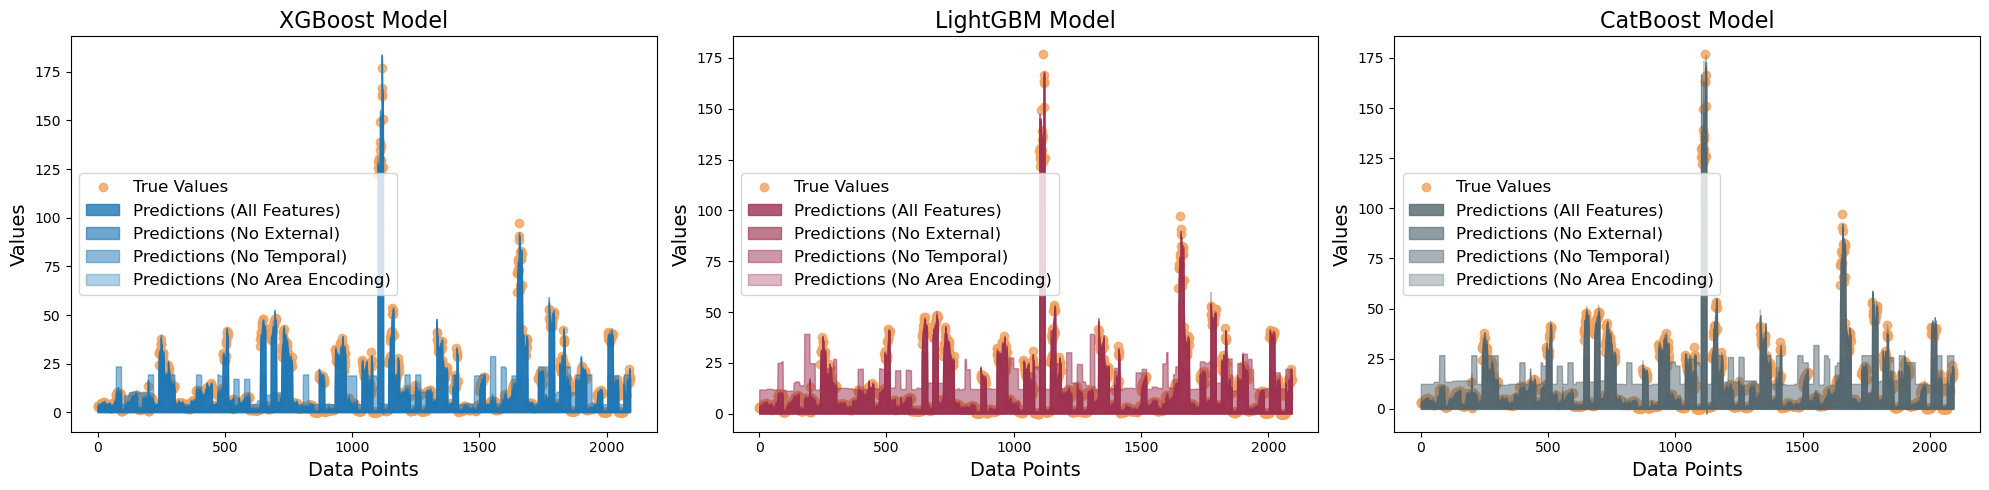

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define a colormap for distinct colors for three models
model_colors = ['#1f77b4', '#9E3150', '#54676F']

# Define labels for feature strategies
labels = ['All Features', 'No External', 'No Temporal', 'No Area Encoding']

# Prediction results list, each sublist represents different feature strategies for models
y_pred_list = [
    [y_pred_xgb_all_features, y_pred_lgb_all_features, y_pred_cb_all_features],
    [y_pred_xgb_no_external, y_pred_lgb_no_external, y_pred_cb_no_external],
    [y_pred_xgb_no_temporal, y_pred_lgb_no_temporal, y_pred_cb_no_temporal],
    [y_pred_xgb_no_area_encoding, y_pred_lgb_no_area_encoding, y_pred_cb_no_area_encoding]
]

# Create three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Define offset for better visualization
offset = 0.3

# Iterate over each model
for i, model_name in enumerate(['XGBoost', 'LightGBM', 'CatBoost']):
    ax = axes[i]
    ax.set_title(f'{model_name} Model', fontsize=16)
    ax.set_xlabel('Data Points', fontsize=14)
    ax.set_ylabel('Values', fontsize=14)
    
    # Define a single color for all feature strategies for the current model
    model_color = model_colors[i]

    # Iterate over each feature strategy
    for j, label in enumerate(labels):
        y_pred = y_pred_list[j][i]
        
        # Calculate transparency (alpha) based on feature strategy index
        alpha = 0.8 - j * 0.15  # Adjust alpha as needed
        
        # Plot true values as scatter (only for the first strategy)
        if j == 0:
            ax.scatter(np.arange(len(y_true)), y_true, c='#F1A360', alpha=0.8, label='True Values', marker='o')

        # Plot stacked area for predictions with offset and varying transparency
        ax.fill_between(np.arange(len(y_pred)), y_pred + offset * j, offset * j, alpha=alpha, color=model_color,
                        label=f'Predictions ({label})')

    ax.legend(fontsize=12)

plt.rc('text', usetex=False)
plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/figure/prediction_comparison.png', dpi = 300)
plt.show()


### 预测误差分布图：

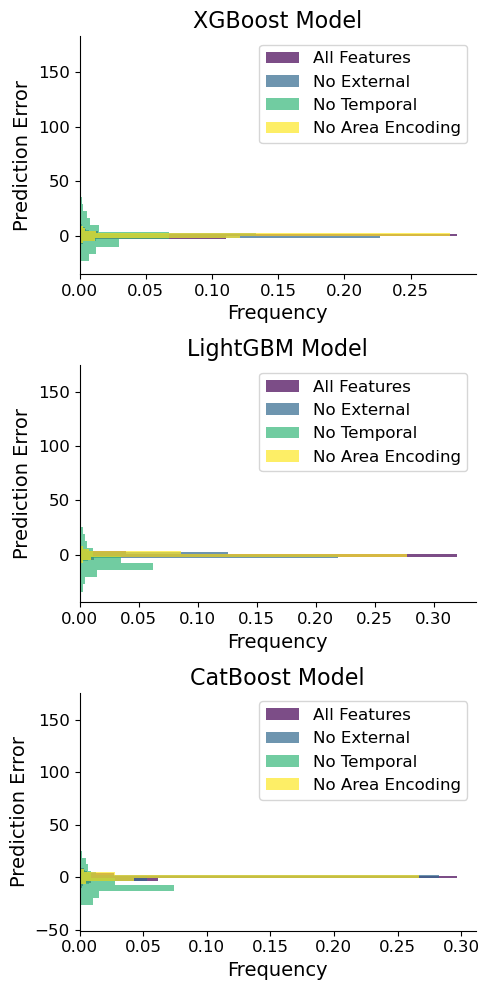

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Define a colormap for gradient colors
colormap = plt.cm.get_cmap('viridis')  # You can choose any colormap you prefer

# Define labels for feature strategies
labels = ['All Features', 'No External', 'No Temporal', 'No Area Encoding']

# Prediction results list, each sublist represents different feature strategies for models
y_pred_list = [
    [y_pred_xgb_all_features, y_pred_lgb_all_features, y_pred_cb_all_features],
    [y_pred_xgb_no_external, y_pred_lgb_no_external, y_pred_cb_no_external],
    [y_pred_xgb_no_temporal, y_pred_lgb_no_temporal, y_pred_cb_no_temporal],
    [y_pred_xgb_no_area_encoding, y_pred_lgb_no_area_encoding, y_pred_cb_no_area_encoding]
]

# Create a figure for prediction error distribution
fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Adjust figure size

# Define an offset for each feature strategy
offsets = [-0.15, 0.0, 0.15, 0.3]

# Iterate over each model
for i, model_name in enumerate(['XGBoost', 'LightGBM', 'CatBoost']):
    ax = axes[i]
    ax.set_title(f'{model_name} Model', fontsize=16)
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('Prediction Error', fontsize=14)
    
    # Iterate over each feature strategy
    for j, label in enumerate(labels):
        y_pred = y_pred_list[j][i]
        
        # Calculate prediction errors
        errors = y_true - y_pred
        
        # Use a gradient color based on the strategy index
        color = colormap(j / (len(labels) - 1))
        
        # Plot a histogram for prediction errors with an offset
        ax.hist(errors + offsets[j], bins=30, alpha=0.7, color=color, label=f'{label}', density=True,
                orientation='horizontal')

    ax.legend(fontsize=12)
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set tick parameters
    ax.tick_params(axis='both', which='both', labelsize=12)

plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/figure/prediction_error.png', dpi = 300)
plt.show()


### 性能指标比较：

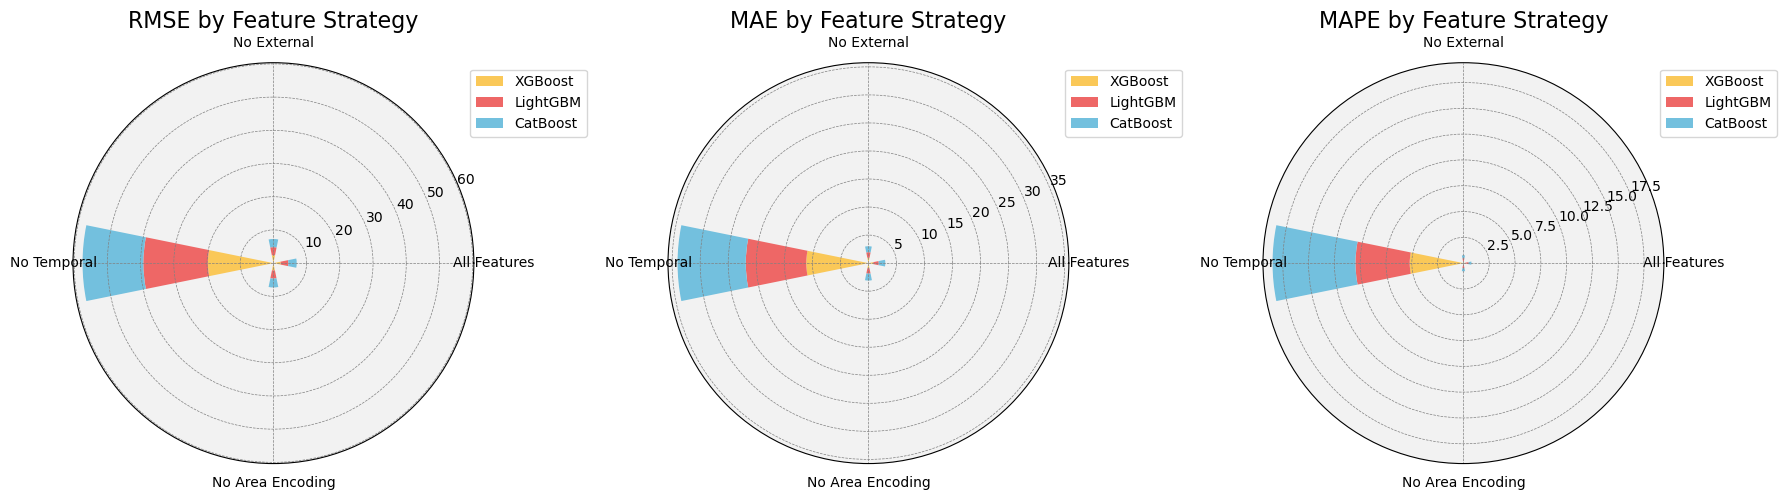

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and feature strategies
models = ['XGBoost', 'LightGBM', 'CatBoost']
strategies = ['All Features', 'No External', 'No Temporal', 'No Area Encoding']

# 创建 XGBoost 模型的列表
xgb_rmse_values = [xgb_rmse, xgb_rmse_no_external, xgb_rmse_no_temporal, xgb_rmse_no_area_encoding]
xgb_mae_values = [xgb_mae, xgb_mae_no_external, xgb_mae_no_temporal, xgb_mae_no_area_encoding]
xgb_mape_values = [xgb_mape / 100, xgb_mape_no_external / 100, xgb_mape_no_temporal / 100, xgb_mape_no_area_encoding / 100]

# 创建 LightGBM 模型的列表
lgb_rmse_values = [lgb_rmse, lgb_rmse_no_external, lgb_rmse_no_temporal, lgb_rmse_no_area_encoding]
lgb_mae_values = [lgb_mae, lgb_mae_no_external, lgb_mae_no_temporal, lgb_mae_no_area_encoding]
lgb_mape_values = [lgb_mape / 100, lgb_mape_no_external / 100, lgb_mape_no_temporal / 100, lgb_mape_no_area_encoding / 100]

# 创建 CatBoost 模型的列表
cb_rmse_values = [cb_rmse, cb_rmse_no_external, cb_rmse_no_temporal, cb_rmse_no_area_encoding]
cb_mae_values = [cb_mae, cb_mae_no_external, cb_mae_no_temporal, cb_mae_no_area_encoding]
cb_mape_values = [cb_mape / 100, cb_mape_no_external / 100, cb_mape_no_temporal / 100, cb_mape_no_area_encoding / 100]

rmse_values = np.array([xgb_rmse_values, lgb_rmse_values, cb_rmse_values])

mae_values = np.array([xgb_mae_values, lgb_mae_values, cb_mae_values])

mape_values = np.array([xgb_mape_values, lgb_mape_values, cb_mape_values])

# Create theta values for radial positions
theta = np.linspace(0, 2 * np.pi, len(strategies), endpoint=False)

# Set the number of models
num_models = len(models)

# Define colors for different evaluation metrics
colors = ['#FAC858', '#EE6766', '#73C0DE']

# Create a list of labels for evaluation metrics
evaluation_labels = ['RMSE', 'MAE', 'MAPE']

# Function to plot polar chart for a specific evaluation metric
def plot_polar_chart(ax, values, metric_label):
    # Initialize a list to store the bottom positions for each bar
    bottom = np.zeros(len(strategies))
    
    # Iterate over each model and plot the bars
    for j, model in enumerate(models):
        ax.bar(theta, values[:, j], width=0.4, bottom=bottom, label=f'{model}', color=colors[j])
        bottom += values[:, j]  # Update the bottom positions for stacking
    
    # Set the radial labels (strategies)
    ax.set_xticks(theta)
    ax.set_xticklabels(strategies)
    
    # Set the radial grid lines
    ax.yaxis.grid(True)
    
    # Set the title and legend
    ax.set_title(f'{metric_label} by Feature Strategy', fontsize=16)
    ax.set_facecolor('#f2f2f2')  # Background color
    ax.grid(linestyle='--', linewidth=0.5, color='gray')  # Grid lines
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Create a figure and axes for the polar plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

# Iterate over each evaluation metric and plot the polar plot
for i, evaluation_metric in enumerate(evaluation_labels):
    ax = axs[i]
    values = rmse_values.T if evaluation_metric == 'RMSE' else mae_values.T if evaluation_metric == 'MAE' else mape_values.T
    plot_polar_chart(ax, values, evaluation_metric)

# Adjust the layout and show the polar plots
plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/figure/metrics_comparison.png', dpi=300)
plt.show()


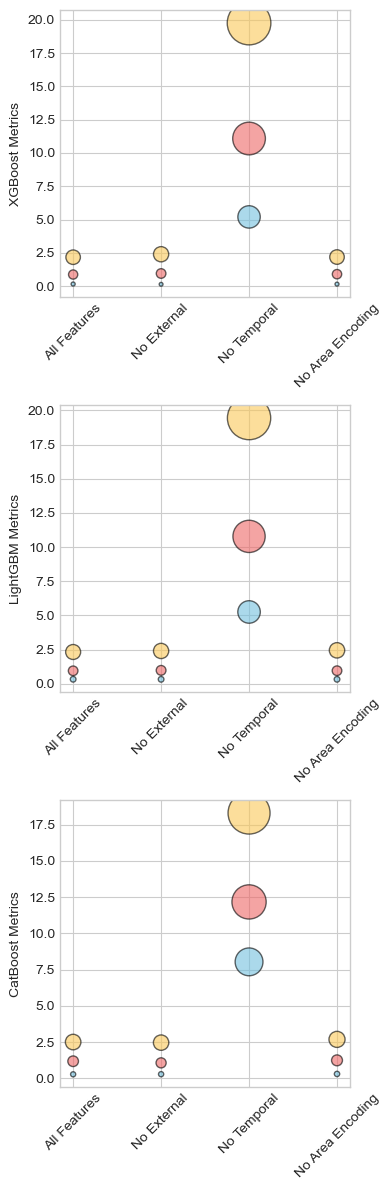

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 设置SciPy绘图风格
plt.style.use('seaborn-whitegrid')

# 定义策略和模型名称
strategies = ['All Features', 'No External', 'No Temporal', 'No Area Encoding']
model_names = ['XGBoost', 'LightGBM', 'CatBoost']

# 定义气泡颜色
bubble_colors = ['#FAC858', '#EE6766', '#73C0DE']

# 创建三个子图，分别绘制XGBoost、LightGBM和CatBoost的性能值对比
fig, axes = plt.subplots(3, 1, figsize=(4, 12))

# 指定y轴标签
y_labels = ['RMSE', 'MAE', 'MAPE']

for i, model_name in enumerate(model_names):
    ax = axes[i]
    
    # 根据模型选择性能值数据
    if model_name == 'XGBoost':
        metric_values = [xgb_rmse_values, xgb_mae_values, xgb_mape_values]
    elif model_name == 'LightGBM':
        metric_values = [lgb_rmse_values, lgb_mae_values, lgb_mape_values]
    elif model_name == 'CatBoost':
        metric_values = [cb_rmse_values, cb_mae_values, cb_mape_values]
    
    for j, metric_name in enumerate(y_labels):
        sizes = [val * 50 for val in metric_values[j]]  # 调整气泡大小
        ax.scatter(np.arange(len(strategies)), metric_values[j], s=sizes, label=f'{metric_name}', alpha=0.6, edgecolors='k', c=bubble_colors[j])

    # 添加标签和标题
    ax.set_ylabel(f'{model_name} Metrics')
#     ax.set_title(f'{model_name} Metrics by Feature Strategy')
    
    # 设置x轴标签，并旋转45度
    ax.set_xticks(np.arange(len(strategies)))
    ax.set_xticklabels(strategies, rotation=45)

# 调整子图间距
plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/figure/metrics_comparison_bubble.png', dpi = 300)
plt.show()


### DM test

In [15]:
import numpy as np
from scipy.stats import norm

# 定义自定义的DM检验函数
def diebold_mariano_test(errors_model1, errors_model2, h=0):
    n = len(errors_model1)
    d = errors_model1 - errors_model2
    d_mean = np.mean(d)
    mse = np.mean(d ** 2)

    dm_stat = d_mean / np.sqrt((1 / n) * mse)
    se = np.sqrt((1 / n) * ((1 + 2 * h) * mse))
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat / se)))

    return dm_stat, p_value

# 首先，将 'All Features' 模型的预测误差存储在一个数组中
errors_all_features = y_pred_xgb_all_features - y_true

# 定义其他11个模型的名称和相应的预测误差数组
model_names = [
    'No External', 'No Temporal', 'No Area Encoding',
    'No External (LGBM)', 'No Temporal (LGBM)', 'No Area Encoding (LGBM)',
    'No External (CatBoost)', 'No Temporal (CatBoost)', 'No Area Encoding (CatBoost)',
]

errors_by_model = {
    'No External': y_pred_xgb_no_external - y_true,
    'No Temporal': y_pred_xgb_no_temporal - y_true,
    'No Area Encoding': y_pred_xgb_no_area_encoding - y_true,
    'No External (LGBM)': y_pred_lgb_no_external - y_true,
    'No Temporal (LGBM)': y_pred_lgb_no_temporal - y_true,
    'No Area Encoding (LGBM)': y_pred_lgb_no_area_encoding - y_true,
    'No External (CatBoost)': y_pred_cb_no_external - y_true,
    'No Temporal (CatBoost)': y_pred_cb_no_temporal - y_true,
    'No Area Encoding (CatBoost)': y_pred_cb_no_area_encoding - y_true,
}

# 进行DM检验并比较 'All Features' 模型与其他11个模型
for model_name in model_names:
    dm_stat, p_value = diebold_mariano_test(errors_all_features, errors_by_model[model_name])
    print(f'DM统计量 ({model_name}): {dm_stat:.4f}')
    print(f'P值 ({model_name}): {p_value:.4f}')
    if p_value < 0.05:
        print("Statistically significant difference")
    else:
        print("No statistically significant difference")
    print()


DM统计量 (No External): -1.1470
P值 (No External): 0.0000
Statistically significant difference

DM统计量 (No Temporal): 2.4146
P值 (No Temporal): 0.0000
Statistically significant difference

DM统计量 (No Area Encoding): -2.8047
P值 (No Area Encoding): 0.0000
Statistically significant difference

DM统计量 (No External (LGBM)): -5.6489
P值 (No External (LGBM)): 0.0000
Statistically significant difference

DM统计量 (No Temporal (LGBM)): -12.6205
P值 (No Temporal (LGBM)): 0.0000
Statistically significant difference

DM统计量 (No Area Encoding (LGBM)): -6.1852
P值 (No Area Encoding (LGBM)): 0.0000
Statistically significant difference

DM统计量 (No External (CatBoost)): -2.9484
P值 (No External (CatBoost)): 0.0000
Statistically significant difference

DM统计量 (No Temporal (CatBoost)): -13.6517
P值 (No Temporal (CatBoost)): 0.0000
Statistically significant difference

DM统计量 (No Area Encoding (CatBoost)): -0.6467
P值 (No Area Encoding (CatBoost)): 0.0000
Statistically significant difference



### 收敛分析

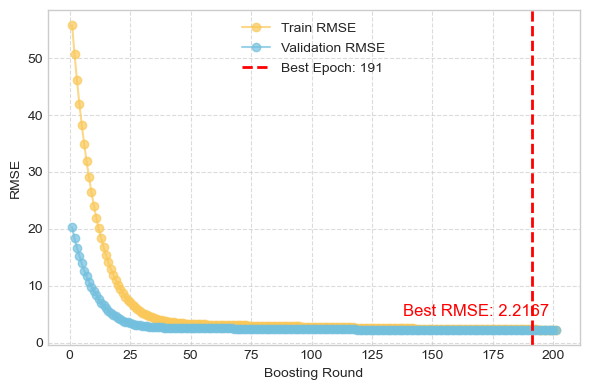

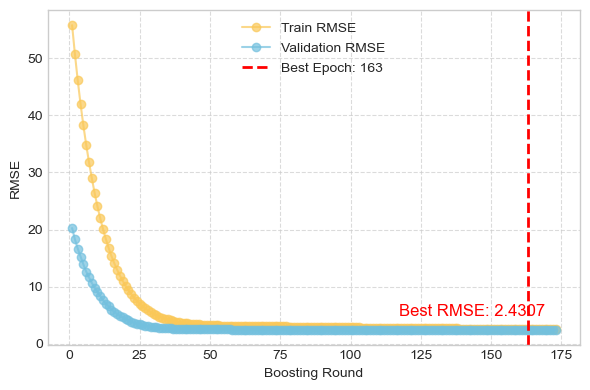

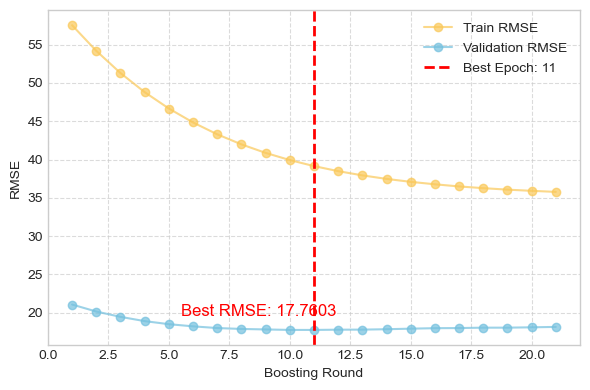

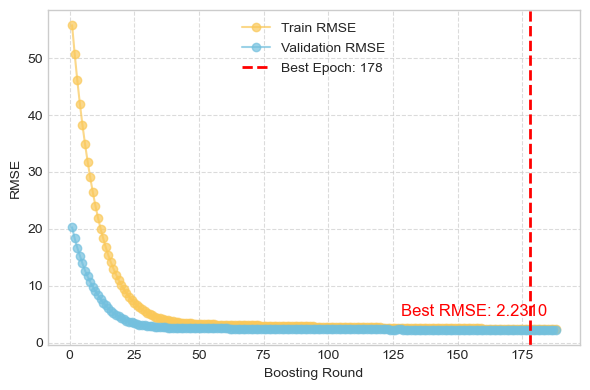

In [19]:
import matplotlib.pyplot as plt

# Load the saved training and validation errors for each feature set
def load_errors(model_name, feature_type):
    train_errors_file = f'./ml/{model_name}_train_errors_{feature_type}.txt'
    valid_errors_file = f'./ml/{model_name}_valid_errors_{feature_type}.txt'
    
    with open(train_errors_file, 'r') as f:
        train_errors = [float(line.strip()) for line in f.readlines()]
    
    with open(valid_errors_file, 'r') as f:
        valid_errors = [float(line.strip()) for line in f.readlines()]
    
    return train_errors, valid_errors

# Plot training and validation errors over boosting rounds
def plot_convergence(train_errors, valid_errors, model_name, feature_type):
    plt.figure(figsize=(6, 4))
    epochs = range(1, len(train_errors) + 1)
    
    plt.plot(epochs, train_errors, label='Train RMSE', marker='o', linestyle='-', color='#FAC858', alpha=0.7)
    plt.plot(epochs, valid_errors, label='Validation RMSE', marker='o', linestyle='-', color='#73C0DE', alpha=0.7)
    
    best_epoch = valid_errors.index(min(valid_errors)) + 1
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}', linewidth=2)
    
    plt.xlabel('Boosting Round')
    plt.ylabel('RMSE')
#   plt.title(f'{model_name} Convergence Analysis ({feature_type})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Highlight best performance
    ymin, ymax = plt.ylim()
    plt.annotate(f'Best RMSE: {min(valid_errors):.4f}', (best_epoch, min(valid_errors)), textcoords="offset points", xytext=(-40, 10),
                 ha='center', fontsize=12, color='red')
    
    plt.tight_layout()  # Ensures labels are not cut off
    save_file_name = f'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/figure/{model_name}_convergence_{feature_type}.png'
    plt.savefig(save_file_name, dpi=300)
    plt.show()

# Load and plot convergence for XGBoost models with different feature sets
feature_types = ['All_Features', 'No_External', 'No_Temporal', 'No_Area_Encoding']
model_name = 'xgb_model'

for feature_type in feature_types:
    train_errors, valid_errors = load_errors(model_name, feature_type)
    plot_convergence(train_errors, valid_errors, model_name, feature_type)


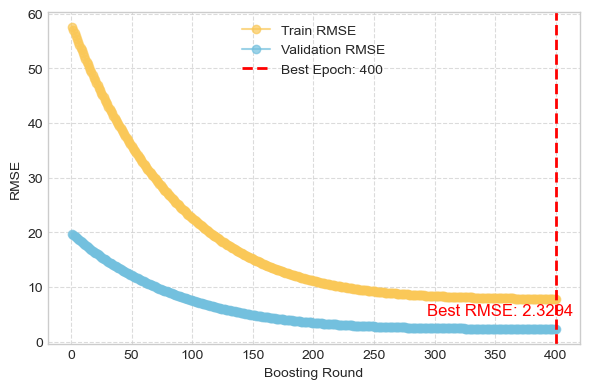

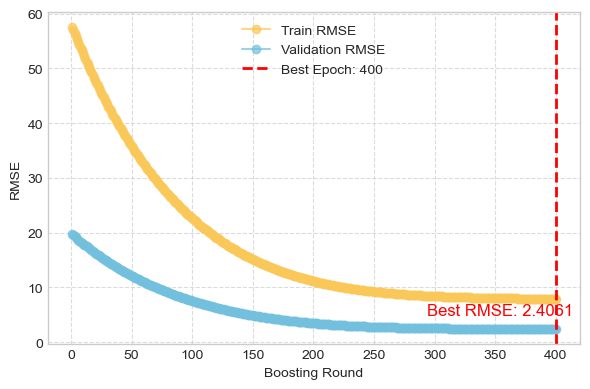

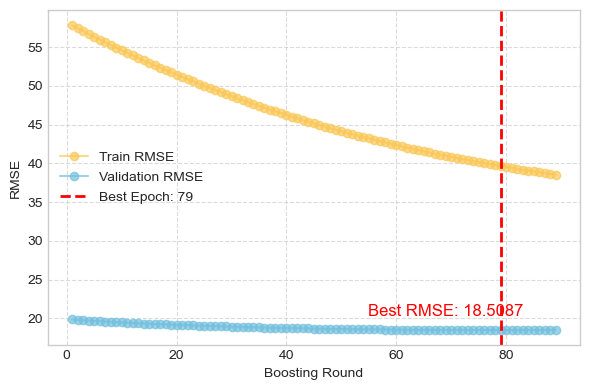

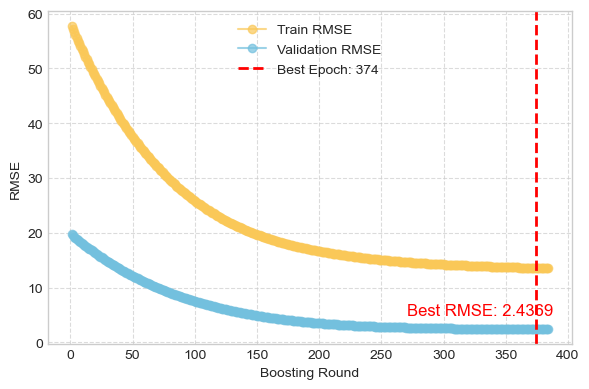

In [20]:
import matplotlib.pyplot as plt

# Load and plot convergence for XGBoost models with different feature sets
feature_types = ['All_Features', 'No_External', 'No_Temporal', 'No_Area_Encoding']
model_name = 'lgb_model'

for feature_type in feature_types:
    train_errors, valid_errors = load_errors(model_name, feature_type)
    plot_convergence(train_errors, valid_errors, model_name, feature_type)


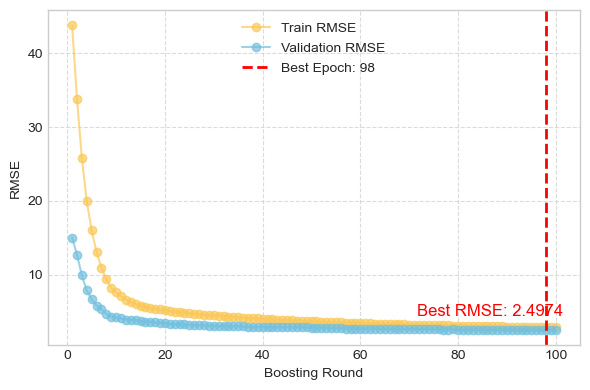

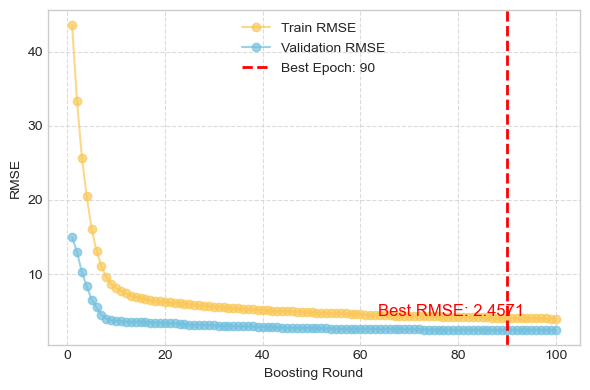

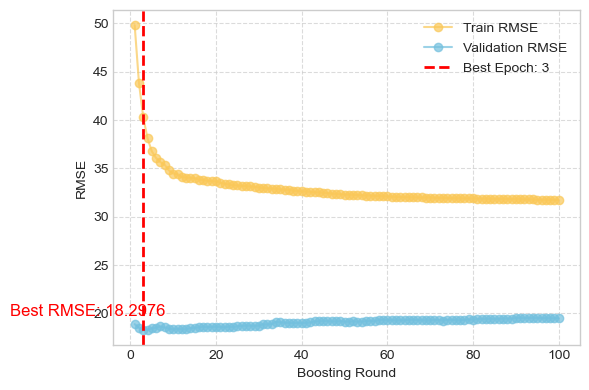

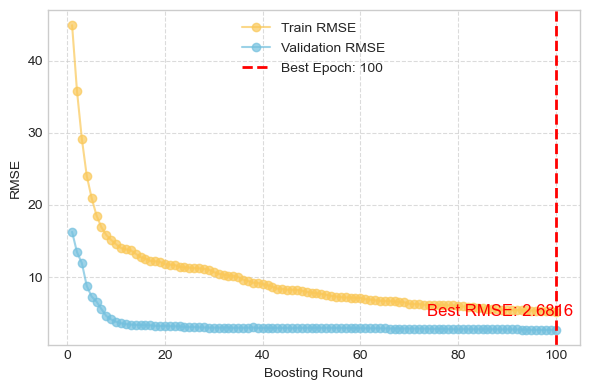

In [21]:
# Load and plot convergence for XGBoost models with different feature sets
feature_types = ['All_Features', 'No_External', 'No_Temporal', 'No_Area_Encoding']
model_name = 'cb_model'

for feature_type in feature_types:
    train_errors, valid_errors = load_errors(model_name, feature_type)
    plot_convergence(train_errors, valid_errors, model_name, feature_type)


### 测试集预测结果对比

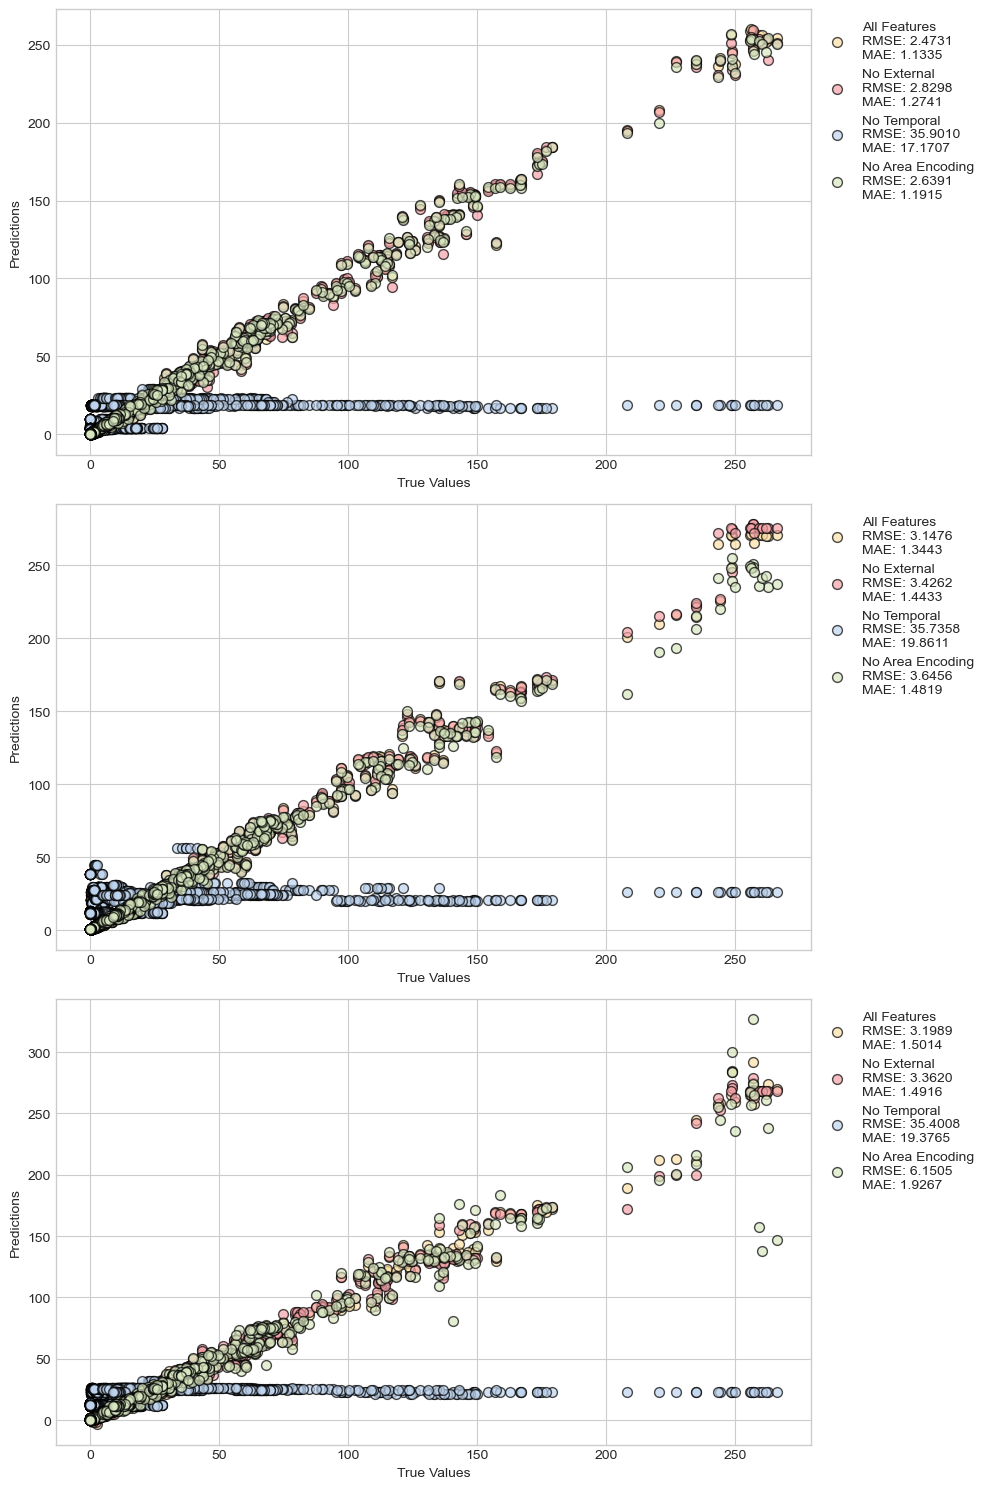

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns

# 设置Seaborn绘图风格
plt.style.use('seaborn-whitegrid')

x_test_no_external = x_test[features_no_external]

x_test_no_temporal = x_test[features_no_temporal]

x_test_no_area_encoding = x_test[features_no_area_encoding]

# 预测测试集结果
y_pred_test_xgb_all_features = xgb_model_all_features.predict(x_test)
y_pred_test_lgb_all_features = lgb_model_all_features.predict(x_test)
y_pred_test_cb_all_features = cb_model_all_features.predict(x_test)

y_pred_test_xgb_no_external = xgb_model_no_external.predict(x_test_no_external)
y_pred_test_lgb_no_external = lgb_model_no_external.predict(x_test_no_external)
y_pred_test_cb_no_external = cb_model_no_external.predict(x_test_no_external)

y_pred_test_xgb_no_temporal = xgb_model_no_temporal.predict(x_test_no_temporal)
y_pred_test_lgb_no_temporal = lgb_model_no_temporal.predict(x_test_no_temporal)
y_pred_test_cb_no_temporal = cb_model_no_temporal.predict(x_test_no_temporal)

y_pred_test_xgb_no_area_encoding = xgb_model_no_area_encoding.predict(x_test_no_area_encoding)
y_pred_test_lgb_no_area_encoding = lgb_model_no_area_encoding.predict(x_test_no_area_encoding)
y_pred_test_cb_no_area_encoding = cb_model_no_area_encoding.predict(x_test_no_area_encoding)

# Define a list of brighter colors
colors = ['#FCE0A8', '#F5A2A8', '#BFD4EE', '#D8E7C0']

# Define a list of model names
model_names = ["XGBoost", "LightGBM", "CatBoost"]

# Define a list of feature types
feature_types = ["All Features", "No External", "No Temporal", "No Area Encoding"]

# Create subplots for each model
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, model_name in enumerate(model_names):
    ax = axes[i]
    for j, feature_type in enumerate(feature_types):
        if model_name == "XGBoost":
            y_pred = y_pred_test_xgb_all_features if feature_type == "All Features" else \
                (y_pred_test_xgb_no_external if feature_type == "No External" else \
                (y_pred_test_xgb_no_temporal if feature_type == "No Temporal" else \
                y_pred_test_xgb_no_area_encoding))
        elif model_name == "LightGBM":
            y_pred = y_pred_test_lgb_all_features if feature_type == "All Features" else \
                (y_pred_test_lgb_no_external if feature_type == "No External" else \
                (y_pred_test_lgb_no_temporal if feature_type == "No Temporal" else \
                y_pred_test_lgb_no_area_encoding))
        else:  # CatBoost
            y_pred = y_pred_test_cb_all_features if feature_type == "All Features" else \
                (y_pred_test_cb_no_external if feature_type == "No External" else \
                (y_pred_test_cb_no_temporal if feature_type == "No Temporal" else \
                y_pred_test_cb_no_area_encoding))
            
        # Filter out data points with a true value of zero
        non_zero_mask = y_test != 0
        y_test_non_zero = y_test[non_zero_mask]
        y_pred_non_zero = y_pred[non_zero_mask]

        
        # Calculate performance evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        # Create a scatter plot with Seaborn
        scatter = ax.scatter(
            y_test, y_pred, 
            label=feature_type, s=50, alpha=0.7, 
            color=colors[j], edgecolors='k'  # Specify marker edge color
        )
        
        # Display performance evaluation metrics next to the legend
        legend_label = f'{feature_type}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}'
        scatter.set_label(legend_label)

    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.legend(loc='upper left', framealpha=0.7, bbox_to_anchor=(1, 1))  # Adjust legend placement and background transparency

plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/figure/prediction_outcomes', dpi=300)
plt.show()


### 预测值与真实值的灰色关联分析

In [71]:
import numpy as np

def grey_correlation_coefficient(x, y):
    # Calculate the Grey Correlation Coefficient
    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)
    
    d_x = np.abs(x - min_x) / (max_x - min_x)
    d_y = np.abs(y - min_y) / (max_y - min_y)
    
    rho = 0.5  # Adjust this value if needed
    
    grey_corr = np.exp(-rho * np.sqrt(d_x * d_y).mean())
    
    return grey_corr

# Create a list of predictions for all models
all_predictions = [
    y_pred_xgb_all_features, y_pred_lgb_all_features, y_pred_cb_all_features,
    y_pred_xgb_no_external, y_pred_lgb_no_external, y_pred_cb_no_external,
    y_pred_xgb_no_temporal, y_pred_lgb_no_temporal, y_pred_cb_no_temporal,
    y_pred_xgb_no_area_encoding, y_pred_lgb_no_area_encoding, y_pred_cb_no_area_encoding
]

# Calculate the Grey Correlation Coefficient for each model's predictions
gcc_scores = []
for predictions in all_predictions:
    gcc = grey_correlation_coefficient(predictions, y_true)
    gcc_scores.append(gcc)

# Create a list of model names
model_names = ['XGB_All_Features', 'LGB_All_Features', 'CB_All_Features',
               'XGB_No_External', 'LGB_No_External', 'CB_No_External',
               'XGB_No_Temporal', 'LGB_No_Temporal', 'CB_No_Temporal',
               'XGB_No_Area_Encoding', 'LGB_No_Area_Encoding', 'CB_No_Area_Encoding']

# Create a dictionary to store model names and their GCC scores
model_gcc_dict = dict(zip(model_names, gcc_scores))

# Sort models by GCC scores
sorted_models = sorted(model_gcc_dict, key=model_gcc_dict.get, reverse=True)

# Print the Grey Correlation Coefficients and Ranking
for i, model_name in enumerate(sorted_models):
    print(f'{model_name}: Grey Correlation Coefficient = {model_gcc_dict[model_name]}, Ranking = {i + 1}')


XGB_All_Features: Grey Correlation Coefficient = 0.9654745412635156, Ranking = 1
XGB_No_Area_Encoding: Grey Correlation Coefficient = 0.9652548995958744, Ranking = 2
LGB_All_Features: Grey Correlation Coefficient = 0.9643787659151506, Ranking = 3
LGB_No_External: Grey Correlation Coefficient = 0.9642772579083103, Ranking = 4
XGB_No_External: Grey Correlation Coefficient = 0.9641356096068747, Ranking = 5
LGB_No_Area_Encoding: Grey Correlation Coefficient = 0.9641168085758431, Ranking = 6
CB_All_Features: Grey Correlation Coefficient = 0.9640477078104548, Ranking = 7
CB_No_Area_Encoding: Grey Correlation Coefficient = 0.963945091884015, Ranking = 8
CB_No_External: Grey Correlation Coefficient = 0.9612097996580441, Ranking = 9
LGB_No_Temporal: Grey Correlation Coefficient = 0.945470859149469, Ranking = 10
XGB_No_Temporal: Grey Correlation Coefficient = 0.9379727912350354, Ranking = 11
CB_No_Temporal: Grey Correlation Coefficient = 0.9368150543914505, Ranking = 12


### Wilcoxon秩和检验

In [36]:
import numpy as np
from scipy.stats import wilcoxon

# 创建一个字典，其中每个键对应一个模型
models = {
    "XGBoost (All Features)": y_pred_xgb_all_features,
    "LightGBM (All Features)": y_pred_lgb_all_features,
    "CatBoost (All Features)": y_pred_cb_all_features,
    "XGBoost (No External Features)": y_pred_xgb_no_external,
    "LightGBM (No External Features)": y_pred_lgb_no_external,
    "CatBoost (No External Features)": y_pred_cb_no_external,
    "XGBoost (No Temporal Features)": y_pred_xgb_no_temporal,
    "LightGBM (No Temporal Features)": y_pred_lgb_no_temporal,
    "CatBoost (No Temporal Features)": y_pred_cb_no_temporal,
    "XGBoost (No Area Encoding Features)": y_pred_xgb_no_area_encoding,
    "LightGBM (No Area Encoding Features)": y_pred_lgb_no_area_encoding,
    "CatBoost (No Area Encoding Features)": y_pred_cb_no_area_encoding
}

# 创建一个字典以存储Wilcoxon检验的结果
wilcoxon_results = {}

# 对每个模型执行Wilcoxon检验
for model_name, model_preds in models.items():
    statistic, p_value = wilcoxon(model_preds, y_true, alternative='two-sided')  # 使用两边检验
    wilcoxon_results[model_name] = (statistic, p_value)

# 输出Wilcoxon检验的结果
for model_name, (statistic, p_value) in wilcoxon_results.items():
    print(f"{model_name}:")
    print(f"Wilcoxon Statistic: {statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("Statistically significant difference.")
    else:
        print("No statistically significant difference.")
    print()


XGBoost (All Features):
Wilcoxon Statistic: 1051145.0
P-value: 0.10722764378411603
No statistically significant difference.

LightGBM (All Features):
Wilcoxon Statistic: 600156.0
P-value: 8.155642195701909e-72
Statistically significant difference.

CatBoost (All Features):
Wilcoxon Statistic: 1023510.0
P-value: 0.009049374810883163
Statistically significant difference.

XGBoost (No External Features):
Wilcoxon Statistic: 999247.0
P-value: 0.0004873039359944401
Statistically significant difference.

LightGBM (No External Features):
Wilcoxon Statistic: 600929.0
P-value: 1.3475055269979126e-71
Statistically significant difference.

CatBoost (No External Features):
Wilcoxon Statistic: 965689.0
P-value: 2.585805474518223e-06
Statistically significant difference.

XGBoost (No Temporal Features):
Wilcoxon Statistic: 860213.0
P-value: 1.6555797721845682e-17
Statistically significant difference.

LightGBM (No Temporal Features):
Wilcoxon Statistic: 423331.0
P-value: 1.3508647946394715e-130
Stat

In [23]:
def predict_models(x_test):
    # XGBoost
    day_flow_XGB = xgb_model_all_features.predict(x_test)
    day_flow_XGB[day_flow_XGB < 0] = 0

    # LightGBM
    day_flow_LGB = lgb_model_all_features.predict(x_test)
    day_flow_LGB[day_flow_LGB < 0] = 0

    # CatBoost
    day_flow_CB = cb_model_all_features.predict(x_test)
    day_flow_CB[day_flow_CB < 0] = 0
    
    return day_flow_XGB, day_flow_LGB, day_flow_CB


In [24]:
day_flow_XGB, day_flow_LGB, day_flow_CB = predict_models(x_test)

In [25]:
# save the result of base
with open('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/base_xgb.pkl', 'wb') as f:
    pkl.dump(day_flow_XGB, f)

In [26]:
def Hour_level_flow_prediction(model='XGBoost',
                               mode='Validation',
                               weekday=False):

    pred_res = {}
    for hour in range(24):
        with open(
                '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/grid_flow_graph/area_embedding/area_flow_hour_node2vec_embed_16_wl5_'
                + str(hour) + '.pkl', 'rb') as f:
            hour_embed = pkl.load(f)
        if model == 'XGBoost' or weekday == False:
            with open(
                    '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/grid_flow_graph/area_flow_graph/area_embedding_0/area_flow_hour_embed_'
                    + str(hour) + '.pkl', 'rb') as f:
                hour_embed = pkl.load(f)
                hour_embed = {int(k) + 1: v for k, v in hour_embed.items()}
                area_embed = pd.DataFrame.from_dict(
                    hour_embed, orient='index').reset_index().rename(
                        columns={'index': 'ID'})

        elif model in ['LightGBM', 'CatBoost']:
            with open(
                    '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/cache/grid_flow_graph/area_flow_graph/area_embedding_0/area_flow_hour_embed_'
                    + str(hour) + '.pkl', 'rb') as f:
                hour_embed = pkl.load(f)
                hour_embed = {int(k) + 1: v for k, v in hour_embed.items()}
                area_embed = pd.DataFrame.from_dict(
                    hour_embed, orient='index').reset_index().rename(
                        columns={'index': 'ID'})

        if mode == 'Validation':
            split_day = 23  # 20200209
            flow_data = area_index[area_index['hour'] == hour][[
                'ID', 'people_index', 'day'
            ]]
        if mode == 'Predict':
            split_day = 30  # 20200216
            data_test = pd.read_csv(
                r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/test_submit_example.csv',
                header=None,
                names=['ID', 'date', 'people_index'])
            data_test['date'] = pd.to_datetime(data_test['date'],
                                               format='%Y%m%d%H')
            data_test['day'] = data_test['date'].dt.day.apply(lambda x: x + 14)
            data_test['hour'] = data_test['date'].dt.hour
            data_test = data_test[data_test['hour'] == hour][[
                'ID', 'people_index', 'day'
            ]]
            area_index_1 = area_index[area_index['hour'] == hour][[
                'ID', 'people_index', 'day'
            ]]
            flow_data = pd.concat([area_index_1,
                                   data_test]).sort_values(['ID', 'day'])

        predict_len = 5 if weekday else 7
        split_day = split_day + 1 if weekday else split_day
        flow_data = Feature_extraction(flow_data, split_day, area_embed,
                                       weekday, model)

        data_test = flow_data[flow_data['day'] >= split_day]
        data_train = flow_data[flow_data['day'] < split_day]
        y_train = data_train['people_index']
        data_train = data_train[[
            'day', 'temp_min', 'wind', 'weekend', 'confirmedIncr', 'area',
            'area_type', 'closeness', 'period', 'trend', 'flow_3d_mean',
            'index_mean_in', 'index_std_in', 'index_mean_out', 'index_std_out'
        ]]
        
        if model == 'XGBoost':
            model_tree = xgb_model_all_features.fit(data_train, y_train)

        if model == 'LightGBM':
            model_tree = lgb_model_all_features.fit(data_train, y_train)

        if model == 'CatBoost':
            model_tree = cb_model_all_features.fit(data_train, y_train)

        MAE = []
        scores = []
        pred_flow = []
        for day in range(split_day, split_day + predict_len):
            day_data = data_test[data_test['day'] == day]
            if len(day_data) == 0:
                continue
            day_data['flow_3d_mean'] = day_data[[
                'flow_1d', 'flow_2d', 'flow_3d'
            ]].mean(axis=1)
            day_y = day_data['people_index']
            day_data = day_data[[
                'day', 'temp_min', 'wind', 'weekend', 'confirmedIncr', 'area',
                'area_type', 'closeness', 'period', 'trend', 'flow_3d_mean',
                'index_mean_in', 'index_std_in', 'index_mean_out',
                'index_std_out'
            ]]
            day_flow = model_tree.predict(day_data)

            day_flow[day_flow < 0] = 0
            pred_flow.append(day_flow)

            if mode == 'Validation':
                scores.append(mean_squared_error(day_y, day_flow))
                MAE.append(mean_absolute_error(day_y, day_flow))

            if day < split_day + predict_len - 1:
                data_test.loc[data_test['day'] == day + 1,
                              'flow_3d'] = data_test[data_test['day'] ==
                                                     day]['flow_2d'].tolist()
                data_test.loc[data_test['day'] == day + 1,
                              'flow_2d'] = data_test[data_test['day'] ==
                                                     day]['flow_1d'].tolist()
                data_test.loc[data_test['day'] == day + 1,
                              'flow_1d'] = day_flow

        pred_res[hour] = {'pred_flow': np.array(pred_flow)}
        if mode == 'Validation':
            scores = np.array(scores)
            MAE = np.array(MAE)
            print(hour, round(1 / (scores.mean()**0.5 + 1), 6), MAE)
            pred_res[hour]['score'] = scores

    return pred_res

In [27]:
def validation_score(pred_res, predict_len=7):
    day_s = [0]*predict_len
    for k, v in pred_res.items():
        for i in range(predict_len):
            day_s[i] += v['score'][i]
            
    for i in range(predict_len):
        print('day'+str(i), 1/((day_s[i]/24)**0.5+1))

In [28]:
def evaluate_hourly_predictions(model):
    valid_res = Hour_level_flow_prediction(model=model, mode='Validation')
    validation_score(valid_res, 7)

evaluate_hourly_predictions('XGBoost')
evaluate_hourly_predictions('LightGBM')
evaluate_hourly_predictions('CatBoost')

0 0.264386 [0.84600214 0.77198962 0.99438974 0.99196875 1.01129207 1.02371951
 1.04494914]
1 0.317493 [0.71027931 0.68634729 0.7069006  0.74383792 0.79290166 0.81515072
 0.83610321]
2 0.18975 [0.70466431 0.68674289 0.67303895 0.9295337  0.83417881 0.90619613
 0.86855303]
3 0.253399 [0.60454234 0.61493724 0.60294465 0.66593588 0.66842888 0.74360446
 0.69542282]
4 0.329161 [0.56582773 0.54158293 0.5698053  0.52714391 0.54997644 0.72296694
 0.67055486]
5 0.247914 [0.57909387 0.71030754 0.69978251 0.68355966 0.73797122 0.83952798
 0.75906858]
6 0.236842 [0.81869443 1.57788369 0.96484028 0.94760828 0.9471184  0.96581099
 1.36535713]
7 0.119692 [1.17905019 4.96278527 1.70133862 1.49093082 2.08899375 3.31870924
 3.70633326]
8 0.080692 [1.65954819 7.26969159 2.67495611 2.62497901 2.93847879 3.96328523
 5.69856891]
9 0.080604 [1.8751647  7.02370296 2.59390588 2.75690466 2.73329607 3.52619248
 4.50955504]
10 0.084338 [2.27854906 6.59158669 2.82375386 3.15465872 2.76289077 3.70570625
 3.76844719]

0:	learn: 21.6620497	total: 943us	remaining: 93.4ms
1:	learn: 16.5674750	total: 1.96ms	remaining: 96.2ms
2:	learn: 12.9811897	total: 2.98ms	remaining: 96.2ms
3:	learn: 10.1655617	total: 3.88ms	remaining: 93.2ms
4:	learn: 8.3384418	total: 4.76ms	remaining: 90.4ms
5:	learn: 6.8629821	total: 5.79ms	remaining: 90.7ms
6:	learn: 5.7529569	total: 6.72ms	remaining: 89.3ms
7:	learn: 5.0364413	total: 7.65ms	remaining: 88ms
8:	learn: 4.3211585	total: 8.6ms	remaining: 87ms
9:	learn: 3.8766834	total: 9.61ms	remaining: 86.5ms
10:	learn: 3.4968044	total: 10.5ms	remaining: 85.2ms
11:	learn: 3.1242430	total: 11.5ms	remaining: 84.2ms
12:	learn: 2.8720401	total: 12.5ms	remaining: 83.6ms
13:	learn: 2.6808959	total: 13.6ms	remaining: 83.3ms
14:	learn: 2.5092226	total: 14.5ms	remaining: 82.2ms
15:	learn: 2.3775260	total: 15.5ms	remaining: 81.6ms
16:	learn: 2.2773572	total: 16.4ms	remaining: 80.1ms
17:	learn: 2.2009668	total: 17.4ms	remaining: 79.2ms
18:	learn: 2.1534991	total: 18.3ms	remaining: 78.2ms
19:	l

42:	learn: 1.3924963	total: 43.3ms	remaining: 57.4ms
43:	learn: 1.3836653	total: 44.4ms	remaining: 56.6ms
44:	learn: 1.3688916	total: 45.5ms	remaining: 55.6ms
45:	learn: 1.3512353	total: 46.4ms	remaining: 54.5ms
46:	learn: 1.3438268	total: 47.4ms	remaining: 53.5ms
47:	learn: 1.3366285	total: 48.4ms	remaining: 52.5ms
48:	learn: 1.3276660	total: 49.5ms	remaining: 51.5ms
49:	learn: 1.3164215	total: 50.5ms	remaining: 50.5ms
50:	learn: 1.3054864	total: 51.5ms	remaining: 49.5ms
51:	learn: 1.2959962	total: 52.6ms	remaining: 48.5ms
52:	learn: 1.2871278	total: 53.5ms	remaining: 47.5ms
53:	learn: 1.2805962	total: 54.4ms	remaining: 46.3ms
54:	learn: 1.2721285	total: 55.3ms	remaining: 45.2ms
55:	learn: 1.2615334	total: 56.3ms	remaining: 44.3ms
56:	learn: 1.2545927	total: 57.3ms	remaining: 43.3ms
57:	learn: 1.2409556	total: 58.3ms	remaining: 42.2ms
58:	learn: 1.2360957	total: 59.4ms	remaining: 41.3ms
59:	learn: 1.2263730	total: 60.5ms	remaining: 40.3ms
60:	learn: 1.2187408	total: 61.7ms	remaining: 

87:	learn: 1.1656062	total: 85.9ms	remaining: 11.7ms
88:	learn: 1.1586910	total: 87ms	remaining: 10.8ms
89:	learn: 1.1536914	total: 87.9ms	remaining: 9.77ms
90:	learn: 1.1517820	total: 88.9ms	remaining: 8.79ms
91:	learn: 1.1470750	total: 89.8ms	remaining: 7.81ms
92:	learn: 1.1442517	total: 90.8ms	remaining: 6.84ms
93:	learn: 1.1396679	total: 91.8ms	remaining: 5.86ms
94:	learn: 1.1378819	total: 92.7ms	remaining: 4.88ms
95:	learn: 1.1323879	total: 93.6ms	remaining: 3.9ms
96:	learn: 1.1284769	total: 94.6ms	remaining: 2.93ms
97:	learn: 1.1248580	total: 96.1ms	remaining: 1.96ms
98:	learn: 1.1212509	total: 97.1ms	remaining: 981us
99:	learn: 1.1185375	total: 98.3ms	remaining: 0us
5 0.186206 [0.59704358 0.71576477 0.76388512 0.77590145 0.80606383 0.88110739
 0.92106298]
0:	learn: 33.4157931	total: 1.14ms	remaining: 113ms
1:	learn: 25.9712624	total: 2.16ms	remaining: 106ms
2:	learn: 20.6670229	total: 3.2ms	remaining: 104ms
3:	learn: 16.0023106	total: 4.14ms	remaining: 99.3ms
4:	learn: 12.871348

0:	learn: 49.1894506	total: 1.17ms	remaining: 116ms
1:	learn: 38.0005553	total: 2.6ms	remaining: 127ms
2:	learn: 29.5513988	total: 3.82ms	remaining: 123ms
3:	learn: 22.9343414	total: 4.73ms	remaining: 113ms
4:	learn: 18.2891742	total: 5.79ms	remaining: 110ms
5:	learn: 14.8923238	total: 6.69ms	remaining: 105ms
6:	learn: 12.5897667	total: 7.73ms	remaining: 103ms
7:	learn: 11.0746893	total: 8.65ms	remaining: 99.5ms
8:	learn: 10.0773716	total: 9.72ms	remaining: 98.3ms
9:	learn: 9.3382007	total: 10.7ms	remaining: 96.2ms
10:	learn: 8.7721150	total: 11.7ms	remaining: 94.8ms
11:	learn: 8.3614541	total: 12.7ms	remaining: 93.1ms
12:	learn: 8.1137386	total: 13.7ms	remaining: 92ms
13:	learn: 7.8377949	total: 14.8ms	remaining: 90.8ms
14:	learn: 7.6689555	total: 15.7ms	remaining: 89ms
15:	learn: 7.4793716	total: 16.6ms	remaining: 87.4ms
16:	learn: 7.3697264	total: 17.5ms	remaining: 85.7ms
17:	learn: 7.2405469	total: 18.5ms	remaining: 84.3ms
18:	learn: 7.1337296	total: 19.5ms	remaining: 83.2ms
19:	le

44:	learn: 6.2406053	total: 47.2ms	remaining: 57.7ms
45:	learn: 6.2039158	total: 48.3ms	remaining: 56.6ms
46:	learn: 6.1365647	total: 49.3ms	remaining: 55.6ms
47:	learn: 6.0908723	total: 50.4ms	remaining: 54.6ms
48:	learn: 6.0607988	total: 51.4ms	remaining: 53.5ms
49:	learn: 6.0331791	total: 52.5ms	remaining: 52.5ms
50:	learn: 6.0147819	total: 53.6ms	remaining: 51.5ms
51:	learn: 5.9746845	total: 54.8ms	remaining: 50.6ms
52:	learn: 5.9468981	total: 55.9ms	remaining: 49.5ms
53:	learn: 5.9323159	total: 56.9ms	remaining: 48.5ms
54:	learn: 5.9199710	total: 57.8ms	remaining: 47.3ms
55:	learn: 5.9094794	total: 58.9ms	remaining: 46.3ms
56:	learn: 5.8624372	total: 60ms	remaining: 45.3ms
57:	learn: 5.8490585	total: 61.1ms	remaining: 44.2ms
58:	learn: 5.8267898	total: 61.9ms	remaining: 43ms
59:	learn: 5.7973460	total: 63ms	remaining: 42ms
60:	learn: 5.7763568	total: 64ms	remaining: 40.9ms
61:	learn: 5.7512244	total: 65ms	remaining: 39.8ms
62:	learn: 5.7209503	total: 66ms	remaining: 38.8ms
63:	lea

82:	learn: 5.2961149	total: 82.8ms	remaining: 17ms
83:	learn: 5.2691389	total: 84ms	remaining: 16ms
84:	learn: 5.2570135	total: 85.1ms	remaining: 15ms
85:	learn: 5.2324568	total: 86.1ms	remaining: 14ms
86:	learn: 5.2158036	total: 87.1ms	remaining: 13ms
87:	learn: 5.2009048	total: 88.1ms	remaining: 12ms
88:	learn: 5.1900167	total: 89.2ms	remaining: 11ms
89:	learn: 5.1582112	total: 90.3ms	remaining: 10ms
90:	learn: 5.1371805	total: 91.3ms	remaining: 9.03ms
91:	learn: 5.1223214	total: 92.2ms	remaining: 8.01ms
92:	learn: 5.1048682	total: 93.1ms	remaining: 7.01ms
93:	learn: 5.0881013	total: 94.1ms	remaining: 6.01ms
94:	learn: 5.0690277	total: 95.2ms	remaining: 5.01ms
95:	learn: 5.0468472	total: 96.4ms	remaining: 4.01ms
96:	learn: 5.0312779	total: 97.5ms	remaining: 3.02ms
97:	learn: 5.0192202	total: 98.5ms	remaining: 2.01ms
98:	learn: 4.9957745	total: 99.4ms	remaining: 1ms
99:	learn: 4.9674952	total: 100ms	remaining: 0us
12 0.087834 [2.43743268 6.33794056 3.00193855 2.98241764 3.48905211 3.1

0:	learn: 59.4138161	total: 1.1ms	remaining: 109ms
1:	learn: 46.3201887	total: 2.39ms	remaining: 117ms
2:	learn: 36.0113171	total: 3.45ms	remaining: 112ms
3:	learn: 28.2341570	total: 4.43ms	remaining: 106ms
4:	learn: 22.7362862	total: 5.54ms	remaining: 105ms
5:	learn: 18.9955250	total: 6.52ms	remaining: 102ms
6:	learn: 16.4203584	total: 7.47ms	remaining: 99.2ms
7:	learn: 14.3253223	total: 8.64ms	remaining: 99.3ms
8:	learn: 12.9948849	total: 9.65ms	remaining: 97.6ms
9:	learn: 11.8991795	total: 10.6ms	remaining: 95.1ms
10:	learn: 11.1120622	total: 11.6ms	remaining: 93.5ms
11:	learn: 10.6913662	total: 12.5ms	remaining: 91.7ms
12:	learn: 10.2504377	total: 13.5ms	remaining: 90.5ms
13:	learn: 9.9608632	total: 14.7ms	remaining: 90.2ms
14:	learn: 9.7637523	total: 15.7ms	remaining: 89.2ms
15:	learn: 9.5903736	total: 16.8ms	remaining: 88ms
16:	learn: 9.4271333	total: 17.8ms	remaining: 87ms
17:	learn: 9.3351957	total: 18.8ms	remaining: 85.8ms
18:	learn: 9.2542240	total: 19.8ms	remaining: 84.6ms
1

18:	learn: 7.2835746	total: 18.5ms	remaining: 78.8ms
19:	learn: 7.2022588	total: 19.7ms	remaining: 78.7ms
20:	learn: 7.1128316	total: 20.7ms	remaining: 77.8ms
21:	learn: 7.0029318	total: 21.8ms	remaining: 77.2ms
22:	learn: 6.9233614	total: 22.8ms	remaining: 76.5ms
23:	learn: 6.8643553	total: 23.9ms	remaining: 75.7ms
24:	learn: 6.7772553	total: 24.9ms	remaining: 74.6ms
25:	learn: 6.6841676	total: 25.9ms	remaining: 73.6ms
26:	learn: 6.6335105	total: 27.1ms	remaining: 73.1ms
27:	learn: 6.5637750	total: 28.1ms	remaining: 72.2ms
28:	learn: 6.5049039	total: 28.9ms	remaining: 70.9ms
29:	learn: 6.4534988	total: 30.1ms	remaining: 70.2ms
30:	learn: 6.3534093	total: 31.2ms	remaining: 69.4ms
31:	learn: 6.3104866	total: 32.3ms	remaining: 68.7ms
32:	learn: 6.2211847	total: 33.3ms	remaining: 67.6ms
33:	learn: 6.1947604	total: 34.6ms	remaining: 67.2ms
34:	learn: 6.1525515	total: 35.9ms	remaining: 66.6ms
35:	learn: 6.0851031	total: 37ms	remaining: 65.8ms
36:	learn: 6.0387353	total: 37.9ms	remaining: 64

60:	learn: 4.0272353	total: 60.6ms	remaining: 38.8ms
61:	learn: 4.0089219	total: 61.6ms	remaining: 37.8ms
62:	learn: 3.9734523	total: 62.6ms	remaining: 36.8ms
63:	learn: 3.9490359	total: 63.6ms	remaining: 35.8ms
64:	learn: 3.9410136	total: 64.6ms	remaining: 34.8ms
65:	learn: 3.9149772	total: 65.5ms	remaining: 33.7ms
66:	learn: 3.8886516	total: 66.5ms	remaining: 32.7ms
67:	learn: 3.8731799	total: 67.4ms	remaining: 31.7ms
68:	learn: 3.8606124	total: 68.2ms	remaining: 30.6ms
69:	learn: 3.8387443	total: 69.5ms	remaining: 29.8ms
70:	learn: 3.8180016	total: 70.6ms	remaining: 28.8ms
71:	learn: 3.8058771	total: 71.8ms	remaining: 27.9ms
72:	learn: 3.7940929	total: 72.8ms	remaining: 26.9ms
73:	learn: 3.7793243	total: 74ms	remaining: 26ms
74:	learn: 3.7597771	total: 75.1ms	remaining: 25ms
75:	learn: 3.7327213	total: 76.1ms	remaining: 24ms
76:	learn: 3.7030089	total: 77.1ms	remaining: 23ms
77:	learn: 3.6943179	total: 78.2ms	remaining: 22ms
78:	learn: 3.6861286	total: 79.2ms	remaining: 21ms
79:	lea

21 0.160845 [1.39808485 1.58880677 1.57785588 1.66822825 1.67532096 1.87395877
 1.65184091]
0:	learn: 39.8708886	total: 959us	remaining: 95ms
1:	learn: 30.5022855	total: 1.92ms	remaining: 93.9ms
2:	learn: 24.1610945	total: 2.88ms	remaining: 93ms
3:	learn: 18.7774169	total: 3.82ms	remaining: 91.7ms
4:	learn: 14.8223888	total: 4.68ms	remaining: 88.9ms
5:	learn: 12.1511209	total: 5.6ms	remaining: 87.7ms
6:	learn: 9.9022416	total: 6.79ms	remaining: 90.2ms
7:	learn: 8.5004477	total: 7.84ms	remaining: 90.2ms
8:	learn: 7.2071849	total: 8.79ms	remaining: 88.9ms
9:	learn: 6.3758393	total: 9.73ms	remaining: 87.6ms
10:	learn: 5.7312476	total: 10.7ms	remaining: 86.7ms
11:	learn: 5.2747629	total: 11.7ms	remaining: 85.6ms
12:	learn: 4.9222810	total: 12.7ms	remaining: 84.9ms
13:	learn: 4.6484747	total: 13.7ms	remaining: 83.9ms
14:	learn: 4.4705235	total: 14.6ms	remaining: 83ms
15:	learn: 4.3362109	total: 15.6ms	remaining: 81.9ms
16:	learn: 4.2326422	total: 16.6ms	remaining: 81.2ms
17:	learn: 4.104943

In [29]:
def save_hourly_predictions(model):
    pred_res = Hour_level_flow_prediction(model=model, mode='Predict')
    pred_flow_hour_level = np.array([pred_res[h]['pred_flow'] for h in range(24)])
    pred_flow_hour_level.shape
    
    file_path = f'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/pred_flow_hour_level_{model.lower()}.pkl'
    with open(file_path, 'wb') as f:
        pkl.dump(pred_flow_hour_level, f)

save_hourly_predictions('XGBoost')
save_hourly_predictions('LightGBM')
save_hourly_predictions('CatBoost')

0:	learn: 28.1961709	total: 1.71ms	remaining: 169ms
1:	learn: 21.4175842	total: 3.03ms	remaining: 148ms
2:	learn: 17.0271091	total: 4.32ms	remaining: 140ms
3:	learn: 13.3586264	total: 6.03ms	remaining: 145ms
4:	learn: 10.7947695	total: 7.39ms	remaining: 140ms
5:	learn: 8.7205587	total: 8.81ms	remaining: 138ms
6:	learn: 7.1562431	total: 10.2ms	remaining: 136ms
7:	learn: 6.1572936	total: 12ms	remaining: 138ms
8:	learn: 5.2697391	total: 13.3ms	remaining: 134ms
9:	learn: 4.6695310	total: 14.9ms	remaining: 134ms
10:	learn: 4.2462401	total: 16.3ms	remaining: 132ms
11:	learn: 3.8687835	total: 17.8ms	remaining: 130ms
12:	learn: 3.5891984	total: 19.5ms	remaining: 131ms
13:	learn: 3.4014762	total: 21ms	remaining: 129ms
14:	learn: 3.2200517	total: 22.3ms	remaining: 126ms
15:	learn: 3.0648318	total: 23.4ms	remaining: 123ms
16:	learn: 2.9840028	total: 24.5ms	remaining: 120ms
17:	learn: 2.8919185	total: 25.7ms	remaining: 117ms
18:	learn: 2.8443410	total: 27ms	remaining: 115ms
19:	learn: 2.7229714	to

0:	learn: 17.7771874	total: 1.25ms	remaining: 124ms
1:	learn: 14.0909761	total: 2.53ms	remaining: 124ms
2:	learn: 11.0724168	total: 3.79ms	remaining: 123ms
3:	learn: 8.7065417	total: 5.18ms	remaining: 124ms
4:	learn: 6.7834325	total: 6.44ms	remaining: 122ms
5:	learn: 5.6365923	total: 7.71ms	remaining: 121ms
6:	learn: 4.6533788	total: 8.91ms	remaining: 118ms
7:	learn: 3.9360756	total: 10.1ms	remaining: 116ms
8:	learn: 3.3405193	total: 11.4ms	remaining: 115ms
9:	learn: 2.9735253	total: 12.7ms	remaining: 114ms
10:	learn: 2.7254194	total: 13.8ms	remaining: 112ms
11:	learn: 2.5455041	total: 15ms	remaining: 110ms
12:	learn: 2.3965730	total: 16.2ms	remaining: 108ms
13:	learn: 2.3058604	total: 18ms	remaining: 111ms
14:	learn: 2.2131251	total: 19.2ms	remaining: 109ms
15:	learn: 2.1406417	total: 20.5ms	remaining: 107ms
16:	learn: 2.0858792	total: 21.6ms	remaining: 105ms
17:	learn: 2.0306665	total: 22.7ms	remaining: 104ms
18:	learn: 1.9916113	total: 24ms	remaining: 102ms
19:	learn: 1.9506463	tota

0:	learn: 15.9517673	total: 1.34ms	remaining: 132ms
1:	learn: 12.1328602	total: 2.48ms	remaining: 121ms
2:	learn: 9.5524291	total: 3.65ms	remaining: 118ms
3:	learn: 7.6348288	total: 4.78ms	remaining: 115ms
4:	learn: 6.0958357	total: 5.77ms	remaining: 110ms
5:	learn: 4.9980225	total: 7.19ms	remaining: 113ms
6:	learn: 4.1954737	total: 8.24ms	remaining: 109ms
7:	learn: 3.6290604	total: 9.51ms	remaining: 109ms
8:	learn: 3.1628707	total: 10.8ms	remaining: 109ms
9:	learn: 2.8535684	total: 12ms	remaining: 108ms
10:	learn: 2.6275477	total: 13.2ms	remaining: 107ms
11:	learn: 2.4512749	total: 14.4ms	remaining: 105ms
12:	learn: 2.3089190	total: 15.5ms	remaining: 104ms
13:	learn: 2.1588768	total: 16.6ms	remaining: 102ms
14:	learn: 2.0549740	total: 17.9ms	remaining: 101ms
15:	learn: 1.9960985	total: 19.3ms	remaining: 101ms
16:	learn: 1.9456789	total: 20.5ms	remaining: 100ms
17:	learn: 1.8742452	total: 21.7ms	remaining: 98.9ms
18:	learn: 1.8270234	total: 23.1ms	remaining: 98.4ms
19:	learn: 1.7536814

0:	learn: 31.0590727	total: 1.53ms	remaining: 151ms
1:	learn: 23.5001033	total: 3.02ms	remaining: 148ms
2:	learn: 18.5524794	total: 4.35ms	remaining: 141ms
3:	learn: 14.4405383	total: 5.48ms	remaining: 132ms
4:	learn: 11.4132578	total: 6.82ms	remaining: 130ms
5:	learn: 9.2885183	total: 8.17ms	remaining: 128ms
6:	learn: 7.7014390	total: 9.59ms	remaining: 127ms
7:	learn: 6.5140392	total: 10.9ms	remaining: 126ms
8:	learn: 5.5798203	total: 12.1ms	remaining: 122ms
9:	learn: 5.0165318	total: 13.3ms	remaining: 120ms
10:	learn: 4.5438836	total: 14.7ms	remaining: 119ms
11:	learn: 4.1851441	total: 16.3ms	remaining: 119ms
12:	learn: 3.9172569	total: 17.5ms	remaining: 117ms
13:	learn: 3.7475568	total: 18.8ms	remaining: 116ms
14:	learn: 3.6124099	total: 20ms	remaining: 113ms
15:	learn: 3.4831040	total: 21.2ms	remaining: 111ms
16:	learn: 3.3769769	total: 22.5ms	remaining: 110ms
17:	learn: 3.2884517	total: 23.7ms	remaining: 108ms
18:	learn: 3.1683821	total: 25.1ms	remaining: 107ms
19:	learn: 3.086884

0:	learn: 48.2454747	total: 1.25ms	remaining: 123ms
1:	learn: 36.2943706	total: 2.4ms	remaining: 118ms
2:	learn: 27.8489409	total: 3.5ms	remaining: 113ms
3:	learn: 21.7082865	total: 4.7ms	remaining: 113ms
4:	learn: 17.2958589	total: 5.87ms	remaining: 111ms
5:	learn: 14.4494939	total: 7.1ms	remaining: 111ms
6:	learn: 12.4231764	total: 8.42ms	remaining: 112ms
7:	learn: 10.9708294	total: 9.74ms	remaining: 112ms
8:	learn: 10.0726020	total: 11.1ms	remaining: 112ms
9:	learn: 9.3865701	total: 12.3ms	remaining: 111ms
10:	learn: 8.9094283	total: 13.8ms	remaining: 112ms
11:	learn: 8.5715295	total: 15.1ms	remaining: 110ms
12:	learn: 8.3065936	total: 16.2ms	remaining: 108ms
13:	learn: 8.0633751	total: 17.4ms	remaining: 107ms
14:	learn: 7.7885043	total: 18.5ms	remaining: 105ms
15:	learn: 7.6793416	total: 19.9ms	remaining: 105ms
16:	learn: 7.5174034	total: 21.2ms	remaining: 104ms
17:	learn: 7.3913193	total: 22.6ms	remaining: 103ms
18:	learn: 7.3007376	total: 24ms	remaining: 102ms
19:	learn: 7.126606

0:	learn: 53.2901915	total: 1.19ms	remaining: 118ms
1:	learn: 40.2919055	total: 2.59ms	remaining: 127ms
2:	learn: 31.0534221	total: 3.63ms	remaining: 117ms
3:	learn: 24.0972787	total: 4.68ms	remaining: 112ms
4:	learn: 19.1761383	total: 5.82ms	remaining: 111ms
5:	learn: 15.9679102	total: 7.07ms	remaining: 111ms
6:	learn: 13.8484741	total: 8.14ms	remaining: 108ms
7:	learn: 12.1312658	total: 9.2ms	remaining: 106ms
8:	learn: 10.9350355	total: 10.3ms	remaining: 105ms
9:	learn: 10.1638871	total: 11.5ms	remaining: 104ms
10:	learn: 9.6153670	total: 12.7ms	remaining: 103ms
11:	learn: 9.2340524	total: 13.9ms	remaining: 102ms
12:	learn: 8.9155089	total: 15ms	remaining: 100ms
13:	learn: 8.6841458	total: 16ms	remaining: 98.6ms
14:	learn: 8.5219805	total: 17.2ms	remaining: 97.6ms
15:	learn: 8.4038923	total: 18.5ms	remaining: 96.9ms
16:	learn: 8.2433886	total: 19.7ms	remaining: 96.2ms
17:	learn: 8.1315256	total: 21ms	remaining: 95.6ms
18:	learn: 7.9625591	total: 22.2ms	remaining: 94.5ms
19:	learn: 7.

0:	learn: 55.0576024	total: 1.51ms	remaining: 150ms
1:	learn: 41.5253138	total: 2.81ms	remaining: 138ms
2:	learn: 31.6860007	total: 4ms	remaining: 129ms
3:	learn: 24.9298616	total: 5.11ms	remaining: 123ms
4:	learn: 19.9078769	total: 6.24ms	remaining: 119ms
5:	learn: 16.4877026	total: 7.62ms	remaining: 119ms
6:	learn: 14.3218045	total: 8.82ms	remaining: 117ms
7:	learn: 12.9016175	total: 10.1ms	remaining: 116ms
8:	learn: 11.5730259	total: 11.4ms	remaining: 115ms
9:	learn: 10.7031593	total: 12.7ms	remaining: 115ms
10:	learn: 10.0800118	total: 14ms	remaining: 113ms
11:	learn: 9.6438537	total: 15.4ms	remaining: 113ms
12:	learn: 9.3131877	total: 16.6ms	remaining: 111ms
13:	learn: 9.0412045	total: 18.1ms	remaining: 111ms
14:	learn: 8.8641931	total: 19.3ms	remaining: 109ms
15:	learn: 8.6807588	total: 20.9ms	remaining: 110ms
16:	learn: 8.4882972	total: 22.5ms	remaining: 110ms
17:	learn: 8.3620422	total: 24ms	remaining: 109ms
18:	learn: 8.2859148	total: 25.5ms	remaining: 109ms
19:	learn: 8.18671

0:	learn: 57.3005350	total: 1.42ms	remaining: 141ms
1:	learn: 43.1766145	total: 2.77ms	remaining: 136ms
2:	learn: 33.0575008	total: 3.94ms	remaining: 127ms
3:	learn: 25.9537057	total: 5.11ms	remaining: 123ms
4:	learn: 20.7866586	total: 6.82ms	remaining: 130ms
5:	learn: 17.6939834	total: 7.9ms	remaining: 124ms
6:	learn: 15.3677233	total: 8.96ms	remaining: 119ms
7:	learn: 13.5886427	total: 10.2ms	remaining: 117ms
8:	learn: 12.3628172	total: 11.5ms	remaining: 116ms
9:	learn: 11.6026808	total: 12.7ms	remaining: 114ms
10:	learn: 11.0857768	total: 13.9ms	remaining: 112ms
11:	learn: 10.5682543	total: 15.2ms	remaining: 111ms
12:	learn: 10.1911589	total: 16.3ms	remaining: 109ms
13:	learn: 9.8696158	total: 17.5ms	remaining: 107ms
14:	learn: 9.6932615	total: 18.7ms	remaining: 106ms
15:	learn: 9.5394068	total: 19.9ms	remaining: 104ms
16:	learn: 9.3640071	total: 21.1ms	remaining: 103ms
17:	learn: 9.2273689	total: 22.2ms	remaining: 101ms
18:	learn: 9.1565349	total: 23.6ms	remaining: 101ms
19:	learn:

0:	learn: 57.0720848	total: 1.42ms	remaining: 141ms
1:	learn: 43.1541517	total: 2.83ms	remaining: 139ms
2:	learn: 33.1748141	total: 3.95ms	remaining: 128ms
3:	learn: 26.4292125	total: 5.11ms	remaining: 123ms
4:	learn: 21.1444940	total: 6.35ms	remaining: 121ms
5:	learn: 17.7509091	total: 7.66ms	remaining: 120ms
6:	learn: 15.1261458	total: 8.78ms	remaining: 117ms
7:	learn: 13.2435451	total: 10ms	remaining: 115ms
8:	learn: 11.9152795	total: 11.4ms	remaining: 115ms
9:	learn: 11.0660209	total: 12.7ms	remaining: 114ms
10:	learn: 10.3957990	total: 14.1ms	remaining: 114ms
11:	learn: 9.8949492	total: 15.3ms	remaining: 112ms
12:	learn: 9.5506034	total: 16.5ms	remaining: 110ms
13:	learn: 9.2588287	total: 17.9ms	remaining: 110ms
14:	learn: 9.0025043	total: 19.4ms	remaining: 110ms
15:	learn: 8.8616832	total: 20.7ms	remaining: 109ms
16:	learn: 8.6437823	total: 21.9ms	remaining: 107ms
17:	learn: 8.5190678	total: 23.2ms	remaining: 105ms
18:	learn: 8.4072223	total: 24.9ms	remaining: 106ms
19:	learn: 8.

0:	learn: 48.9255450	total: 1.46ms	remaining: 145ms
1:	learn: 37.3140538	total: 3.03ms	remaining: 148ms
2:	learn: 28.5474861	total: 4.36ms	remaining: 141ms
3:	learn: 22.6616961	total: 5.93ms	remaining: 142ms
4:	learn: 18.3790508	total: 8.03ms	remaining: 153ms
5:	learn: 14.9388513	total: 9.55ms	remaining: 150ms
6:	learn: 12.4831171	total: 10.8ms	remaining: 144ms
7:	learn: 10.7923953	total: 12.2ms	remaining: 140ms
8:	learn: 9.4418258	total: 14ms	remaining: 142ms
9:	learn: 8.5996213	total: 15.3ms	remaining: 138ms
10:	learn: 8.0391191	total: 16.9ms	remaining: 136ms
11:	learn: 7.6383952	total: 18.1ms	remaining: 133ms
12:	learn: 7.3088650	total: 19.3ms	remaining: 129ms
13:	learn: 7.0616462	total: 20.5ms	remaining: 126ms
14:	learn: 6.9076975	total: 21.9ms	remaining: 124ms
15:	learn: 6.7368222	total: 23.4ms	remaining: 123ms
16:	learn: 6.5428128	total: 24.9ms	remaining: 121ms
17:	learn: 6.3998845	total: 26.3ms	remaining: 120ms
18:	learn: 6.2957446	total: 27.5ms	remaining: 117ms
19:	learn: 6.207

0:	learn: 43.8960343	total: 2.27ms	remaining: 225ms
1:	learn: 33.1460294	total: 4.21ms	remaining: 206ms
2:	learn: 26.1692680	total: 5.52ms	remaining: 178ms
3:	learn: 20.4395282	total: 6.86ms	remaining: 165ms
4:	learn: 16.4465332	total: 7.99ms	remaining: 152ms
5:	learn: 13.3384924	total: 9.22ms	remaining: 144ms
6:	learn: 11.1609829	total: 10.4ms	remaining: 138ms
7:	learn: 9.4868633	total: 11.4ms	remaining: 132ms
8:	learn: 8.2443113	total: 12.6ms	remaining: 128ms
9:	learn: 7.3719386	total: 13.8ms	remaining: 124ms
10:	learn: 6.7727340	total: 15ms	remaining: 121ms
11:	learn: 6.3160848	total: 16.1ms	remaining: 118ms
12:	learn: 6.0848039	total: 17.3ms	remaining: 116ms
13:	learn: 5.9176924	total: 18.4ms	remaining: 113ms
14:	learn: 5.6545820	total: 19.7ms	remaining: 111ms
15:	learn: 5.4758544	total: 20.9ms	remaining: 110ms
16:	learn: 5.2820224	total: 22.1ms	remaining: 108ms
17:	learn: 5.1555086	total: 23.4ms	remaining: 107ms
18:	learn: 5.0372814	total: 25ms	remaining: 106ms
19:	learn: 4.954234

0:	learn: 38.3171023	total: 1.32ms	remaining: 131ms
1:	learn: 29.1370914	total: 2.48ms	remaining: 121ms
2:	learn: 22.7377635	total: 3.57ms	remaining: 116ms
3:	learn: 17.6071875	total: 4.69ms	remaining: 112ms
4:	learn: 13.9309534	total: 6.06ms	remaining: 115ms
5:	learn: 11.2998077	total: 7.47ms	remaining: 117ms
6:	learn: 9.3991933	total: 8.62ms	remaining: 114ms
7:	learn: 7.9118560	total: 9.79ms	remaining: 113ms
8:	learn: 6.8235414	total: 11ms	remaining: 111ms
9:	learn: 6.0915830	total: 12.2ms	remaining: 110ms
10:	learn: 5.5999417	total: 13.3ms	remaining: 108ms
11:	learn: 5.1329541	total: 14.7ms	remaining: 108ms
12:	learn: 4.8777031	total: 15.8ms	remaining: 106ms
13:	learn: 4.6604257	total: 17ms	remaining: 104ms
14:	learn: 4.4928711	total: 18.5ms	remaining: 105ms
15:	learn: 4.3422750	total: 19.6ms	remaining: 103ms
16:	learn: 4.2057287	total: 20.8ms	remaining: 102ms
17:	learn: 4.1281254	total: 22.5ms	remaining: 103ms
18:	learn: 4.0353657	total: 23.8ms	remaining: 102ms
19:	learn: 3.9943662

In [30]:
def hourly_predictions_weekday(model):
    weekday_valid_res = Hour_level_flow_prediction(model=model, mode='Validation',weekday=True)
    validation_score(weekday_valid_res, 5)

hourly_predictions_weekday('XGBoost')
hourly_predictions_weekday('LightGBM')
hourly_predictions_weekday('CatBoost')

0 0.245298 [0.99234877 0.97073718 1.03303971 1.0674844  1.15798761]
1 0.2762 [0.82436209 0.80761038 0.83207906 0.90707122 0.84459831]
2 0.186908 [0.81739424 0.73663164 0.99559195 0.92859957 0.90951189]
3 0.264576 [0.69310295 0.61871364 0.68135257 0.70483954 0.75876469]
4 0.234604 [0.69246847 0.65244866 0.593522   0.60182721 0.71008926]
5 0.222785 [0.69493638 0.72010081 0.71575132 0.73867276 0.81725682]
6 0.180507 [1.31607536 1.01592784 1.06398452 1.05556632 0.98633682]
7 0.131586 [2.9712628  2.3069238  2.30750579 2.04597592 3.03371348]
8 0.112337 [4.1621639  2.1616766  2.71787844 2.29855895 3.19197629]
9 0.118149 [4.3885725  2.36520521 2.50461957 2.37992754 3.14885516]
10 0.131217 [4.18395364 2.47476773 2.55467079 2.71814597 3.42995328]
11 0.138384 [3.81166982 2.29210604 2.17095498 2.14130319 3.25132628]
12 0.127807 [4.04484546 2.56929915 2.32626463 2.27037271 3.54998408]
13 0.129172 [3.8390275  2.62464386 2.69326605 2.36310516 4.10317354]
14 0.129334 [3.79467981 2.94734518 3.05908333 

0:	learn: 21.3686235	total: 1.14ms	remaining: 113ms
1:	learn: 16.7883914	total: 2.08ms	remaining: 102ms
2:	learn: 13.4097311	total: 2.89ms	remaining: 93.4ms
3:	learn: 11.2408478	total: 3.74ms	remaining: 89.7ms
4:	learn: 9.4785850	total: 4.54ms	remaining: 86.3ms
5:	learn: 8.0855104	total: 5.28ms	remaining: 82.7ms
6:	learn: 6.9297990	total: 6.14ms	remaining: 81.5ms
7:	learn: 5.9708172	total: 6.86ms	remaining: 78.9ms
8:	learn: 5.2974663	total: 7.62ms	remaining: 77.1ms
9:	learn: 4.6021677	total: 8.46ms	remaining: 76.1ms
10:	learn: 4.1007679	total: 9.19ms	remaining: 74.3ms
11:	learn: 3.7539633	total: 10ms	remaining: 73.4ms
12:	learn: 3.4921581	total: 10.8ms	remaining: 72.4ms
13:	learn: 3.2277851	total: 11.6ms	remaining: 71ms
14:	learn: 2.9871987	total: 12.4ms	remaining: 70.5ms
15:	learn: 2.8552441	total: 13.2ms	remaining: 69.6ms
16:	learn: 2.7147704	total: 14.1ms	remaining: 68.9ms
17:	learn: 2.6296447	total: 14.9ms	remaining: 68ms
18:	learn: 2.5419146	total: 15.7ms	remaining: 66.8ms
19:	lea

92:	learn: 1.0412465	total: 78.7ms	remaining: 5.93ms
93:	learn: 1.0352010	total: 79.6ms	remaining: 5.08ms
94:	learn: 1.0331029	total: 80.3ms	remaining: 4.23ms
95:	learn: 1.0312055	total: 81.1ms	remaining: 3.38ms
96:	learn: 1.0280464	total: 82ms	remaining: 2.54ms
97:	learn: 1.0246109	total: 82.9ms	remaining: 1.69ms
98:	learn: 1.0189740	total: 83.8ms	remaining: 846us
99:	learn: 1.0159541	total: 84.8ms	remaining: 0us
3 0.257206 [0.68729443 0.67457107 0.69042918 0.72733666 0.78662815]
0:	learn: 16.6633097	total: 913us	remaining: 90.5ms
1:	learn: 13.1456465	total: 1.68ms	remaining: 82.1ms
2:	learn: 10.4402998	total: 2.45ms	remaining: 79.2ms
3:	learn: 8.4798935	total: 3.27ms	remaining: 78.4ms
4:	learn: 7.0167941	total: 3.99ms	remaining: 75.8ms
5:	learn: 5.8481307	total: 4.99ms	remaining: 78.2ms
6:	learn: 4.9157350	total: 5.79ms	remaining: 76.9ms
7:	learn: 4.2117109	total: 6.63ms	remaining: 76.2ms
8:	learn: 3.7310573	total: 7.79ms	remaining: 78.7ms
9:	learn: 3.2495367	total: 8.66ms	remaining:

43:	learn: 2.4502922	total: 37.5ms	remaining: 47.7ms
44:	learn: 2.4223385	total: 38.4ms	remaining: 47ms
45:	learn: 2.3898624	total: 39.2ms	remaining: 46ms
46:	learn: 2.3604844	total: 40.2ms	remaining: 45.3ms
47:	learn: 2.3374622	total: 41.1ms	remaining: 44.5ms
48:	learn: 2.3060192	total: 41.9ms	remaining: 43.6ms
49:	learn: 2.2719219	total: 43ms	remaining: 43ms
50:	learn: 2.2458659	total: 43.8ms	remaining: 42.1ms
51:	learn: 2.2310935	total: 44.7ms	remaining: 41.3ms
52:	learn: 2.2063981	total: 45.6ms	remaining: 40.4ms
53:	learn: 2.1863709	total: 46.4ms	remaining: 39.5ms
54:	learn: 2.1697560	total: 47.3ms	remaining: 38.7ms
55:	learn: 2.1458563	total: 48.1ms	remaining: 37.8ms
56:	learn: 2.1377524	total: 49.1ms	remaining: 37ms
57:	learn: 2.1243611	total: 50.1ms	remaining: 36.3ms
58:	learn: 2.1153187	total: 51.1ms	remaining: 35.5ms
59:	learn: 2.1090949	total: 52.3ms	remaining: 34.8ms
60:	learn: 2.1037703	total: 53.2ms	remaining: 34ms
61:	learn: 2.0904903	total: 54.3ms	remaining: 33.3ms
62:	l

0:	learn: 52.5679624	total: 993us	remaining: 98.4ms
1:	learn: 41.4318671	total: 1.92ms	remaining: 94.2ms
2:	learn: 32.2678066	total: 2.71ms	remaining: 87.7ms
3:	learn: 25.0300846	total: 3.49ms	remaining: 83.7ms
4:	learn: 20.0391769	total: 4.31ms	remaining: 82ms
5:	learn: 16.4753997	total: 5.11ms	remaining: 80.1ms
6:	learn: 13.9262918	total: 5.96ms	remaining: 79.2ms
7:	learn: 12.2343224	total: 6.74ms	remaining: 77.5ms
8:	learn: 11.1387439	total: 7.57ms	remaining: 76.5ms
9:	learn: 10.2558614	total: 8.36ms	remaining: 75.2ms
10:	learn: 9.6998562	total: 9.17ms	remaining: 74.2ms
11:	learn: 9.3023268	total: 10ms	remaining: 73.4ms
12:	learn: 9.0379774	total: 11ms	remaining: 73.4ms
13:	learn: 8.7561513	total: 11.9ms	remaining: 73ms
14:	learn: 8.4873745	total: 12.7ms	remaining: 71.8ms
15:	learn: 8.3196196	total: 13.5ms	remaining: 70.8ms
16:	learn: 8.1780189	total: 14.3ms	remaining: 70ms
17:	learn: 8.0927228	total: 15.1ms	remaining: 68.9ms
18:	learn: 7.9490559	total: 15.9ms	remaining: 67.6ms
19:	

92:	learn: 5.1090955	total: 83.8ms	remaining: 6.3ms
93:	learn: 5.0877427	total: 84.6ms	remaining: 5.4ms
94:	learn: 5.0675598	total: 85.8ms	remaining: 4.52ms
95:	learn: 5.0484702	total: 86.7ms	remaining: 3.61ms
96:	learn: 5.0371756	total: 87.5ms	remaining: 2.71ms
97:	learn: 5.0137576	total: 88.5ms	remaining: 1.8ms
98:	learn: 4.9938516	total: 89.4ms	remaining: 902us
99:	learn: 4.9784460	total: 90.4ms	remaining: 0us
11 0.121631 [4.01827644 2.62158766 2.67940883 2.81315721 3.76178208]
0:	learn: 58.3775578	total: 1.37ms	remaining: 136ms
1:	learn: 45.2914073	total: 2.19ms	remaining: 107ms
2:	learn: 35.6260147	total: 3.05ms	remaining: 98.6ms
3:	learn: 27.7991693	total: 3.92ms	remaining: 94ms
4:	learn: 22.3869009	total: 4.7ms	remaining: 89.2ms
5:	learn: 18.5608188	total: 6.39ms	remaining: 100ms
6:	learn: 15.8132734	total: 7.45ms	remaining: 99ms
7:	learn: 14.0267171	total: 11.6ms	remaining: 133ms
8:	learn: 12.7273582	total: 12.4ms	remaining: 125ms
9:	learn: 11.5477274	total: 13.3ms	remaining: 1

45:	learn: 7.2904279	total: 41ms	remaining: 48.2ms
46:	learn: 7.2033848	total: 41.9ms	remaining: 47.2ms
47:	learn: 7.1705947	total: 42.6ms	remaining: 46.2ms
48:	learn: 7.1338946	total: 43.5ms	remaining: 45.3ms
49:	learn: 7.1224214	total: 44.4ms	remaining: 44.4ms
50:	learn: 7.0787377	total: 45.2ms	remaining: 43.4ms
51:	learn: 7.0426707	total: 46.1ms	remaining: 42.5ms
52:	learn: 6.9900818	total: 47ms	remaining: 41.7ms
53:	learn: 6.9359603	total: 48ms	remaining: 40.9ms
54:	learn: 6.8995341	total: 48.8ms	remaining: 39.9ms
55:	learn: 6.8633177	total: 49.5ms	remaining: 38.9ms
56:	learn: 6.8330628	total: 50.4ms	remaining: 38ms
57:	learn: 6.7946779	total: 51.3ms	remaining: 37.1ms
58:	learn: 6.7631923	total: 52.1ms	remaining: 36.2ms
59:	learn: 6.7465258	total: 52.9ms	remaining: 35.3ms
60:	learn: 6.6532866	total: 54ms	remaining: 34.5ms
61:	learn: 6.5813016	total: 54.9ms	remaining: 33.6ms
62:	learn: 6.5470935	total: 55.8ms	remaining: 32.7ms
63:	learn: 6.5193726	total: 56.7ms	remaining: 31.9ms
64:

0:	learn: 55.3129924	total: 853us	remaining: 84.5ms
1:	learn: 43.3273905	total: 1.67ms	remaining: 81.7ms
2:	learn: 34.1641182	total: 2.42ms	remaining: 78.3ms
3:	learn: 26.6535177	total: 3.26ms	remaining: 78.2ms
4:	learn: 21.5040827	total: 4.01ms	remaining: 76.2ms
5:	learn: 18.1432965	total: 4.85ms	remaining: 75.9ms
6:	learn: 15.4932850	total: 5.61ms	remaining: 74.5ms
7:	learn: 13.3722548	total: 6.37ms	remaining: 73.2ms
8:	learn: 12.0060548	total: 7.17ms	remaining: 72.6ms
9:	learn: 10.8296527	total: 8.06ms	remaining: 72.6ms
10:	learn: 10.1055210	total: 8.79ms	remaining: 71.2ms
11:	learn: 9.5022900	total: 9.66ms	remaining: 70.8ms
12:	learn: 9.1034238	total: 10.5ms	remaining: 70ms
13:	learn: 8.6719699	total: 11.2ms	remaining: 68.9ms
14:	learn: 8.3618668	total: 12.1ms	remaining: 68.7ms
15:	learn: 8.1667608	total: 12.9ms	remaining: 67.9ms
16:	learn: 7.9359235	total: 13.8ms	remaining: 67.6ms
17:	learn: 7.8135294	total: 14.8ms	remaining: 67.3ms
18:	learn: 7.7431173	total: 15.6ms	remaining: 66

19 0.136675 [2.48057644 1.94149707 1.98251987 1.95895022 2.15808417]
0:	learn: 46.2287613	total: 1.79ms	remaining: 177ms
1:	learn: 36.2299879	total: 2.56ms	remaining: 126ms
2:	learn: 28.5276225	total: 4.54ms	remaining: 147ms
3:	learn: 22.4245957	total: 5.43ms	remaining: 130ms
4:	learn: 18.5173412	total: 6.45ms	remaining: 122ms
5:	learn: 15.1769009	total: 7.36ms	remaining: 115ms
6:	learn: 12.9248869	total: 8.4ms	remaining: 112ms
7:	learn: 11.3845099	total: 9.3ms	remaining: 107ms
8:	learn: 10.4222955	total: 10.2ms	remaining: 104ms
9:	learn: 9.3064478	total: 11.2ms	remaining: 101ms
10:	learn: 8.5780222	total: 12.1ms	remaining: 97.6ms
11:	learn: 7.9153549	total: 12.9ms	remaining: 94.5ms
12:	learn: 7.4147399	total: 13.7ms	remaining: 91.7ms
13:	learn: 7.1377386	total: 14.7ms	remaining: 90.5ms
14:	learn: 6.8052314	total: 15.8ms	remaining: 89.5ms
15:	learn: 6.5883671	total: 16.7ms	remaining: 87.5ms
16:	learn: 6.3962477	total: 17.8ms	remaining: 86.9ms
17:	learn: 6.1468660	total: 18.6ms	remainin

49:	learn: 2.9137456	total: 43.5ms	remaining: 43.5ms
50:	learn: 2.8815327	total: 44.4ms	remaining: 42.7ms
51:	learn: 2.8527719	total: 45.3ms	remaining: 41.8ms
52:	learn: 2.8319905	total: 46.1ms	remaining: 40.9ms
53:	learn: 2.8136322	total: 46.9ms	remaining: 40ms
54:	learn: 2.7986972	total: 47.8ms	remaining: 39.1ms
55:	learn: 2.7865995	total: 48.7ms	remaining: 38.3ms
56:	learn: 2.7642877	total: 49.5ms	remaining: 37.3ms
57:	learn: 2.7499280	total: 50.3ms	remaining: 36.4ms
58:	learn: 2.7384486	total: 51.2ms	remaining: 35.5ms
59:	learn: 2.7214841	total: 52ms	remaining: 34.7ms
60:	learn: 2.7128275	total: 52.8ms	remaining: 33.8ms
61:	learn: 2.7062454	total: 53.6ms	remaining: 32.8ms
62:	learn: 2.6974772	total: 54.4ms	remaining: 32ms
63:	learn: 2.6798827	total: 55.2ms	remaining: 31.1ms
64:	learn: 2.6746085	total: 56ms	remaining: 30.2ms
65:	learn: 2.6707298	total: 56.8ms	remaining: 29.3ms
66:	learn: 2.6577616	total: 57.6ms	remaining: 28.4ms
67:	learn: 2.6366359	total: 58.3ms	remaining: 27.4ms
6

In [31]:
def save_weekday_hourly_predictions(model):
    weekday_pred_res = Hour_level_flow_prediction(model=model, mode='Predict',weekday=True)
    weekday_pred_flow_hour_level = np.array([weekday_pred_res[h]['pred_flow'] for h in range(24)])
    weekday_pred_flow_hour_level.shape
    
    file_path = f'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/weekday_pred_flow_hour_level_{model.lower()}.pkl'
    with open(file_path, 'wb') as f:
        pkl.dump(weekday_pred_flow_hour_level, f)

save_weekday_hourly_predictions('XGBoost')
save_weekday_hourly_predictions('LightGBM')
save_weekday_hourly_predictions('CatBoost')

0:	learn: 27.6320156	total: 1.11ms	remaining: 110ms
1:	learn: 21.5544819	total: 2.3ms	remaining: 113ms
2:	learn: 17.4772301	total: 3.17ms	remaining: 103ms
3:	learn: 14.0990502	total: 4.01ms	remaining: 96.2ms
4:	learn: 11.5709785	total: 4.91ms	remaining: 93.2ms
5:	learn: 9.9197764	total: 5.97ms	remaining: 93.5ms
6:	learn: 8.4418654	total: 7.02ms	remaining: 93.3ms
7:	learn: 7.2361285	total: 8ms	remaining: 92ms
8:	learn: 6.4564062	total: 9.05ms	remaining: 91.5ms
9:	learn: 5.7518633	total: 9.94ms	remaining: 89.5ms
10:	learn: 5.1029189	total: 10.9ms	remaining: 88.1ms
11:	learn: 4.7122350	total: 11.8ms	remaining: 86.7ms
12:	learn: 4.3935973	total: 12.9ms	remaining: 86.5ms
13:	learn: 4.0964850	total: 13.8ms	remaining: 85ms
14:	learn: 3.8366119	total: 14.7ms	remaining: 83.5ms
15:	learn: 3.6326508	total: 15.9ms	remaining: 83.5ms
16:	learn: 3.4580613	total: 17.4ms	remaining: 84.7ms
17:	learn: 3.3534371	total: 18.6ms	remaining: 84.7ms
18:	learn: 3.2604842	total: 19.6ms	remaining: 83.7ms
19:	learn

0:	learn: 18.3365096	total: 1.21ms	remaining: 120ms
1:	learn: 14.1403999	total: 2.47ms	remaining: 121ms
2:	learn: 11.0835971	total: 3.52ms	remaining: 114ms
3:	learn: 8.9201793	total: 4.66ms	remaining: 112ms
4:	learn: 7.2597171	total: 5.71ms	remaining: 109ms
5:	learn: 6.0471803	total: 6.84ms	remaining: 107ms
6:	learn: 4.9896640	total: 7.86ms	remaining: 104ms
7:	learn: 4.2954046	total: 8.79ms	remaining: 101ms
8:	learn: 3.7768320	total: 9.92ms	remaining: 100ms
9:	learn: 3.3964146	total: 10.9ms	remaining: 98.3ms
10:	learn: 3.0530714	total: 11.9ms	remaining: 96.5ms
11:	learn: 2.8496633	total: 13ms	remaining: 95.7ms
12:	learn: 2.7124579	total: 14.2ms	remaining: 94.7ms
13:	learn: 2.6084238	total: 15.3ms	remaining: 93.7ms
14:	learn: 2.5066650	total: 16.3ms	remaining: 92.1ms
15:	learn: 2.4507632	total: 17.3ms	remaining: 90.6ms
16:	learn: 2.3797412	total: 18.3ms	remaining: 89.5ms
17:	learn: 2.3325002	total: 19.6ms	remaining: 89.3ms
18:	learn: 2.2805186	total: 20.8ms	remaining: 88.6ms
19:	learn: 

0:	learn: 15.4009670	total: 1.25ms	remaining: 123ms
1:	learn: 11.8718090	total: 2.42ms	remaining: 118ms
2:	learn: 9.6986361	total: 3.41ms	remaining: 110ms
3:	learn: 7.8232490	total: 4.52ms	remaining: 109ms
4:	learn: 6.3467511	total: 5.5ms	remaining: 104ms
5:	learn: 5.3336093	total: 6.56ms	remaining: 103ms
6:	learn: 4.4396236	total: 7.51ms	remaining: 99.7ms
7:	learn: 3.8027732	total: 8.57ms	remaining: 98.5ms
8:	learn: 3.3439815	total: 9.49ms	remaining: 96ms
9:	learn: 2.9873439	total: 10.3ms	remaining: 92.9ms
10:	learn: 2.8406874	total: 11.2ms	remaining: 91ms
11:	learn: 2.5980902	total: 12.2ms	remaining: 89.6ms
12:	learn: 2.4254390	total: 13.2ms	remaining: 88.3ms
13:	learn: 2.3426904	total: 14.1ms	remaining: 86.9ms
14:	learn: 2.2165980	total: 15.4ms	remaining: 87.3ms
15:	learn: 2.1618458	total: 16.4ms	remaining: 86.1ms
16:	learn: 2.1201960	total: 17.4ms	remaining: 85ms
17:	learn: 2.0682557	total: 18.3ms	remaining: 83.5ms
18:	learn: 2.0317718	total: 19.3ms	remaining: 82.2ms
19:	learn: 1.9

0:	learn: 30.2022408	total: 1.1ms	remaining: 109ms
1:	learn: 23.4337166	total: 2.37ms	remaining: 116ms
2:	learn: 18.6974021	total: 3.34ms	remaining: 108ms
3:	learn: 14.8947106	total: 4.33ms	remaining: 104ms
4:	learn: 12.1460678	total: 5.37ms	remaining: 102ms
5:	learn: 10.3248991	total: 6.28ms	remaining: 98.4ms
6:	learn: 8.5990143	total: 7.25ms	remaining: 96.3ms
7:	learn: 7.2072863	total: 8.43ms	remaining: 96.9ms
8:	learn: 6.3297526	total: 9.38ms	remaining: 94.9ms
9:	learn: 5.6267849	total: 10.4ms	remaining: 93.5ms
10:	learn: 5.0994445	total: 11.4ms	remaining: 92.2ms
11:	learn: 4.7085176	total: 12.4ms	remaining: 90.9ms
12:	learn: 4.3868614	total: 13.4ms	remaining: 89.5ms
13:	learn: 4.1375775	total: 14.3ms	remaining: 87.9ms
14:	learn: 3.9027942	total: 15.4ms	remaining: 87.3ms
15:	learn: 3.7440413	total: 16.4ms	remaining: 86ms
16:	learn: 3.6344209	total: 17.7ms	remaining: 86.2ms
17:	learn: 3.4669853	total: 19ms	remaining: 86.4ms
18:	learn: 3.3573703	total: 20ms	remaining: 85.2ms
19:	learn

0:	learn: 50.5184305	total: 1.17ms	remaining: 116ms
1:	learn: 38.8488117	total: 2.32ms	remaining: 114ms
2:	learn: 29.5494396	total: 3.28ms	remaining: 106ms
3:	learn: 22.8363894	total: 4.16ms	remaining: 100ms
4:	learn: 18.2385007	total: 5.17ms	remaining: 98.2ms
5:	learn: 14.9294725	total: 6.16ms	remaining: 96.6ms
6:	learn: 12.6424433	total: 7.22ms	remaining: 96ms
7:	learn: 11.0280892	total: 8.25ms	remaining: 94.8ms
8:	learn: 9.8732596	total: 9.19ms	remaining: 92.9ms
9:	learn: 9.1824252	total: 10.2ms	remaining: 91.9ms
10:	learn: 8.5628372	total: 11.4ms	remaining: 91.8ms
11:	learn: 8.1370298	total: 12.4ms	remaining: 90.9ms
12:	learn: 7.8738093	total: 13.4ms	remaining: 90ms
13:	learn: 7.6178889	total: 14.5ms	remaining: 88.8ms
14:	learn: 7.4374519	total: 15.5ms	remaining: 87.9ms
15:	learn: 7.3391178	total: 16.6ms	remaining: 87ms
16:	learn: 7.1958882	total: 17.6ms	remaining: 86ms
17:	learn: 7.1086823	total: 19.3ms	remaining: 87.9ms
18:	learn: 7.0249944	total: 20.3ms	remaining: 86.6ms
19:	lea

0:	learn: 54.4877317	total: 1.22ms	remaining: 121ms
1:	learn: 41.4938169	total: 2.55ms	remaining: 125ms
2:	learn: 31.9055574	total: 3.52ms	remaining: 114ms
3:	learn: 24.8778821	total: 4.42ms	remaining: 106ms
4:	learn: 20.0731657	total: 5.46ms	remaining: 104ms
5:	learn: 16.5537866	total: 6.61ms	remaining: 104ms
6:	learn: 14.1430556	total: 7.76ms	remaining: 103ms
7:	learn: 12.4931564	total: 8.68ms	remaining: 99.8ms
8:	learn: 11.2511120	total: 9.81ms	remaining: 99.2ms
9:	learn: 10.3572063	total: 10.7ms	remaining: 96.6ms
10:	learn: 9.7217399	total: 11.7ms	remaining: 94.6ms
11:	learn: 9.3080294	total: 12.7ms	remaining: 92.8ms
12:	learn: 9.0471737	total: 13.7ms	remaining: 91.7ms
13:	learn: 8.8136568	total: 14.7ms	remaining: 90.2ms
14:	learn: 8.5715559	total: 15.7ms	remaining: 88.9ms
15:	learn: 8.3932920	total: 16.8ms	remaining: 88.1ms
16:	learn: 8.2307629	total: 17.8ms	remaining: 87.1ms
17:	learn: 8.0953682	total: 18.9ms	remaining: 85.9ms
18:	learn: 7.9746028	total: 19.8ms	remaining: 84.6ms


0:	learn: 56.2019801	total: 1.05ms	remaining: 104ms
1:	learn: 42.7470270	total: 2.13ms	remaining: 105ms
2:	learn: 33.1830325	total: 3.18ms	remaining: 103ms
3:	learn: 25.6718948	total: 4.07ms	remaining: 97.6ms
4:	learn: 21.1768026	total: 5.13ms	remaining: 97.5ms
5:	learn: 17.6030037	total: 6.06ms	remaining: 95ms
6:	learn: 15.0814527	total: 7.06ms	remaining: 93.7ms
7:	learn: 13.2275009	total: 8.09ms	remaining: 93.1ms
8:	learn: 11.8137492	total: 9.12ms	remaining: 92.2ms
9:	learn: 11.0248022	total: 10.1ms	remaining: 91.1ms
10:	learn: 10.2939471	total: 11.1ms	remaining: 89.5ms
11:	learn: 9.7503717	total: 12.1ms	remaining: 88.7ms
12:	learn: 9.4649915	total: 13.1ms	remaining: 87.4ms
13:	learn: 9.1328598	total: 14.1ms	remaining: 86.9ms
14:	learn: 8.8540016	total: 15.2ms	remaining: 86ms
15:	learn: 8.6383112	total: 16.2ms	remaining: 84.8ms
16:	learn: 8.4906680	total: 17.2ms	remaining: 84ms
17:	learn: 8.4021219	total: 18.2ms	remaining: 82.9ms
18:	learn: 8.1987471	total: 19.1ms	remaining: 81.6ms
1

0:	learn: 58.7868834	total: 1.24ms	remaining: 122ms
1:	learn: 44.6807406	total: 2.2ms	remaining: 108ms
2:	learn: 34.6568541	total: 3.14ms	remaining: 101ms
3:	learn: 27.0571344	total: 4.04ms	remaining: 96.9ms
4:	learn: 21.4102674	total: 5.13ms	remaining: 97.5ms
5:	learn: 17.4037176	total: 6.03ms	remaining: 94.5ms
6:	learn: 14.9414782	total: 6.9ms	remaining: 91.7ms
7:	learn: 13.1614630	total: 7.77ms	remaining: 89.4ms
8:	learn: 11.9340244	total: 8.69ms	remaining: 87.8ms
9:	learn: 11.1623403	total: 9.77ms	remaining: 87.9ms
10:	learn: 10.4044288	total: 10.9ms	remaining: 88.1ms
11:	learn: 9.9164702	total: 11.9ms	remaining: 87.3ms
12:	learn: 9.5797318	total: 12.9ms	remaining: 86.3ms
13:	learn: 9.2131708	total: 13.9ms	remaining: 85.7ms
14:	learn: 8.8868131	total: 15ms	remaining: 85.1ms
15:	learn: 8.7284482	total: 16ms	remaining: 83.8ms
16:	learn: 8.5345149	total: 16.8ms	remaining: 82.2ms
17:	learn: 8.4789236	total: 17.8ms	remaining: 81.3ms
18:	learn: 8.3475313	total: 18.8ms	remaining: 80.3ms
1

0:	learn: 57.9115987	total: 1.14ms	remaining: 113ms
1:	learn: 44.8996665	total: 2.29ms	remaining: 112ms
2:	learn: 35.2285258	total: 3.21ms	remaining: 104ms
3:	learn: 27.3543707	total: 4.35ms	remaining: 104ms
4:	learn: 21.7476914	total: 5.35ms	remaining: 102ms
5:	learn: 18.5117354	total: 6.37ms	remaining: 99.8ms
6:	learn: 15.6509571	total: 7.43ms	remaining: 98.7ms
7:	learn: 13.6618059	total: 8.51ms	remaining: 97.8ms
8:	learn: 12.3305870	total: 9.42ms	remaining: 95.3ms
9:	learn: 11.1405798	total: 10.3ms	remaining: 92.5ms
10:	learn: 10.2790054	total: 11.2ms	remaining: 90.9ms
11:	learn: 9.7561712	total: 12.2ms	remaining: 89.2ms
12:	learn: 9.4479484	total: 13.2ms	remaining: 88.2ms
13:	learn: 9.1130894	total: 14.3ms	remaining: 87.7ms
14:	learn: 8.8346685	total: 15.3ms	remaining: 86.8ms
15:	learn: 8.6370680	total: 16.4ms	remaining: 85.9ms
16:	learn: 8.4472123	total: 17.3ms	remaining: 84.7ms
17:	learn: 8.3070065	total: 18.4ms	remaining: 84ms
18:	learn: 8.1755393	total: 19.5ms	remaining: 83ms
1

0:	learn: 49.4612273	total: 1.24ms	remaining: 123ms
1:	learn: 38.2459274	total: 2.4ms	remaining: 118ms
2:	learn: 29.3480198	total: 3.31ms	remaining: 107ms
3:	learn: 22.9151920	total: 4.28ms	remaining: 103ms
4:	learn: 18.8782723	total: 5.12ms	remaining: 97.2ms
5:	learn: 15.3841154	total: 6.15ms	remaining: 96.4ms
6:	learn: 12.9903346	total: 7.13ms	remaining: 94.7ms
7:	learn: 11.2170669	total: 8.1ms	remaining: 93.2ms
8:	learn: 9.8663357	total: 9.09ms	remaining: 91.9ms
9:	learn: 9.0747312	total: 9.99ms	remaining: 89.9ms
10:	learn: 8.3444705	total: 11ms	remaining: 89.1ms
11:	learn: 7.7337079	total: 12.2ms	remaining: 89.3ms
12:	learn: 7.3599402	total: 13.2ms	remaining: 88.6ms
13:	learn: 7.0076668	total: 14.2ms	remaining: 87.3ms
14:	learn: 6.8261100	total: 15.2ms	remaining: 85.9ms
15:	learn: 6.6385163	total: 16.1ms	remaining: 84.8ms
16:	learn: 6.5412700	total: 17.2ms	remaining: 84ms
17:	learn: 6.4891745	total: 18.2ms	remaining: 83.1ms
18:	learn: 6.4145039	total: 19.1ms	remaining: 81.5ms
19:	l

0:	learn: 43.7801775	total: 1.74ms	remaining: 173ms
1:	learn: 33.9895978	total: 2.85ms	remaining: 139ms
2:	learn: 26.1597369	total: 3.91ms	remaining: 126ms
3:	learn: 21.2904943	total: 5.21ms	remaining: 125ms
4:	learn: 17.1495385	total: 6.32ms	remaining: 120ms
5:	learn: 14.1337860	total: 7.41ms	remaining: 116ms
6:	learn: 11.7030340	total: 8.43ms	remaining: 112ms
7:	learn: 9.8853036	total: 9.32ms	remaining: 107ms
8:	learn: 8.6831172	total: 10.3ms	remaining: 104ms
9:	learn: 7.7711799	total: 11.2ms	remaining: 101ms
10:	learn: 7.1773346	total: 12.3ms	remaining: 99.5ms
11:	learn: 6.6919425	total: 13.4ms	remaining: 98.4ms
12:	learn: 6.3025259	total: 14.4ms	remaining: 96.4ms
13:	learn: 5.9786603	total: 15.5ms	remaining: 95.2ms
14:	learn: 5.7153082	total: 16.5ms	remaining: 93.8ms
15:	learn: 5.4933984	total: 17.4ms	remaining: 91.6ms
16:	learn: 5.3574554	total: 18.4ms	remaining: 90.1ms
17:	learn: 5.2988304	total: 19.5ms	remaining: 88.9ms
18:	learn: 5.1564776	total: 20.6ms	remaining: 87.7ms
19:	le

0:	learn: 38.5821736	total: 1.06ms	remaining: 105ms
1:	learn: 29.7302486	total: 2.28ms	remaining: 112ms
2:	learn: 22.9381322	total: 3.31ms	remaining: 107ms
3:	learn: 18.0926963	total: 4.35ms	remaining: 104ms
4:	learn: 14.9039372	total: 5.26ms	remaining: 99.9ms
5:	learn: 12.2676036	total: 6.25ms	remaining: 97.9ms
6:	learn: 10.2118203	total: 7.28ms	remaining: 96.8ms
7:	learn: 8.5960958	total: 8.2ms	remaining: 94.3ms
8:	learn: 7.4782096	total: 9.22ms	remaining: 93.2ms
9:	learn: 6.7505355	total: 10.3ms	remaining: 92.8ms
10:	learn: 6.0690007	total: 11.3ms	remaining: 91.7ms
11:	learn: 5.5054579	total: 12.3ms	remaining: 89.9ms
12:	learn: 5.1736861	total: 13.3ms	remaining: 89.2ms
13:	learn: 4.9597659	total: 14.4ms	remaining: 88.7ms
14:	learn: 4.7435982	total: 15.5ms	remaining: 87.8ms
15:	learn: 4.5933123	total: 16.4ms	remaining: 86.3ms
16:	learn: 4.4584541	total: 17.5ms	remaining: 85.3ms
17:	learn: 4.3627970	total: 18.4ms	remaining: 83.7ms
18:	learn: 4.2654609	total: 19.3ms	remaining: 82.3ms
1

# Factor_model


In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle as pkl
from math import sqrt
import datetime
import time
import copy
import warnings

warnings.filterwarnings("ignore")

def factor_model():
    type2eng = {
        '旅游景点;公园': 'Attraction;Park',
        '旅游景点;植物园': 'Attraction;Arboretum',
        '旅游景点;游乐园': 'Attraction;Amusement',
        '旅游景点;水族馆': 'Attraction;Aquarium',
        '旅游景点;动物园': 'Attraction;Zoo',
        '旅游景点;文物古迹': 'Attraction;Monument',
        '旅游景点;风景区': 'Attraction;ScenicSpot',
        '教育培训;高等院校': 'Education;School',
        '购物;购物中心': 'Shopping;Mall',
        '医疗;综合医院': 'Sanitation;Hospital',
        '运动健身;体育场馆': 'Sport;Stadium',
        '交通设施;火车站': 'Transportation;Train',
        '交通设施;长途汽车站': 'Transportation;Bus',
        '交通设施;飞机场': 'Transportation;Airport'
    }

    # 加载区域节点特征数据集
    area_info = pd.read_csv(
        r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_info.csv',
        header=None,
        encoding='GBK',
        engine='python',
        names=[
            'ID', 'area_name', 'area_type', 'center_x', 'center_y', 'Grid_x',
            'Grid_y', 'area'
        ])

    # 加载人流量特征数据集
    area_index = pd.read_csv(
        r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_index.csv',
        header=None,
        encoding='GBK',
        engine='python',
        names=['ID', 'date', 'people_index'])

    area_info['area_type'] = area_info[['area_type']].apply(
        lambda x: type2eng[x['area_type']], axis=1)
    area_info['area_type1'], area_info['area_type2'] = area_info[
        'area_type'].str.split(';', 1).str
    area_info.drop(['area_type'], axis=1, inplace=True)
    
    def merge_data(data, dates):
        data = copy.deepcopy(data)
        cols = []
        for date in dates:
            time = int(date.strftime("%Y%m%d%H"))
            col = date.strftime("%m%d%H")
            cols.append(col)
            flows = area_index[area_index['date'] == time]['people_index'].tolist()
            data[col] = flows
        return data, cols
    
    def hour_normalize(row, cols):
        res = []
        for x in cols:
            res.append(row[x] / row[x[:4]] if row[x[:4]] > 0 else 0)
        return pd.Series(res)
    
    def mean_cols(data, dates):
        data = copy.deepcopy(data)
        hour_cols, day_cols = [], []
    
        for date in dates:
            day = date.strftime("%m%d")
            day_cols.append(day)
            cols = [x for x in date_cols if x[:4] == day]
            data[day] = data[cols].mean(axis=1)
    
        for hour in range(24):
            hour = str(hour).zfill(2)
            hour_cols += [hour + '0', hour + '1', hour + '2']
    
            cols0 = [x for x in date_cols[-6 * 24:-24] if x[-2:] == hour]
            data[hour + '0'] = data.apply(hour_normalize, cols=cols0,
                                          axis=1).mean(axis=1)
            cols1 = [
                x for x in date_cols[-7 * 24:-6 * 24] + date_cols[-24:]
                if x[-2:] == hour
            ]
            data[hour + '1'] = data.apply(hour_normalize, cols=cols1,
                                          axis=1).mean(axis=1)
            cols2 = [x for x in date_cols[-7 * 24:] if x[-2:] == hour]
            data[hour + '2'] = data.apply(hour_normalize, cols=cols2,
                                          axis=1).mean(axis=1)
    
        return data, hour_cols, day_cols
    
    # set time frame 2020.1.24-2020.2.16
    start = datetime.datetime(2020, 1, 24, 0)
    stop = datetime.datetime(2020, 2, 16, 0)
    
    dates = [
        start + datetime.timedelta(hours=x)
        for x in range((stop - start).days * 24)
    ]
    area_data, date_cols = merge_data(area_info, dates)
    
    dates = [
        start + datetime.timedelta(days=x) for x in range((stop - start).days)
    ]
    area_data, hour_cols, day_cols = mean_cols(area_data, dates)
    
    hour_list_0 = ['00', '01', '02', '03', '04', '05', '06', '23']  # set S1
    hour_list_1 = ['07', '08', '09', '10', '19', '20', '21', '22']  # set S2
    hour_list_2 = ['11', '12', '13', '14', '15', '16', '17', '18']  # set S3
    
    cols_0_0 = [x for x in date_cols[-7 * 24:] if x[-2:] in hour_list_0]
    cols_0_1 = [x for x in date_cols[:-7 * 24] if x[-2:] in hour_list_0]
    cols_1_0 = [x for x in date_cols[-7 * 24:] if x[-2:] in hour_list_1]
    cols_1_1 = [x for x in date_cols[:-7 * 24] if x[-2:] in hour_list_1]
    cols_2_0 = [x for x in date_cols[-7 * 24:] if x[-2:] in hour_list_2]
    cols_2_1 = [x for x in date_cols[:-7 * 24] if x[-2:] in hour_list_2]
    
    growth_dict = {k: 'growth_0' for k in hour_list_0}
    growth_dict.update({k: 'growth_1' for k in hour_list_1})
    growth_dict.update({k: 'growth_2' for k in hour_list_2})
    
    def Factor_model(row):
        k, res = 0, []
        Base = row['Base_2']
    
        Week_list = row['Week']
        if Week_list[0] > 0:
            Base = 0.5 * Base / Week_list[0] + 0.5 * row['Base_1']
    
        for Week in Week_list:
    
            if k == 0 or k == 6:
                hour_colsx = [x for x in hour_cols if x[-1] == '1']
            else:
                hour_colsx = [x for x in hour_cols if x[-1] == '0']
            k += 1
    
            for h in hour_colsx[:8]:
                Day = row[h]
                res.append(row[growth_dict[h[:2]]] * Base * sqrt(Week) * Day)
    
            for h in hour_colsx[8:]:
                Day = row[h]
                if k == 6 and Week < 1.02:
                    Day = 1.02 * Day
                if k == 7 and Week < 1.02:
                    Day = 1.02 * Day
                if k == 6 and Week < 1:
                    res.append(row[growth_dict[h[:2]]] * Base * sqrt(Week) * Day)
                elif k == 7 and Week < 1:
                    res.append(row[growth_dict[h[:2]]] * Base * sqrt(Week) * Day)
                else:
                    res.append(row[growth_dict[h[:2]]] * Base * Week * Day)
    
        return res
    
    def Merge_Week(row, w=[0.5, 0.5]):
        res = []
        for x, y in zip(row['cycle0_Week'], row['cycle1_Week']):
            res.append(x * w[0] + y * w[1])
        return res
    
    recent_num = 3
    
    # recent two weeks
    for i in range(2):
        one_cycle = day_cols[i * 7:(i + 1) * 7]
        area_data['cycle' + str(i) + '_mean'] = area_data[one_cycle].mean(axis=1)
        area_data['cycle' + str(i) + '_Week'] = area_data.apply(lambda x: [x[j] / x['cycle' + str(i) + '_mean'] for j in one_cycle], axis=1)
    
    w = [0, 1.0]
    
    # 1 Week_level factor computing
    area_data['Week'] = area_data.apply(Merge_Week, w=w, axis=1)
    
    # 2 Day_level factor computing (weekday and weekend)
    hour_cols0 = [x for x in hour_cols if x[-1] == '0']
    area_data[hour_cols0] = area_data.apply(lambda x: x[hour_cols0] / sum(x[hour_cols0]) if sum(x[hour_cols0]) > 0 else 0, axis=1)
    hour_cols1 = [x for x in hour_cols if x[-1] == '1']
    area_data[hour_cols1] = area_data.apply(lambda x: x[hour_cols1] / sum(x[hour_cols1]) if sum(x[hour_cols1]) > 0 else 0, axis=1)
    
    # 3 Base factor computing
    with open('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/base_xgb.pkl', 'rb') as f:
        day_flow_xgb = pkl.load(f)
    area_data['Base_1'] = area_data.apply(lambda x: sum([x[day_cols[-i]] / x['Week'][-i] if x['Week'][-i] > 0 else 0 for i in range(1, recent_num + 1)]), axis=1)
    area_data['Base_1'] = area_data['Base_1'] * 24 / recent_num
    # Check the length of day_flow_xgb
    if len(day_flow_xgb) != len(area_data):
    # Reshape day_flow_xgb to match the length of area_data
        day_flow_xgb = day_flow_xgb[:len(area_data)]  # Trim or resample day_flow_xgb as needed
        area_data['Base_2'] = day_flow_xgb * 24
    
    # 4 growth computing
    area_data['mean_0_0'] = area_data[cols_0_0].mean(axis=1)
    area_data['mean_0_1'] = area_data[cols_0_1].mean(axis=1)
    area_data['mean_1_0'] = area_data[cols_1_0].mean(axis=1)
    area_data['mean_1_1'] = area_data[cols_1_1].mean(axis=1)
    area_data['mean_2_0'] = area_data[cols_2_0].mean(axis=1)
    area_data['mean_2_1'] = area_data[cols_2_1].mean(axis=1)
    area_data['growth_0'] = np.power(1 + (area_data['mean_0_0'] - area_data['mean_0_1']) / area_data['mean_0_1'], 0.5).replace([np.inf], np.nan).fillna(1)
    area_data['growth_1'] = np.power(1 + (area_data['mean_1_0'] - area_data['mean_1_1']) / area_data['mean_1_1'], 0.5).replace([np.inf], np.nan).fillna(1)
    area_data['growth_2'] = np.power(1 + (area_data['mean_2_0'] - area_data['mean_2_1']) / area_data['mean_2_1'], 0.5).replace([np.inf], np.nan).fillna(1)
    
    gi_dict1 = dict(area_data[area_data['cycle1_mean'] > 10].groupby(['area_type1']).mean()['growth_0'])
    gi_dict2 = dict(area_data[area_data['cycle1_mean'] > 0].groupby(['area_type2']).mean()['growth_0'])
    area_data['growth_0_type1'] = area_data.apply(lambda x: gi_dict1[x['area_type1']] if x['area_type1'] in gi_dict1 else x['growth_0'], axis=1)
    area_data['growth_0_type2'] = area_data.apply(lambda x: gi_dict2[x['area_type2']] if x['area_type2'] in gi_dict2 else x['growth_0'], axis=1)
    area_data['growth_0'] = 0.3 * area_data['growth_0_type1'] + 0.4 * area_data['growth_0_type2'] + 0.3 * area_data['growth_0']
    
    gi_dict1 = dict(area_data[area_data['cycle1_mean'] > 10].groupby(['area_type1']).mean()['growth_1'])
    gi_dict2 = dict(area_data[area_data['cycle1_mean'] > 0].groupby(['area_type2']).mean()['growth_1'])
    area_data['growth_1_type1'] = area_data.apply(lambda x: gi_dict1[x['area_type1']] if x['area_type1'] in gi_dict1 else x['growth_1'], axis=1)
    area_data['growth_1_type2'] = area_data.apply(lambda x: gi_dict2[x['area_type2']] if x['area_type2'] in gi_dict2 else x['growth_1'], axis=1)
    area_data['growth_1'] = 0.3 * area_data['growth_1_type1'] + 0.4 * area_data['growth_1_type2'] + 0.3 * area_data['growth_1']
    
    gi_dict1 = dict(area_data[area_data['cycle1_mean'] > 10].groupby(['area_type1']).mean()['growth_2'])
    gi_dict2 = dict(area_data[area_data['cycle1_mean'] > 0].groupby(['area_type2']).mean()['growth_2'])
    area_data['growth_2_type1'] = area_data.apply(lambda x: gi_dict1[x['area_type1']] if x['area_type1'] in gi_dict1 else x['growth_2'], axis=1)
    area_data['growth_2_type2'] = area_data.apply(lambda x: gi_dict2[x['area_type2']] if x['area_type2'] in gi_dict2 else x['growth_2'], axis=1)
    area_data['growth_2'] = 0.3 * area_data['growth_2_type1'] + 0.4 * area_data['growth_2_type2'] + 0.3 * area_data['growth_2']
    
    area_data['growth_index'] = np.power(1 + (area_data['cycle1_mean'] - area_data['cycle0_mean']) / area_data['cycle0_mean'], 0.5)
    gi_dict1 = dict(area_data.groupby(['area_type1']).mean()['growth_index'])
    gi_dict2 = dict(area_data.groupby(['area_type2']).mean()['growth_index'])
    area_data['growth_index_type1'] = area_data.apply(lambda x: gi_dict1[x['area_type1']] if x['area_type1'] in gi_dict1 else x['growth_index'], axis=1)
    area_data['growth_index_type2'] = area_data.apply(lambda x: gi_dict2[x['area_type2']] if x['area_type2'] in gi_dict2 else x['growth_index'], axis=1)
    area_data['growth_index'] = 0.3 * area_data['growth_index_type1'] + 0.4 * area_data['growth_index_type2'] + 0.3 * area_data['growth_index']
    
    def new_hour_list(a):
        a = np.array(list(map(int, a)))
        a = np.hstack([a, a + 24])
        return a
    
    # apply factor model
    pred_flow_factor = area_data.apply(Factor_model, axis=1)
    pred_flow_factor = np.array([x for x in pred_flow_factor])
    
    hour_0 = new_hour_list(hour_list_0)
    hour_1 = new_hour_list(hour_list_1)
    hour_2 = new_hour_list(hour_list_2)
    
    growth = np.ones((997, 24 * 2))
    growth[:, hour_0] = np.tile(
        np.array(area_data['growth_0']).reshape(-1, 1), hour_0.shape)
    growth[:, hour_1] = np.tile(
        np.array(area_data['growth_1']).reshape(-1, 1), hour_1.shape)
    growth[:, hour_2] = np.tile(
        np.array(area_data['growth_2']).reshape(-1, 1), hour_2.shape)
    
    adds = pred_flow_factor[:, :24 * 2] * growth
    pred_flow_factor = np.concatenate((pred_flow_factor, adds), axis=-1).flatten()
    
    # 3-6 save
    with open('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/pred_flow_factor.pkl', 'wb') as f:
        pkl.dump(pred_flow_factor, f)
    
    with open('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/growth_index.pkl', 'wb') as f:
        pkl.dump(area_data['growth_index'], f)


In [33]:
if __name__ == '__main__':
    factor_model()

# Fusion_model

In [34]:
import pickle as pkl
import pandas as pd
import numpy as np
import warnings

def fusion_model():
    warnings.filterwarnings("ignore")
    type2eng = {
        '旅游景点;公园': 'Attraction;Park',
        '旅游景点;植物园': 'Attraction;Arboretum',
        '旅游景点;游乐园': 'Attraction;Amusement',
        '旅游景点;水族馆': 'Attraction;Aquarium',
        '旅游景点;动物园': 'Attraction;Zoo',
        '旅游景点;文物古迹': 'Attraction;Monument',
        '旅游景点;风景区': 'Attraction;ScenicSpot',
        '教育培训;高等院校': 'Education;School',
        '购物;购物中心': 'Shopping;Mall',
        '医疗;综合医院': 'Sanitation;Hospital',
        '运动健身;体育场馆': 'Sport;Stadium',
        '交通设施;火车站': 'Transportation;Train',
        '交通设施;长途汽车站': 'Transportation;Bus',
        '交通设施;飞机场': 'Transportation;Airport'
    }

    data_test = pd.read_csv(
        r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/test_submit_example.csv',
        header=None,
        names=['ID', 'time', 'people_index'])

    area_info = pd.read_csv(
        r'/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/data/area_passenger_info.csv',
        header=None,
        encoding='GBK',
        engine='python',
        names=[
            'ID', 'area_name', 'area_type', 'Center_x', 'Center_y', 'Grid_x',
            'Grid_y', 'area'
        ])
    area_info['area_type'] = area_info[['area_type']].apply(
        lambda x: type2eng[x['area_type']], axis=1)
    area_info['area_type1'], area_info['area_type2'] = area_info[
        'area_type'].str.split(';', 1).str
    area_info.drop(['area_type'], axis=1)

    # factor model
    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/pred_flow_factor.pkl',
            'rb') as f:
        pred_flow_factor = pkl.load(f)

    with open('/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/growth_index.pkl',
              'rb') as f:
        growth_index = pkl.load(f)

    # machine learning model 
    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/pred_flow_hour_level_xgboost.pkl',
            'rb') as f:
        pred_flow_hour_level_xgb = pkl.load(f)
    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/pred_flow_hour_level_lightgbm.pkl',
            'rb') as f:
        pred_flow_hour_level_lgb = pkl.load(f)
    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/pred_flow_hour_level_catboost.pkl',
            'rb') as f:
        pred_flow_hour_level_cb = pkl.load(f)

    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/weekday_pred_flow_hour_level_xgboost.pkl',
            'rb') as f:
        weekday_pred_flow_hour_level_xgb = pkl.load(f)
    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/weekday_pred_flow_hour_level_lightgbm.pkl',
            'rb') as f:
        weekday_pred_flow_hour_level_lgb = pkl.load(f)
    with open(
            '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/models/weekday_pred_flow_hour_level_catboost.pkl',
            'rb') as f:
        weekday_pred_flow_hour_level_cb = pkl.load(f)

    data_test['people_index'] = pred_flow_factor
    w1, w2 = 0.5, 0.5  # set the weights of fusion

    # 1 hour-level of weekend fusion 
    day_flow = 0.3*pred_flow_hour_level_xgb[:,0,:].T + 0.3*pred_flow_hour_level_lgb[:,0,:].T + 0.4*pred_flow_hour_level_cb[:,0,:].T 

    day_id = data_test['time'].astype(str).str.contains('20200216')
    flow_0216 = (day_flow.T * growth_index.tolist()).T
    data_test.loc[day_id,'people_index'] = w1*data_test.loc[day_id,'people_index'] + w2*flow_0216.flatten()

    day_idx = data_test['time'].astype(str).str.contains('20200223')
    flow_0223 = (flow_0216.T * growth_index.tolist()).T
    data_test.loc[day_id,'people_index'] = w1*data_test.loc[day_id,'people_index'] + w2*flow_0223.flatten()

    # 2 hour-level of weekday fusion

    trans_id = [x-1 for x in area_info[(area_info['area_type1']!='Transportation')]['ID'].tolist()]
    growth_index_weekday = growth_index * 1.05

    for d in range(5):
        day_id = data_test['time'].astype(str).str.contains(str(d+20200217))
        day_flow = 0.3*weekday_pred_flow_hour_level_xgb[:,d,:].T + 0.3*weekday_pred_flow_hour_level_lgb[:,d,:].T + 0.4*weekday_pred_flow_hour_level_cb[:,d,:].T 
        day_flow = (day_flow.T * growth_index_weekday.tolist()).T
        day_flow[trans_id] = data_test.loc[day_id,'people_index'].values.reshape(997,24)[trans_id]
        data_test.loc[day_id,'people_index'] = w1*data_test.loc[day_id,'people_index'] + w2*day_flow.flatten()

    # save the output
    data_test.to_csv(
        '/Users/jerseylu/Downloads/Notes/Traffic_Prediction/CCFP/output/test_output.csv',
        header=0,
        index=0,
        encoding='GBK')


In [35]:
if __name__ == '__main__':
    fusion_model()